# API

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
import warnings
from IPython.core.display import display, HTML
from sklearn.neighbors import KernelDensity

/tmp/ipykernel_1847279/3230913890.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)

In [4]:
data_SOC={'Mo':0.0836,'W':0.2874,'S':0.0556,'Se':0.2470}
# data_SOC_1={'Mo':0.0836*10,'W':0.2874*10,'S':0.0556*10,'Se':0.2470*10}
data_SOC_0={'Mo':0.0,'W':0.,'S':0.,'Se':0.}

In [5]:
data_lattice=pd.read_csv('lattice_exp.csv',delimiter=' ',)
data_lattice=data_lattice.set_index('Angstrom')

In [6]:
data_interlayer=pd.read_csv('interlayer.csv',delimiter=' ')
data_interlayer=data_interlayer.set_index(list(data_interlayer)[0])

In [7]:
data_TB=pd.read_csv('orbital.csv',delimiter=' ')

In [8]:
# %%writefile FTBH.py
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix

class Monolayer:
    def __init__(self,material,data_TB,data_lattice,data_SOC=None,n=40,offset=0):
        '''
        N_n: distance of farthest neighbhors
        '''
        self.material=material
        self.data_SOC=data_SOC
        self.data_TB=data_TB
        self.M,self.X=self._get_element()
        self.n=n
        self.offset=offset
        
        self.a=data_lattice.loc['a',material]    #A
        self.a1=self.a*np.array([1,0])
        self.a2=self.a*np.array([np.cos(deg2rad(120)),np.sin(deg2rad(120))])
        self.b=4*np.pi/(np.sqrt(3)*self.a)
        self.g=[np.array([np.cos(deg2rad(x+90)),np.sin(deg2rad(x+90))])*self.b for x in np.arange(6)*60]
        self.b1=self.g[5]
        self.b2=self.g[0]
        self.t=self._convert_dict(self.material)
        self._extend_t()
        self.delta=self._generate_delta()
        self.high_symm=self._generate_high_symm()
        
        
        self.M1=np.diag([-1,-1,-1,-1,-1,1,1,1,1,1,1])
        self.M2=np.diag([-1,1,1,-1,1,1,-1,1,1,-1,1])
        self.M3=np.diag([1,-1,1,1,-1,1,-1,1,1,1,-1])
        
        
        
    def _get_element(self):
        mat=re.match(r'([A-Z][a-z]*)([A-Z][a-z]*)\d', self.material)
        M,X=mat.group(1,2)
        return M,X

    def _generate_high_symm(self):
        K_=(2*self.b1-self.b2)/3
        Kp_=(self.b1+self.b2)/3
        M_=self.b1/2
        G_=0*self.b1

        G_M_K_G=[G_,M_,K_,G_]
        K_M_Kp_G=[K_,M_,Kp_,G_]


        G_M_K_G_kx,G_M_K_G_ky=_interpolate_path(G_M_K_G,self.n)
        K_M_Kp_G_kx,K_M_Kp_G_ky=_interpolate_path(K_M_Kp_G,self.n)
        
        G_M_K_G_dist=np.r_[0,np.cumsum(np.sqrt(np.diff(G_M_K_G_kx)**2+np.diff(G_M_K_G_ky)**2))]
        K_M_Kp_G_dist=np.r_[0,np.cumsum(np.sqrt(np.diff(K_M_Kp_G_kx)**2+np.diff(K_M_Kp_G_ky)**2))]

        G_M_K_G_name={G_M_K_G_dist[idx*self.n]:n for idx,n in enumerate([r'$\Gamma$',r'M',r'$\kappa$',r'$\Gamma$'])}
        K_M_Kp_G_name={K_M_Kp_G_dist[idx*self.n]:n for idx,n in enumerate([r'$\kappa$',r'M',r'$\kappa^\prime$',r'$\Gamma$'])}

        nshell=int(self.n)
        u_index=generate_shell(nshell)/nshell
        k_hex=u_index@np.array([self.b1,self.b2])/np.sqrt(3)@_rotate(deg2rad(30))

        ux,uy=np.mgrid[0:self.n,0:self.n]
        u_index=np.c_[ux.flatten()/self.n,uy.flatten()/self.n]
        k_diamond=u_index@np.array([self.b1,self.b2])
        
        return {'kappa':K_,'M':M_,'Gamma':G_,'kappa_p':Kp_,
        'G_M_K_G':(G_M_K_G_kx,G_M_K_G_ky),'G_M_K_G_dist':G_M_K_G_dist,'G_M_K_G_name':G_M_K_G_name,
        'K_M_Kp_G':(K_M_Kp_G_kx,K_M_Kp_G_ky),'K_M_Kp_G_dist':K_M_Kp_G_dist,'K_M_Kp_G_name':K_M_Kp_G_name,
        'hex':k_hex,'diamond':k_diamond,
        }
    
    def _generate_delta(self):
        return {1:self.a1,2:(self.a1+self.a2),3:self.a2,4:-(2*self.a1+self.a2)/3,5:(self.a1+self.a2*2)/3,6:(self.a1-self.a2)/3,7:-2*(self.a1+2*self.a2)/3,8:2*(2*self.a1+self.a2)/3,9:2*(self.a2-self.a1)/3}
    
    

    def _convert_dict(self,material):
        t={}
        for key,val in zip(self.data_TB['tb'],self.data_TB[material]):
            if 'epsilon_' in key:
                idx=int(key.replace('epsilon_',''))
                t[(0,idx,idx)]=float(val)
            if 't' in key:
                num=re.match(r't\^\((\d+)\)_(\d+),(\d+)',key)
                kind,i,j=num.group(1,2,3)
                t[(int(kind),int(i),int(j))]=float(val)
        return t

    def _extend_t(self):
        indices=[(1,2,None),(4,5,3),(7,8,6),(10,11,9)]
        for idx in indices:
            a,b,g=idx
            self.t[(2,a,a)]=self.t[(1,a,a)]/4+self.t[(1,b,b)]/4*3
            self.t[(2,b,b)]=self.t[(1,a,a)]/4*3+self.t[(1,b,b)]/4
            if g is not None:
                self.t[(2,g,g)]=self.t[(1,g,g)]
                self.t[(2,g,b)]=self.t[(1,g,a)]*np.sqrt(3)/2-self.t[(1,g,b)]/2
                self.t[(3,g,b)]=-self.t[(1,g,a)]*np.sqrt(3)/2-self.t[(1,g,b)]/2
                self.t[(2,g,a)]=self.t[(1,g,a)]/2+self.t[(1,g,b)]/2*np.sqrt(3)
                self.t[(3,g,a)]=self.t[(1,g,a)]/2-self.t[(1,g,b)]/2*np.sqrt(3)
            self.t[(2,a,b)]=(self.t[(1,a,a)]-self.t[(1,b,b)])*np.sqrt(3)/4-self.t[(1,a,b)]
            self.t[(3,a,b)]=-(self.t[(1,a,a)]-self.t[(1,b,b)])*np.sqrt(3)/4-self.t[(1,a,b)]

        indices=[(1,2,4,5,3),(7,8,10,11,9)]
        for idx in indices:
            a,b,ap,bp,gp=idx
            self.t[(4,ap,a)]=self.t[(5,ap,a)]/4+self.t[(5,bp,b)]/4*3
            self.t[(4,bp,b)]=self.t[(5,ap,a)]/4*3+self.t[(5,bp,b)]/4
            self.t[(4,bp,a)]=-np.sqrt(3)/4*self.t[(5,ap,a)]+np.sqrt(3)/4*self.t[(5,bp,b)]
            self.t[(4,ap,b)]=self.t[(4,bp,a)]
            self.t[(4,gp,a)]=-np.sqrt(3)/2*self.t[(5,gp,b)]
            self.t[(4,gp,b)]=-self.t[(5,gp,b)]/2

        self.t[(4,9,6)]=self.t[(5,9,6)]
        self.t[(4,10,6)]=-np.sqrt(3)/2*self.t[(5,11,6)]
        self.t[(4,11,6)]=-self.t[(5,11,6)]/2

    def get_Hamiltonian_monolayer_spinless(self,kx,ky,XM2=True,eff=None):
        if eff is not None:
            warnings.warn('eff will be ignored in monolayer')
        k=np.array([kx,ky])
        diag=[[i,i,self.offset+self.t[(0,i,i)]+2*self.t[(1,i,i)]*np.cos(k@self.delta[1])+2*self.t[(2,i,i)]*(np.cos(k@self.delta[2])+np.cos(k@self.delta[3]))] for i in range(1,12)]
        MM_pos=[[i,j,2*self.t[(1,i,j)]*np.cos(k@self.delta[1])+self.t[(2,i,j)]*(np.exp(-1j*k@self.delta[2])+np.exp(-1j*k@self.delta[3]))+self.t[(3,i,j)]*(np.exp(1j*k@self.delta[2])+np.exp(1j*k@self.delta[3]))] for i,j in [(3,5),(6,8),(9,11)]]
        MM_neg=[[i,j,-2j*self.t[(1,i,j)]*np.sin(k@self.delta[1])+self.t[(2,i,j)]*(np.exp(-1j*k@self.delta[2])-np.exp(-1j*k@self.delta[3]))+self.t[(3,i,j)]*(-np.exp(1j*k@self.delta[2])+np.exp(1j*k@self.delta[3]))] for i,j in [(1,2),(3,4),(4,5),(6,7),(7,8),(9,10),(10,11)]]
        MX_pos=[[i,j,self.t[(4,i,j)]*(np.exp(1j*k@self.delta[4])-np.exp(1j*k@self.delta[6]))] for i,j in [(3,1),(5,1),(4,2),(10,6),(9,7),(11,7),(10,8)]]
        MX_neg=[[i,j,self.t[(4,i,j)]*(np.exp(1j*k@self.delta[4])+np.exp(1j*k@self.delta[6]))+self.t[(5,i,j)]*np.exp(1j*k@self.delta[5])] for i,j in [(4,1),(3,2),(5,2),(9,6),(11,6),(10,7),(9,8),(11,8)]]
        if XM2:
            XM2_list=[
            [9,6,self.t[(6,9,6)]*(np.exp(1j*k@self.delta[7])+np.exp(1j*k@self.delta[8])+np.exp(1j*k@self.delta[9]))],
            [11,6,self.t[(6,11,6)]*(np.exp(1j*k@self.delta[7])-np.exp(1j*k@self.delta[8])/2-np.exp(1j*k@self.delta[9])/2)],
            [10,6,np.sqrt(3)/2*self.t[(6,11,6)]*(-np.exp(1j*k@self.delta[8])+np.exp(1j*k@self.delta[9]))],
            [9,8,self.t[(6,9,8)]*(np.exp(1j*k@self.delta[7])-1/2*np.exp(1j*k@self.delta[8])-1/2*np.exp(1j*k@self.delta[9]))],
            [9,7,np.sqrt(3)/2*self.t[(6,9,8)]*(-np.exp(1j*k@self.delta[8])+np.exp(1j*k@self.delta[9]))],
            [10,7,3/4*self.t[(6,11,8)]*(np.exp(1j*k@self.delta[8])+np.exp(1j*k@self.delta[9]))],
            [11,7,np.sqrt(3)/4*self.t[(6,11,8)]*(np.exp(1j*k@self.delta[8])-np.exp(1j*k@self.delta[9]))],
            [10,8,np.sqrt(3)/4*self.t[(6,11,8)]*(np.exp(1j*k@self.delta[8])-np.exp(1j*k@self.delta[9]))],
            [11,8,self.t[(6,11,8)]*(np.exp(1j*k@self.delta[7])+np.exp(1j*k@self.delta[8])/4+np.exp(1j*k@self.delta[9])/4)],
            ]
        else:
            XM2_list=[]

        off_diag=MM_pos+MM_neg+MX_pos+MX_neg+XM2_list

        H=sparse(diag)+sparse(off_diag)+sparse(off_diag).T.conj()
        H=H.toarray()
        return H
    


    def get_Hamiltonian_monolayer_spinful(self,kx,ky,XM2=True,eff=None):
        '''include spin-orbit coupling
        '''
        if eff is not None:
            warnings.warn('eff will be ignored in monolayer')
        assert self.data_SOC is not None, 'spin-orbit coupling is required with spinful Hamiltonian'
        H_1L=self.get_Hamiltonian_monolayer_spinless(kx, ky,XM2)
        H_SOC=self.get_SOC()
        H=np.kron(H_1L,np.eye(2))+H_SOC
        return H
    
    def get_SOC(self):
        r_M=[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 10, 10, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15]
        c_M=[2, 11, 13, 15, 3, 10, 12, 14, 0, 11, 13, 15, 1, 10, 12, 14, 1, 3, 0, 2, 1, 3, 14, 0, 2, 15, 1, 3, 12, 0, 2, 13]
        v_M=[-1j/2, np.sqrt(3)/4, 1j/4, -1/4, 1j/2, -np.sqrt(3)/4, 1j/4, 1/4, 1j/2, -np.sqrt(3)*1j/4, -1/4, -1j/4, -1j/2, -np.sqrt(3)*1j/4, 1/4, -1j/4, -np.sqrt(3)/4, np.sqrt(3)*1j/4, np.sqrt(3)/4, np.sqrt(3)*1j/4, -1j/4, 1/4, 1j, -1j/4, -1/4, -1j, 1/4, 1j/4, -1j, -1/4, 1j/4, 1j]

        r_A=[4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21]
        c_A=[7, 9, 19, 21, 6, 8, 18, 20, 5, 8, 17, 20, 4, 9, 16, 21, 5, 6, 17, 18, 4, 7, 16, 19, 7, 9, 19, 21, 6, 8, 18, 20, 5, 8, 17, 20, 4, 9, 16, 21, 5, 6, 17, 18, 4, 7, 16, 19]
        v_A=[-1/8, 1j/8, -1/8, 1j/8, 1/8, 1j/8, 1/8, 1j/8, 1/8, -1j/4, 1/8, -1j/4, -1/8, 1j/4, -1/8, 1j/4, -1j/8, 1j/4, -1j/8, 1j/4, -1j/8, -1j/4, -1j/8, -1j/4, -1/8, 1j/8, -1/8, 1j/8, 1/8, 1j/8, 1/8, 1j/8, 1/8, -1j/4, 1/8, -1j/4, -1/8, 1j/4, -1/8, 1j/4, -1j/8, 1j/4, -1j/8, 1j/4, -1j/8, -1j/4, -1j/8, -1j/4]

        r_B=[4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 16, 16, 16, 16, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20, 20, 21, 21, 21, 21]
        c_B=[7, 9, 19, 21, 6, 8, 18, 20, 5, 8, 17, 20, 4, 9, 16, 21, 5, 6, 17, 18, 4, 7, 16, 19, 7, 9, 19, 21, 6, 8, 18, 20, 5, 8, 17, 20, 4, 9, 16, 21, 5, 6, 17, 18, 4, 7, 16, 19]
        v_B=[1/8, -1j/8, -1/8, 1j/8, -1/8, -1j/8, 1/8, 1j/8, -1/8, -1j/4, 1/8, 1j/4, 1/8, 1j/4, -1/8, -1j/4, 1j/8, 1j/4, -1j/8, -1j/4, 1j/8, -1j/4, -1j/8, 1j/4, -1/8, 1j/8, 1/8, -1j/8, 1/8, 1j/8, -1/8, -1j/8, 1/8, 1j/4, -1/8, -1j/4, -1/8, -1j/4, 1/8, 1j/4, -1j/8, -1j/4, 1j/8, 1j/4, -1j/8, 1j/4, 1j/8, -1j/4]

        SOC_sparse=self.data_SOC[self.M]*csc_matrix((v_M,(r_M,c_M)),(22,22))+self.data_SOC[self.X]*(csc_matrix((v_A,(r_A,c_A)),(22,22))+csc_matrix((v_B,(r_B,c_B)),(22,22)))
        return SOC_sparse.toarray()

    
    

    def plot_dispersion(self,func,ax=None,line='G_M_K_G',color='k',XM2=True,eff=None,label=None):
        assert line in {'G_M_K_G','K_M_Kp_G'}, 'line should be "K_M_Kp_G" or "G_M_K_G"'
        energy_list=[]
        for kx,ky in zip(*self.high_symm[line]):
            H=func(kx,ky,XM2=XM2,eff=eff)
            val,vec=get_energy(H)
            energy_list.append(val)

        energy_list=np.array(energy_list)
        if ax is not False:
            if ax is None:
                fig,ax=plt.subplots(figsize=(6,6/self.a1[0]*self.a2[1]))
            ax.plot(self.high_symm[line+'_dist'],energy_list,color=color)
            ax.plot([],[],color=color,label=label)

            xticks,xticklabels=[],[]
            for pos,name in self.high_symm[line+'_name'].items():
                ax.axvline(x=pos,ls='dashed',color='k',lw=1)
                xticks.append(pos)
                xticklabels.append(name)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels)

            ax.set_ylabel(r'$E$ (eV)')
            ax.set_xlim(self.high_symm[line+'_dist'][[0,-1]])
        return energy_list


def get_energy(H):
    val,vec=np.linalg.eigh(H)
    return val[::-1],vec[:,::-1]

def sparse(entry):
    '''
    entry: [(i,j,val),..]
    '''
    entry=np.array(entry)
    i=entry[:,0].real.astype(int)-1
    j=entry[:,1].real.astype(int)-1
    val=entry[:,2]
    return csc_matrix((val,(i,j)))

    
def deg2rad(theta):
    return theta*np.pi/180        
def _interpolate_path(path,n):
    '''
    path: directional path
    n: # of pts 
    '''
    k=np.arange(n)/n 
    
    return np.hstack([(1-k)*start[0]+k*end[0] for start,end in zip(path[:-1],path[1:])]+[path[-1][0]]),np.hstack([(1-k)*start[1]+k*end[1] for start,end in zip(path[:-1],path[1:])]+[path[-1][1]])
def generate_shell(nshell,kind='hex'):
    '''kind: hex (onsite)/ tri (center of the center of triangle)
    '''            
    if kind=='hex':
        neighborlist=[[xindex,yindex] for yindex in range(-nshell,nshell+1) for xindex in range(max(-nshell,-nshell+yindex),min(nshell+yindex,nshell)+1)]
    elif kind=='tri':
        neighborlist=[[xindex,yindex] for xindex in range(-nshell,1+2*nshell+1) for yindex in range(xindex-nshell,1+nshell+1)]
    return np.array(neighborlist)
def _rotate(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

    
class Multilayer(Monolayer):
    def __init__(self, material,data_TB, data_lattice,data_interlayer,data_SOC,theta_list,shift_M_list,z_list=None,n=40,N_n=5,threshold=5,material_list=None,offset_list=None):
        super().__init__(data_TB=data_TB, material=material, data_lattice=data_lattice,data_SOC=data_SOC,n=40)
        self.data_lattice=data_lattice
        self.theta_list=theta_list
        self.N_n=N_n
        self.threshold=threshold
        self.material_list=material_list
        self.offset_list=offset_list
        self.dXX=data_lattice.loc['dXX',material]    #A
        self.c=data_lattice.loc['c',material]    #A
        self.XA_list,self.XB_list,self.M_list=[],[],[]
        if z_list is None:
            z_list=[self.c/2]*len(self.theta_list)
        z_list=[0]+np.cumsum([0]+z_list)
        for theta,shift_M,z in zip([0]+self.theta_list,[0]+shift_M_list,[0]+z_list):
            XA_pos_list,XB_pos_list,M_pos_list=self._generate_site(theta=theta,shift_M=shift_M,z=z)
            self.XA_list.append(XA_pos_list)
            self.XB_list.append(XB_pos_list)
            self.M_list.append(M_pos_list)
        self.nu={bond:data_interlayer.loc['nu','{}-{}_{}'.format(self.X,self.X,bond)] for bond in ['pi','sigma']}
        self.R={bond:data_interlayer.loc['R','{}-{}_{}'.format(self.X,self.X,bond)] for bond in ['pi','sigma']}
        self.eta={bond:data_interlayer.loc['eta','{}-{}_{}'.format(self.X,self.X,bond)] for bond in ['pi','sigma']}

    def _generate_site(self,theta,shift_M=0,z=0):
        X_pos=np.array([0,0])
        M_pos=(X_pos+(X_pos+self.a2)+(X_pos+self.a1+self.a2))/3
        h1,h2=np.mgrid[-self.N_n:self.N_n+1,-self.N_n:self.N_n+1]
        shift_list=np.c_[h1.flatten(),h2.flatten()]@np.array([self.a1,self.a2])
        XA_pos_list=np.array([np.r_[_rotate(deg2rad(theta))@(X_pos+shift)+M_pos*shift_M,z+self.dXX/2] for shift in shift_list])
        XB_pos_list=np.array([np.r_[_rotate(deg2rad(theta))@(X_pos+shift)+M_pos*shift_M,z-self.dXX/2] for shift in shift_list])
        M_pos_list=np.array([np.r_[_rotate(deg2rad(theta))@(M_pos+shift)+M_pos*shift_M,z] for shift in shift_list])

        return XA_pos_list,XB_pos_list,M_pos_list



    def plot_lattice(self,ax=None,M=True,XA=True,XB=True,show_layer=None,scale=1):
        x_max,x_min=self.XA_list[0][:,0].max(),self.XA_list[0][:,0].min()
        y_max,y_min=self.XA_list[0][:,1].max(),self.XA_list[0][:,1].min()
        if ax is None:
            fig,ax=plt.subplots(figsize=((x_max-x_min)*0.2*scale,(y_max-y_min)*0.2*scale))
        if show_layer is None:
            show_layer=range(len(self.XA_list))
        s_list=[320,160,40,10]
        color_list={'XA':[(r,r,0) for r in np.linspace(.5,1,4)],'XB':[(0,g,0) for g in np.linspace(.5,1,4)],'M':[(0,0,b) for b in np.linspace(.5,1,4)]}
        if XA:
            for layer in show_layer:
                ax.scatter(self.XA_list[layer][:,0]/self.a,self.XA_list[layer][:,1]/self.a,s=s_list[layer],color=color_list['XA'][layer],zorder=self.XA_list[layer][0,2],label=r'$X_A^{}$'.format(layer))
        if XB:
            for layer in show_layer:
                ax.scatter(self.XB_list[layer][:,0]/self.a,self.XB_list[layer][:,1]/self.a,s=s_list[layer],color=color_list['XB'][layer],zorder=self.XB_list[layer][0,2],label=r'$X_B^{}$'.format(layer))
        if M:
            for layer in show_layer:
                ax.scatter(self.M_list[layer][:,0]/self.a,self.M_list[layer][:,1]/self.a,s=s_list[layer],color=color_list['M'][layer],zorder=self.M_list[layer][0,2],label=r'$M^{}$'.format(layer))
        ax.legend()
        ax.grid('on')
        ax.set_xlim(x_min/self.a,x_max/self.a)
        ax.set_ylim(y_min/self.a,y_max/self.a)
        ax.set_xlabel('x/a')
        ax.set_ylabel('y/a')

    def get_Hamiltonian_spinless(self, kx, ky,XM2=True,eff=1):
        '''
        Use C2z to obtain other layers
        '''
        
        H_1L=[self.get_Hamiltonian_monolayer_spinless(kx,ky,XM2=XM2)]
        
        H_1L_m=self.get_Hamiltonian_monolayer_spinless(-kx,-ky,XM2=XM2)
        M=self.M2@self.M3
        H_1L_C2z=M@H_1L_m@M.conj().T

        H_tunnel=[]
        for layer_idx,theta in enumerate(self.theta_list):
            if theta==0:
                H_1L.append(H_1L[0])
            else:
                H_1L.append(H_1L_C2z)
            H_tunnel.append(eff*self.get_tunneling(kx, ky,layers=[layer_idx,layer_idx+1]))
        if self.offset_list is not None:
            for layer_idx,offset in enumerate(self.offset_list):
                H_1L[layer_idx]=H_1L[layer_idx]+offset*np.eye(H_1L[layer_idx].shape[0])

        return _assembly_Hamiltonian(H_1L,H_tunnel)

    def get_Hamiltonian_spinful(self,kx, ky,XM2=True,eff=1):
        H_1L=[self.get_Hamiltonian_monolayer_spinful(kx,ky,XM2=XM2)]

        H_1L_m=self.get_Hamiltonian_monolayer_spinful(-kx,-ky,XM2=XM2)

        M=np.kron(self.M2@self.M3,1j*np.array([[1,0],[0,-1]]))
        H_1L_C2z=M@H_1L_m@M.conj().T
        H_tunnel=[]
        for layer_idx,theta in enumerate(self.theta_list):
            if theta==0:
                H_1L.append(H_1L[0])
            else:
                H_1L.append(H_1L_C2z)
            H_tunnel.append(eff*np.kron(self.get_tunneling(kx, ky,layers=[layer_idx,layer_idx+1]),np.eye(2)))
        if self.offset_list is not None:
            for layer_idx,offset in enumerate(self.offset_list):
                H_1L[layer_idx]=H_1L[layer_idx]+offset*np.eye(H_1L[layer_idx].shape[0])
        return _assembly_Hamiltonian(H_1L,H_tunnel)


    def get_Hamitonian_heterobilayer_spinless(self,kx,ky,XM2=True,eff=1):
        '''
        Use a fake lattice constant, ignore the lattice mismatch
        material_list should start from the second layer
        '''
        H_1L=[self.get_Hamiltonian_monolayer_spinless(kx,ky,XM2=XM2)]
        H_tunnel=[]
        for layer_idx,(theta,material) in enumerate(zip(self.theta_list,self.material_list)):
            mat=Monolayer(material, data_TB=self.data_TB, data_lattice=self.data_lattice)
            if theta==0:
                H_1L.append(mat.get_Hamiltonian_monolayer_spinless(kx, ky))                
            else:
                H_1L_m=mat.get_Hamiltonian_monolayer_spinless(-kx, -ky)
                M=self.M2@self.M3
                H_1L.append(M@H_1L_m@M.conj().T)
            H_tunnel.append(eff*self.get_tunneling(kx, ky,layers=[layer_idx,layer_idx+1]))
        if self.offset_list is not None:
            for layer_idx,offset in enumerate(self.offset_list):
                H_1L[layer_idx]=H_1L[layer_idx]+offset*np.eye(H_1L[layer_idx].shape[0])

        return _assembly_Hamiltonian(H_1L,H_tunnel)

    def get_Hamitonian_heterobilayer_spinful(self,kx,ky,XM2=True,eff=1):
        '''
        Use a fake lattice constant, ignore the lattice mismatch
        material_list should start from the second layer
        '''
        H_1L=[self.get_Hamiltonian_monolayer_spinful(kx,ky,XM2=XM2)]
        H_tunnel=[]
        for layer_idx,(theta,material) in enumerate(zip(self.theta_list,self.material_list)):
            mat=Monolayer(material, data_TB=self.data_TB, data_lattice=self.data_lattice,data_SOC=self.data_SOC)
            if theta==0:
                H_1L.append(mat.get_Hamiltonian_monolayer_spinful(kx, ky))                
            else:
                H_1L_m=mat.get_Hamiltonian_monolayer_spinful(-kx, -ky)
                M=np.kron(self.M2@self.M3,1j*np.array([[1,0],[0,-1]]))
                H_1L.append(M@H_1L_m@M.conj().T)
            H_tunnel.append(eff*np.kron(self.get_tunneling(kx, ky,layers=[layer_idx,layer_idx+1]),np.eye(2)))
        if self.offset_list is not None:
            for layer_idx,offset in enumerate(self.offset_list):
                H_1L[layer_idx]=H_1L[layer_idx]+offset*np.eye(H_1L[layer_idx].shape[0])

        return _assembly_Hamiltonian(H_1L,H_tunnel)

            
    def get_tunneling(self,kx,ky,layers):
        '''
        Only partial tunneling for <top|H|bottom>
        '''
        t_xyz=self.get_t_mat(kx,ky,layers)
        t_zxy=t_xyz[np.ix_([2,0,1],[2,0,1])]
        t11=np.diag([1,-1,-1])@t_zxy
        t12=np.diag([-1,1,1])@t_zxy
        H_tunnel=np.zeros((11,11),dtype=np.complex)
        H_tunnel[2:5,2:5]=t11/2
        H_tunnel[8:,2:5]=t12/2
        H_tunnel[2:5,8:]=t11/2
        H_tunnel[8:,8:]=t12/2
        return H_tunnel
    
        
    def get_t_mat(self,kx,ky,layers):
        bottom_X_list=self.XA_list[layers[0]]
        top_X_list=self.XB_list[layers[1]]
        min_idx=np.linalg.norm(bottom_X_list[:,:2],axis=1).argmin()
        pos_list,r_list=self.sort_neighbors(top_X_list-bottom_X_list[min_idx])   

        mask=(r_list<=self.threshold)
        r_list=r_list[mask]
        pos_list=pos_list[mask]
        t_r_list,expo_list=[],[]
        for pos,r in zip(pos_list,r_list):
            Vpp=self.get_Vpp(r)
            t_r_list.append((Vpp['sigma']-Vpp['pi'])/r**2*np.outer(pos,pos) + Vpp['pi']*np.eye(3))
            expo_list.append(np.exp(-1j*np.array([kx,ky])@np.array(pos[:2])))
        t_k=np.sum([t_r*expo for t_r,expo in zip(t_r_list,expo_list)],axis=0)
        return t_k

    def sort_neighbors(self,position_list):
        r_list=np.linalg.norm(position_list,axis=1)
        order=r_list.argsort()
        return position_list[order],r_list[order]

    def get_Vpp(self,r):
        Vpp={bond:self.nu[bond]*np.exp(-(r/self.R[bond])**self.eta[bond]) for bond in ['pi','sigma']}
        return Vpp

def _assembly_Hamiltonian(H_1L,H_tunnel):
    '''
    H_1L is put to diagonal term
    H_tunnel is attach to first lower off-diagonal
    '''
    H=0
    for layer_idx in range(len(H_1L)):
        diag_mat=np.zeros((len(H_1L),len(H_1L)))
        diag_mat[layer_idx,layer_idx]=1
        H=H+np.kron(diag_mat,H_1L[layer_idx])
    
    for layer_idx in range(len(H_tunnel)):
        diag_mat=np.zeros((len(H_1L),len(H_1L)))
        diag_mat[layer_idx+1,layer_idx]=1
        H=H+np.kron(diag_mat,H_tunnel[layer_idx])+np.kron(diag_mat,H_tunnel[layer_idx]).conj().T
    return H

# Symmetry check

In [8]:
# %%writefile symm_check.py
import numpy as np
# M1 z->-z
def check_M1_spinless(model,kx,ky):
    Ham=model.get_Hamiltonian_monolayer_spinless(kx, ky)
    M1=model.M1
    Ham2=M1@Ham@M1
    return (Ham-Ham2).__abs__().max()
def check_M1_spinful(model,kx,ky):
    Ham=model.get_Hamiltonian_monolayer_spinful(kx, ky)
    M1=np.kron(model.M1,np.array([[-1j,0],[0,1j]]))
    Ham2=M1@Ham@M1.conj().T
    return (Ham-Ham2).__abs__().max()

# M2 x->-x
def check_M2_spinless(model,kx,ky):
    Ham_p=model.get_Hamiltonian_monolayer_spinless(kx, ky)
    Ham_m=model.get_Hamiltonian_monolayer_spinless(-kx, ky)
    M2=model.M2
    Ham_p2=M2@Ham_p@M2.conj().T
    return (Ham_m-Ham_p2).__abs__().max()
def check_M2_spinful(model,kx,ky):
    Ham_p=model.get_Hamiltonian_monolayer_spinful(kx, ky)
    Ham_m=model.get_Hamiltonian_monolayer_spinful(-kx, ky)
    M2=np.kron(model.M2,2j*np.array([[0,1],[1,0]]))
    Ham_p2=M2@Ham_p@M2.conj().T
    return (Ham_m-Ham_p2).__abs__().max()
# TRS
def check_TRS_spinless(model,kx,ky):
    Ham_p=model.get_Hamiltonian_monolayer_spinless(kx, ky)
    Ham_m=model.get_Hamiltonian_monolayer_spinless(-kx, -ky)
    Ham_p2=Ham_p.conj()
    return (Ham_m-Ham_p2).__abs__().max()
def check_TRS_spinful(model,kx,ky):
    Ham_p=model.get_Hamiltonian_monolayer_spinful(kx, ky)
    Ham_m=model.get_Hamiltonian_monolayer_spinful(-kx, -ky)
    U=np.kron(np.eye(11),np.array([[0,-1],[1,0]]))
    Ham_p2=U@Ham_p.conj()@(U.conj().T)
    return (Ham_m-Ham_p2).__abs__().max()

# Bilayer 
def check_bilayer_M1_spinless(model,kx,ky,func=None):
    if func is None:
        func=model.get_Hamiltonian_spinless
    Ham_p=func(kx, ky,eff=1)
    M1=np.kron(np.fliplr(np.diag([1]*(len(model.theta_list)+1))),model.M1)
    Ham_p2=M1@Ham_p@M1.conj().T
    return (Ham_p-Ham_p2).__abs__().max()
def check_bilayer_M1_spinful(model,kx,ky,func=None):
    if func is None:
        func=model.get_Hamiltonian_spinful
    Ham_p=func(kx, ky,eff=1)
    M1=np.kron(np.kron(np.fliplr(np.diag([1]*(len(model.theta_list)+1))),model.M1),1j*np.array([[1,0],[0,-1]]))
    Ham_p2=M1@Ham_p@M1.conj().T
    return (Ham_p-Ham_p2).__abs__().max()

# C_2x= M1 * M3, z->-z, y-> -y
def check_bilayer_C2x_spinless(model,kx,ky,func=None):
    if func is None:
        func=model.get_Hamiltonian_spinless
    M=np.kron(np.fliplr(np.diag([1]*(len(model.theta_list)+1))),model.M1@model.M3)
    Ham_p=func(kx, ky,eff=1)
    Ham_m=func(kx, -ky,eff=1)
    Ham_m2=M@Ham_m@(M.conj().T)
    return (Ham_p-Ham_m2).__abs__().max()

def check_bilayer_C2x_spinful(model,kx,ky,func=None):
    if func is None:
        func=model.get_Hamiltonian_spinful
    M=np.kron(np.kron(np.fliplr(np.diag([1]*(len(model.theta_list)+1))),model.M1@model.M3),1j*np.array([[0,1],[1,0]]))
    Ham_p=model.get_Hamiltonian_spinful(kx, ky,eff=1)
    Ham_m=model.get_Hamiltonian_spinful(kx, -ky,eff=1)
    Ham_m2=M@Ham_m@(M.conj().T)
    return (Ham_p-Ham_m2).__abs__().max()

def check_bilayer_M2_spinless(model,kx,ky,func=None):
    if func is None:
        func=model.get_Hamiltonian_spinless
    Ham_p=func(kx, ky,eff=1)
    Ham_m=func(-kx, ky,eff=1)
    M2=np.kron(np.eye(len(model.theta_list)+1),model.M2)
    Ham_p2=M2@Ham_p@M2.conj().T
    return (Ham_m-Ham_p2).__abs__().max()
def check_bilayer_M2_spinful(model,kx,ky,func=None):
    if func is None:
        func=model.get_Hamiltonian_spinful
    Ham_p=func(kx, ky,eff=1)
    Ham_m=func(-kx, ky,eff=1)
    M2=np.kron(np.kron(np.eye(len(model.theta_list)+1),model.M2),1j*np.array([[0,1],[1,0]]))
    Ham_p2=M2@Ham_p@M2.conj().T
    return (Ham_m-Ham_p2).__abs__().max()

def check_bilayer_TRS_spinless(model,kx,ky,func=None):
    if func is None:
        func=model.get_Hamiltonian_spinless
    Ham_p=func(kx, ky,eff=1)
    Ham_m=func(-kx, -ky,eff=1)
    Ham_p2=Ham_p.conj()
    return (Ham_m-Ham_p2).__abs__().max()

def check_bilayer_TRS_spinful(model,kx,ky,func=None):
    if func is None:
        func=model.get_Hamiltonian_spinful
    Ham_p=func(kx, ky,eff=1)
    Ham_m=func(-kx, -ky,eff=1)
    U=np.kron(np.eye(Ham_p.shape[0]//2),np.array([[0,-1],[1,0]]))
    Ham_p2=U@Ham_p.conj()@(U.conj().T)
    return (Ham_m-Ham_p2).__abs__().max()

# Monolayer

In [74]:
MoS2=Monolayer(data_TB=data_TB,material='MoS2',data_lattice=data_lattice,data_SOC=data_SOC,)

In [75]:
# Ham_0=MoS2.get_Hamiltonian_monolayer_spinless(*(MoS2.high_symm['kappa']))
Ham_1=MoS2.get_Hamiltonian_monolayer_spinful(*(MoS2.high_symm['kappa']))

In [76]:
val,vec=get_energy(Ham_1)

In [77]:
val

array([ 4.50304289,  4.44291806,  3.57017626,  3.5410644 ,  3.04453298,
        2.90682434,  1.77670291,  1.76810261,  0.03806205, -0.10700283,
       -2.05321468, -2.07625792, -2.64557875, -2.70078071, -3.47664791,
       -3.50660416, -3.79004328, -3.86765237, -4.47740113, -4.52421037,
       -5.49584355, -5.49658883])

In [78]:
vec[:,-1]

array([-1.63557987e-13+0.00000000e+00j, -4.16563140e-01+1.45095698e-01j,
       -7.03091022e-17+1.63694921e-13j,  1.45095698e-01+4.16563140e-01j,
       -1.05563798e-16-6.04960832e-17j,  4.96111438e-16+1.77034975e-16j,
       -2.01974228e-13+1.47903118e-16j, -5.21890789e-01+1.81783026e-01j,
        8.90020029e-17-2.01748039e-13j, -1.81783026e-01-5.21890789e-01j,
       -2.92302572e-16+4.67628768e-17j,  3.02254475e-15-2.84855387e-17j,
       -6.19797622e-04-1.77941075e-03j,  1.05552752e-16+2.03698297e-16j,
        1.77941075e-03-6.19797622e-04j,  5.01752698e-17-6.45699094e-17j,
       -2.59452488e-03+9.03715094e-04j, -2.29418391e-16+3.72736227e-17j,
       -1.23514413e-17-1.97983916e-16j, -1.64806983e-17+2.22778237e-15j,
       -2.76073527e-17+2.33085702e-17j,  2.45066813e-15-9.04657537e-17j])

In [58]:
vec.shape

(22, 22)

In [59]:
np.sum(np.abs(vec[:,0].reshape((-1,2)))**2,axis=0)

array([9.99956132e-01, 4.38684015e-05])

In [24]:
np.sum(np.abs(vec[:,1].reshape((-1,2)))**2,axis=0)

array([1.86527815e-04, 9.99813472e-01])

In [148]:
np.linalg.eigvalsh(Ham_1)[::-1][8:10]

array([ 0.03806205, -0.10700283])

In [48]:
rs_mono=SW(Ham_0,Ham_1,proj_range=range(8,10))

In [53]:
(rs_mono[0]+rs_mono[1]+rs_mono[2])

array([[ 0.0380632 +0.j,  0.        +0.j],
       [ 0.        +0.j, -0.10702282+0.j]])

In [165]:
rs=SW_2(Ham_0,Ham_1,proj_range=range(8,10))

In [166]:
rs[0]+rs[1]

array([[ 0.0380632 +0.j,  0.        +0.j],
       [ 0.        +0.j, -0.10702282+0.j]])

array([[ 2.88591996,  2.88591996,  2.70179516, ..., -2.80091996,
        -2.80091996, -6.03172038],
       [ 2.88372308,  2.88203278,  2.70482184, ..., -2.79727515,
        -2.80422062, -6.02677583],
       [ 2.87715519,  2.87047656,  2.71385248, ..., -2.7863724 ,
        -2.81409759, -6.01199992],
       ...,
       [ 2.87427167,  2.86536624,  2.71788851, ..., -2.7815258 ,
        -2.81849178, -6.00546027],
       [ 2.88299316,  2.88073944,  2.70583181, ..., -2.79606036,
        -2.80532094, -6.02512978],
       [ 2.88591996,  2.88591996,  2.70179516, ..., -2.80091996,
        -2.80091996, -6.03172038]])

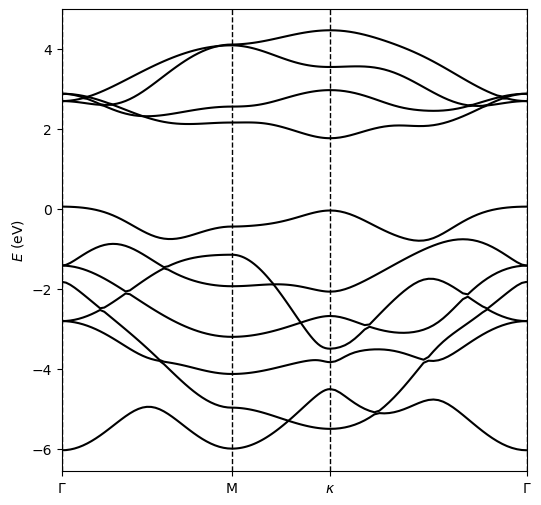

In [343]:
fig,ax=plt.subplots(figsize=(6,6))
MoS2.plot_dispersion(XM2=True,ax=ax,color='k',func=MoS2.get_Hamiltonian_monolayer_spinless)
# MoS2.plot_dispersion(XM2=True,ax=ax,color='r',line='K_M_Kp_G')
# ax.set_ylim(-1,.5)

(-1.0, 0.5)

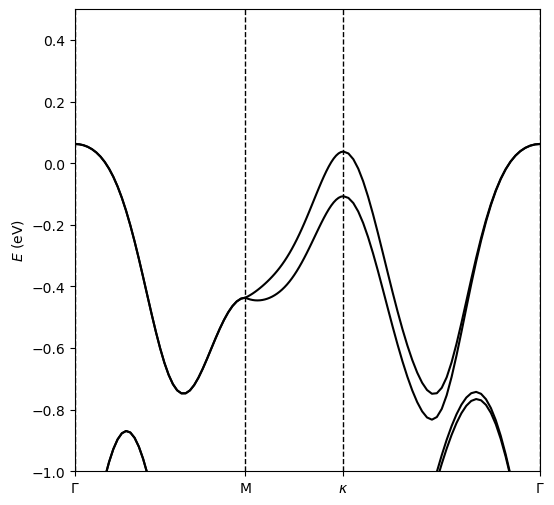

In [499]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2.plot_dispersion(XM2=True,ax=ax,color='k',func=MoS2.get_Hamiltonian_monolayer_spinful)
# MoS2.plot_dispersion(XM2=True,ax=ax,color='r',line='K_M_Kp_G')
ax.set_ylim(-1,.5)

In [384]:
energy_list[80,8:10]

array([ 0.03806205, -0.10700283])

array([[ 4.50304289,  4.44291806,  3.57017626, ..., -4.52421037,
        -5.49584355, -5.49658883],
       [ 4.50243831,  4.44236361,  3.57055332, ..., -4.53026336,
        -5.49492705, -5.49568192],
       [ 4.50064037,  4.4407122 ,  3.57176538, ..., -4.54783161,
        -5.49222831, -5.49301151],
       ...,
       [ 2.88369357,  2.8836256 ,  2.85957946, ..., -2.84878148,
        -6.00559427, -6.00560463],
       [ 2.89468828,  2.89467999,  2.87234113, ..., -2.84562125,
        -6.02526795, -6.02526922],
       [ 2.89860123,  2.89860123,  2.87645072, ..., -2.84559597,
        -6.03185908, -6.03185908]])

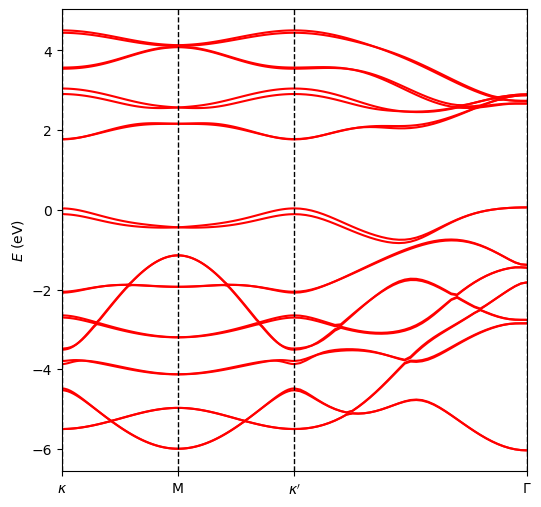

In [500]:
fig,ax=plt.subplots(figsize=(6,6))
# MoS2.plot_dispersion(XM2=True,ax=ax,color='k')
MoS2.plot_dispersion(XM2=True,ax=ax,color='r',line='K_M_Kp_G',func=MoS2.get_Hamiltonian_monolayer_spinful)

(-1.0, 0.5)

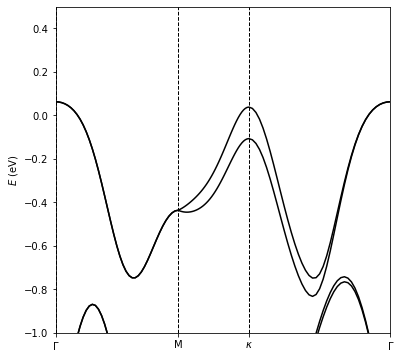

In [276]:
MoS2=Monolayer(data_TB=data_TB,material='MoS2',data_lattice=data_lattice,data_SOC=data_SOC)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2.plot_dispersion(XM2=True,ax=ax,color='k',func=MoS2.get_Hamiltonian_monolayer_spinful)
ax.set_ylim(-1,.5)

[Text(0, 0, '$\\Gamma$'), Text(39, 0, 'K')]

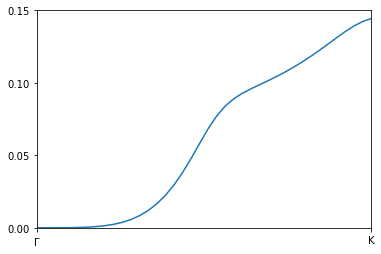

In [279]:
splitting=energy_list[-40:,8]-energy_list[-40:,9]
fig,ax=plt.subplots()
ax.plot(splitting[::-1])
ax.set_xlim(0,39)
ax.set_ylim(0,0.15)
ax.set_yticks(np.arange(0,0.16,0.05))
ax.set_xticks([0,39])
ax.set_xticklabels(['$\Gamma$','K'])

(-1.0, 0.5)

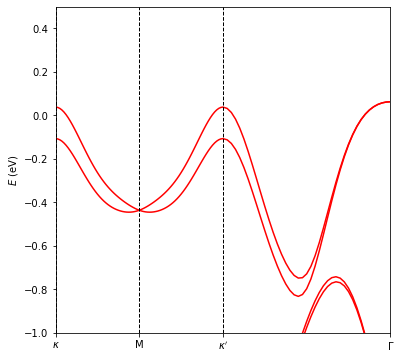

In [275]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2.plot_dispersion(XM2=True,ax=ax,color='r',func=MoS2.get_Hamiltonian_monolayer_spinful,line='K_M_Kp_G')
ax.set_ylim(-1,.5)

### WSe2

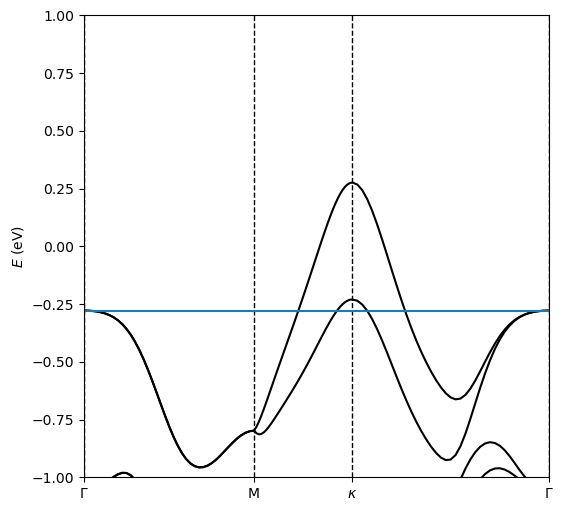

In [13]:
WSe2=Monolayer(data_TB=data_TB,material='WSe2',data_lattice=data_lattice,data_SOC=data_SOC)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2.plot_dispersion(XM2=True,ax=ax,color='k',func=WSe2.get_Hamiltonian_monolayer_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,8])

# Bilayer

## MoS2

### AB

#### XX

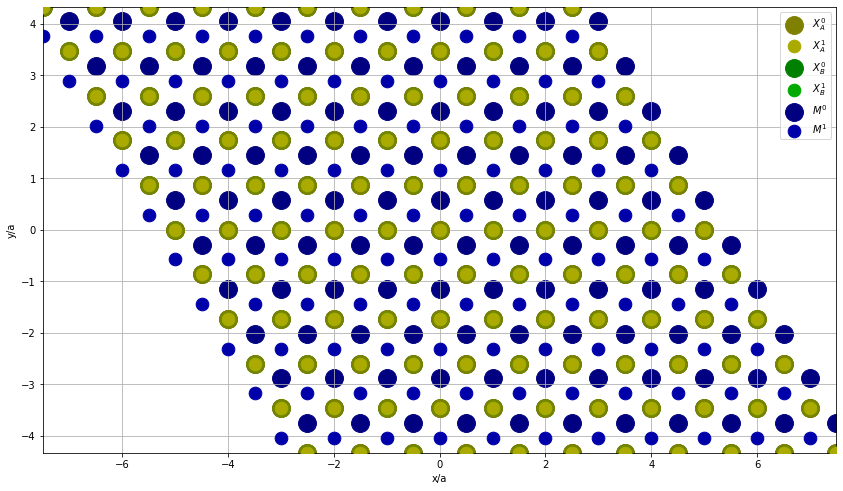

In [100]:
MoS2_AB_XX=Multilayer(material='MoS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180], shift_M_list=[0])
MoS2_AB_XX.plot_lattice(scale=1.5)

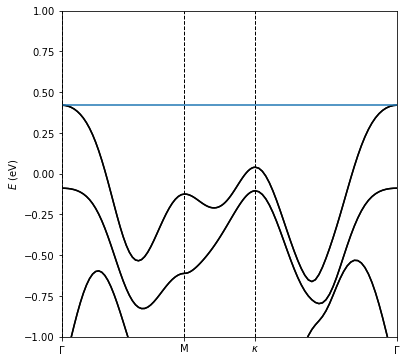

In [238]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_AB_XX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_AB_XX.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [241]:
check_bilayer_TRS_spinful(MoS2_AB_XX,1,1),check_bilayer_C2x_spinful(MoS2_AB_XX,1,1),check_bilayer_M2_spinful(MoS2_AB_XX,1,1),

(0.0, 2.0471501066083613e-15, 2.0471501066083613e-15)

#### XM

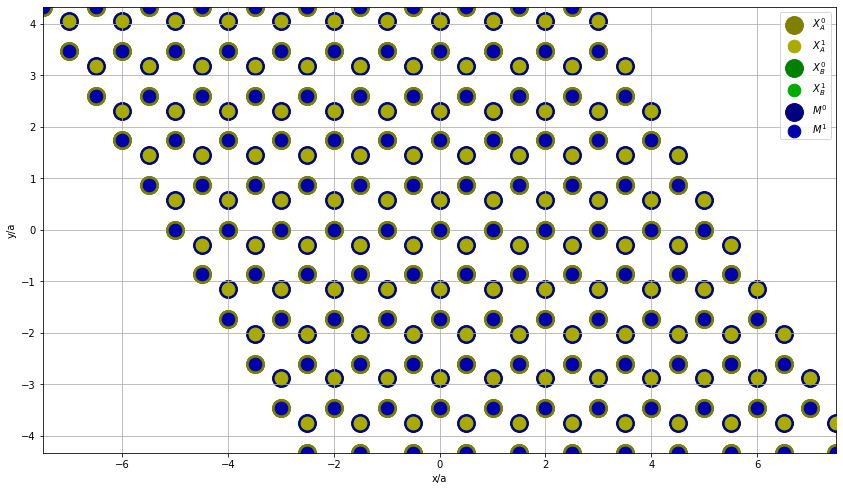

In [74]:
MoS2_AB_XM=Multilayer(material='MoS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180], shift_M_list=[1])
MoS2_AB_XM.plot_lattice(scale=1.5)

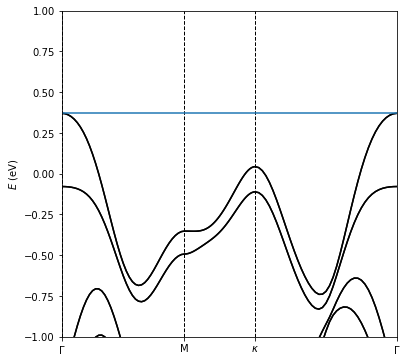

In [240]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_AB_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_AB_XM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [242]:
check_bilayer_TRS_spinful(MoS2_AB_XM,1,1),check_bilayer_C2x_spinful(MoS2_AB_XM,1,1),check_bilayer_M2_spinful(MoS2_AB_XM,1,1),

(0.0, 2.0471501066083613e-15, 2.0471501066083613e-15)

#### MM

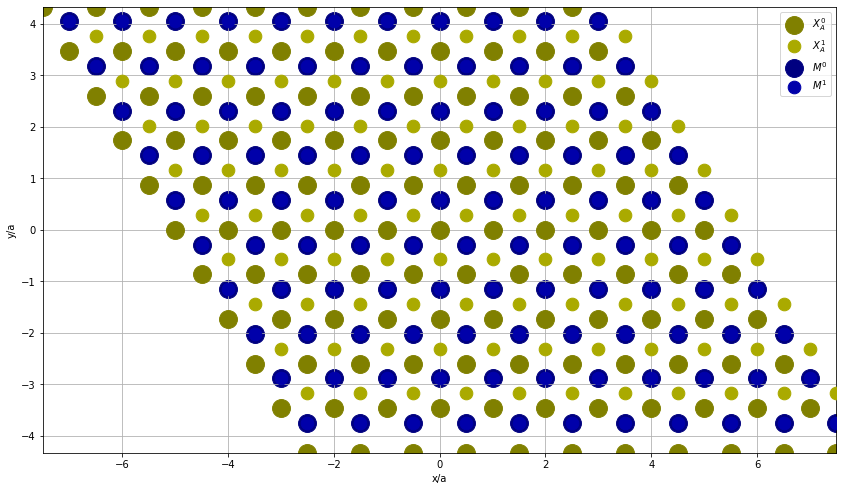

In [248]:
MoS2_AB_MM=Multilayer(material='MoS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180], shift_M_list=[2])
MoS2_AB_MM.plot_lattice(scale=1.5,XB=False)

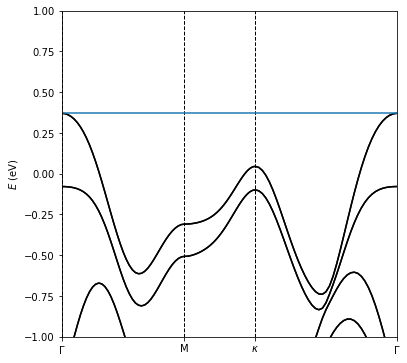

In [249]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_AB_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_AB_MM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [250]:
check_bilayer_TRS_spinful(MoS2_AB_MM,1,1),check_bilayer_C2x_spinful(MoS2_AB_MM,1,1),check_bilayer_M2_spinful(MoS2_AB_MM,1,1),

(0.0, 2.0471501066083613e-15, 2.0471501066083613e-15)

### AA

#### MM

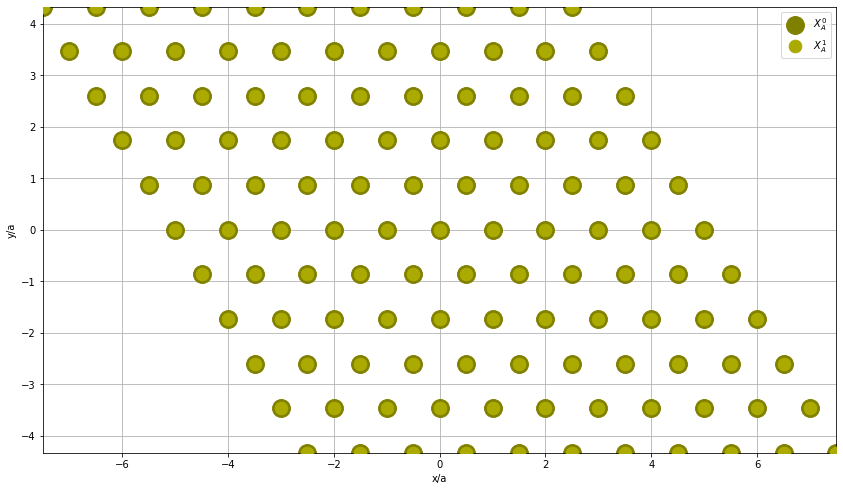

In [444]:
MoS2_AA_MM=Multilayer(material='MoS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0], shift_M_list=[0])
MoS2_AA_MM.plot_lattice(scale=1.5,XB=False,M=False)

In [448]:
Ham=MoS2_AA_MM.get_Hamiltonian_spinful(*MoS2_AA_MM.high_symm['kappa'])

In [449]:
val,vec=get_energy(Ham)

In [450]:
val[[16,17]]

array([0.06720803, 0.01063975])

In [ ]:
vec

In [ ]:
pd.DataFrame(np.round(vec[:,[16,17]],3))

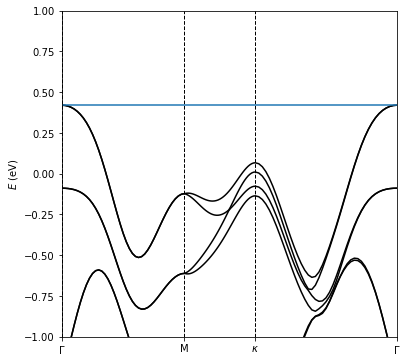

In [504]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_AA_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_AA_MM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [506]:
energy_list[0,16]-energy_list[0,18]

0.5087386497548527

In [254]:
check_bilayer_TRS_spinful(MoS2_AA_MM,1,1),check_bilayer_M1_spinful(MoS2_AA_MM,1,1),check_bilayer_M2_spinful(MoS2_AA_MM,1,1),

(0.0, 3.469446951953614e-18, 2.0471501066083613e-15)

#### MX

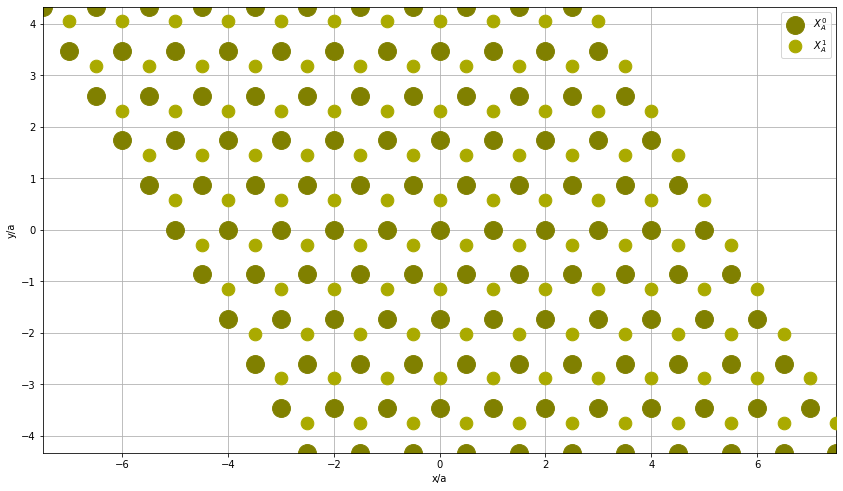

In [306]:
MoS2_AA_MX=Multilayer(material='MoS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0], shift_M_list=[1])
MoS2_AA_MX.plot_lattice(scale=1.5,XB=False,M=False)

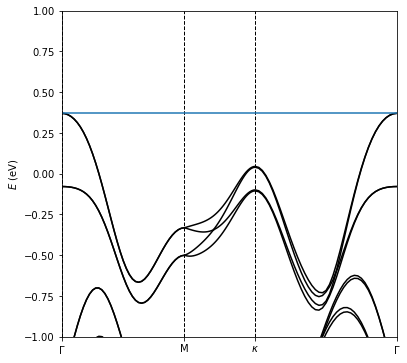

In [296]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_AA_MX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_AA_MX.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [304]:
check_bilayer_TRS_spinful(MoS2_AA_MX,1,1),check_bilayer_C2x_spinful(MoS2_AA_MX,1,1),check_bilayer_M2_spinful(MoS2_AA_MX,1,1),

(0.0, 4.177193155200678, 2.0471501066083613e-15)

#### XM

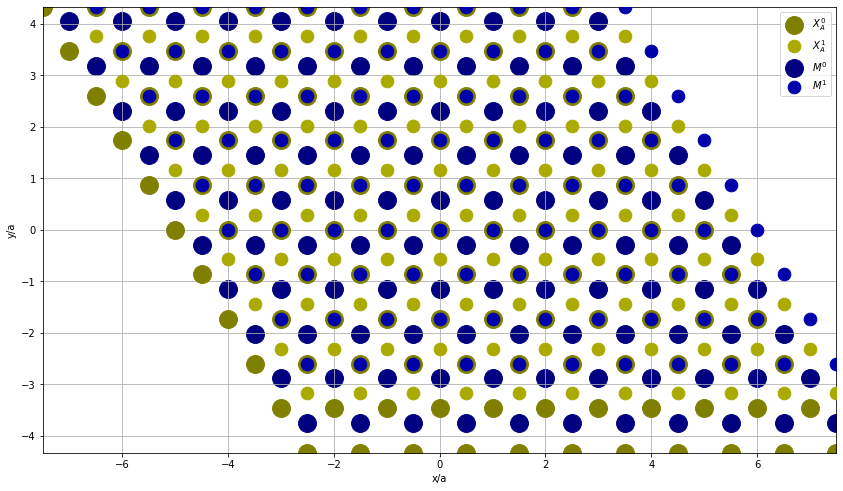

In [301]:
MoS2_AA_XM=Multilayer(material='MoS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0], shift_M_list=[2])
MoS2_AA_XM.plot_lattice(scale=1.5,XB=False)

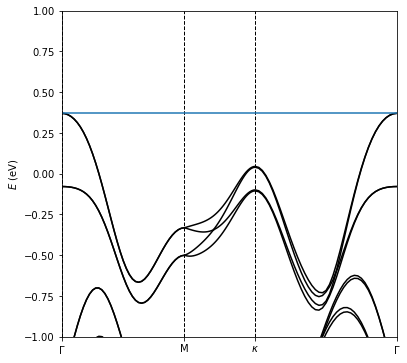

In [302]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_AA_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_AA_XM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

## MoSe2

### AB

#### XX

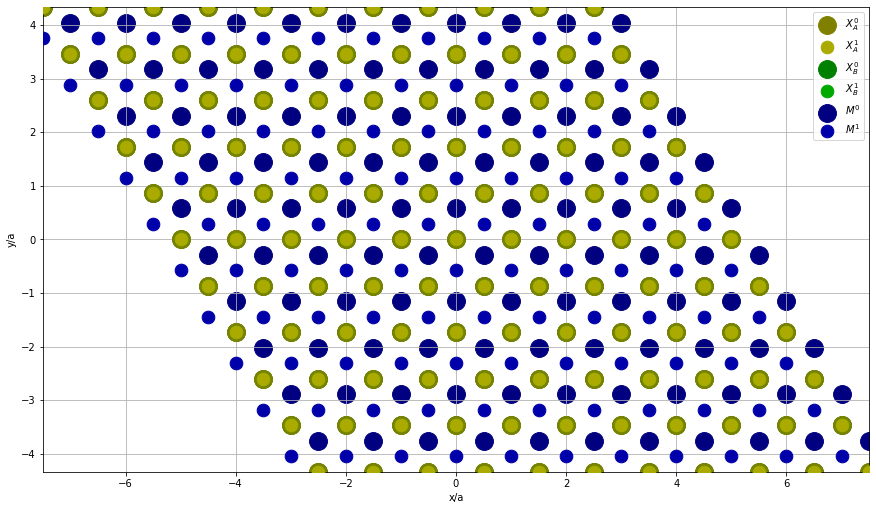

In [137]:
MoSe2_AB_XX=Multilayer(material='MoSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180], shift_M_list=[0])
MoSe2_AB_XX.plot_lattice(scale=1.5)

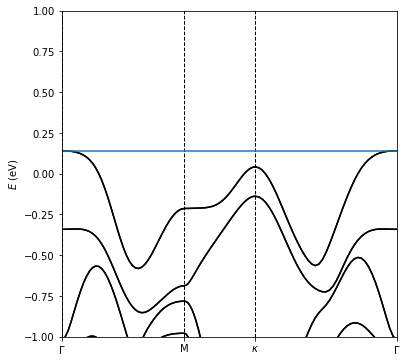

In [138]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoSe2_AB_XX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoSe2_AB_XX.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [139]:
check_bilayer_TRS_spinful(MoSe2_AB_XX,1,1),check_bilayer_C2x_spinful(MoSe2_AB_XX,1,1),check_bilayer_M2_spinful(MoSe2_AB_XX,1,1),

(0.0, 2.9976021664879227e-15, 2.9976021664879227e-15)

#### XM

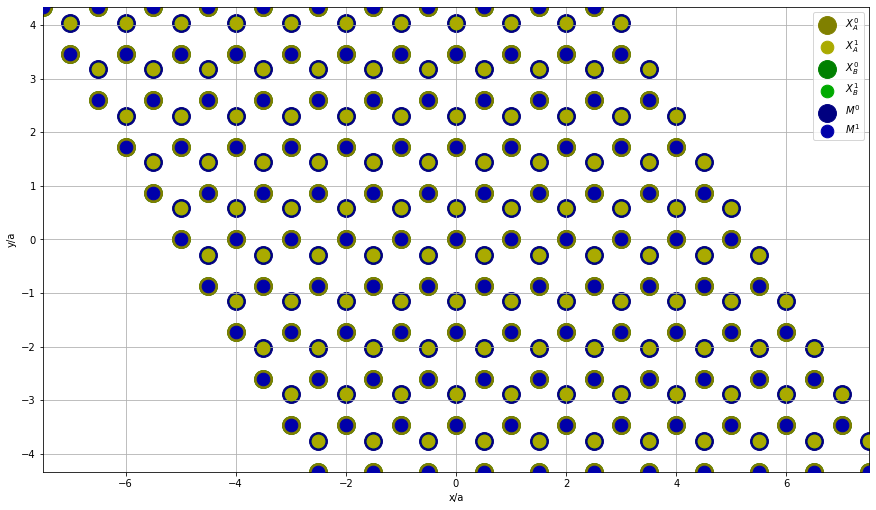

In [141]:
MoSe2_AB_XM=Multilayer(material='MoSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180], shift_M_list=[1])
MoSe2_AB_XM.plot_lattice(scale=1.5)

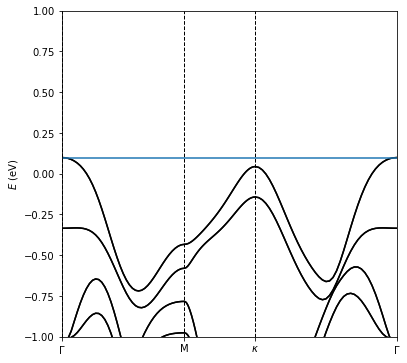

In [142]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoSe2_AB_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoSe2_AB_XM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [143]:
check_bilayer_TRS_spinful(MoSe2_AB_XM,1,1),check_bilayer_C2x_spinful(MoSe2_AB_XM,1,1),check_bilayer_M2_spinful(MoSe2_AB_XM,1,1),

(0.0, 2.9976021664879227e-15, 2.9976021664879227e-15)

#### MM

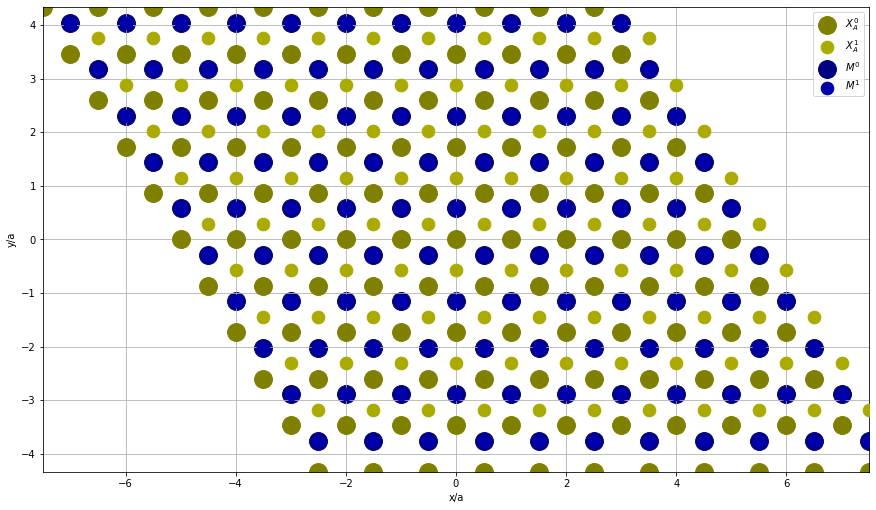

In [144]:
MoSe2_AB_MM=Multilayer(material='MoSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180], shift_M_list=[2])
MoSe2_AB_MM.plot_lattice(scale=1.5,XB=False)

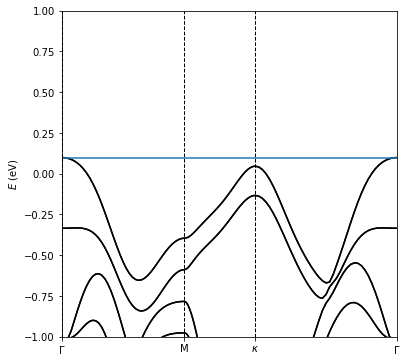

In [145]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoSe2_AB_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoSe2_AB_MM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [146]:
check_bilayer_TRS_spinful(MoSe2_AB_MM,1,1),check_bilayer_C2x_spinful(MoSe2_AB_MM,1,1),check_bilayer_M2_spinful(MoSe2_AB_MM,1,1),

(0.0, 2.9976021664879227e-15, 2.9976021664879227e-15)

### AA

#### MM

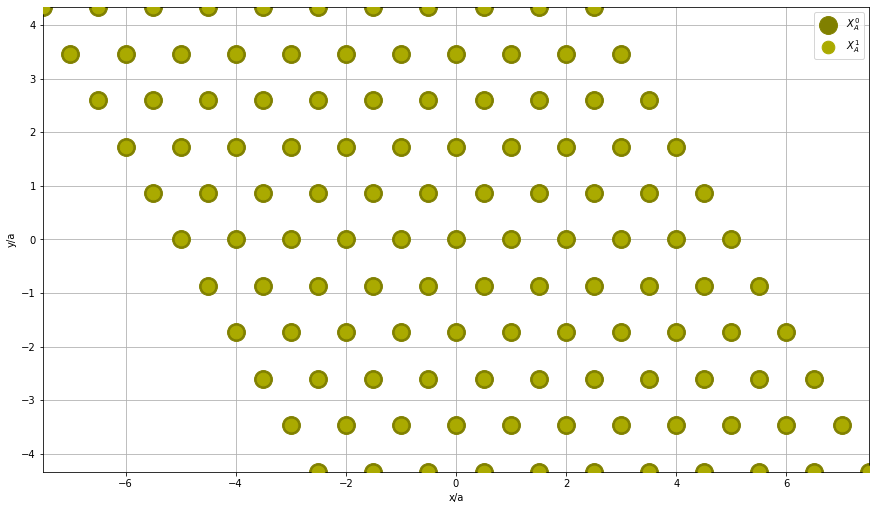

In [147]:
MoSe2_AA_MM=Multilayer(material='MoSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0], shift_M_list=[0])
MoSe2_AA_MM.plot_lattice(scale=1.5,XB=False,M=False)

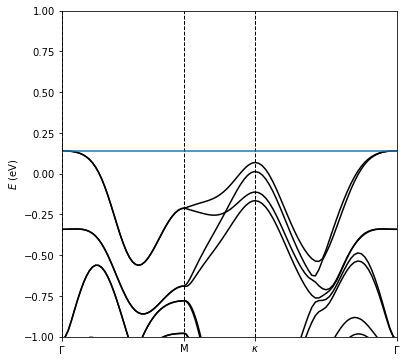

In [148]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoSe2_AA_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoSe2_AA_MM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [149]:
check_bilayer_TRS_spinful(MoSe2_AA_MM,1,1),check_bilayer_M1_spinful(MoSe2_AA_MM,1,1),check_bilayer_M2_spinful(MoSe2_AA_MM,1,1),

(0.0, 3.469446951953614e-18, 2.9976021664879227e-15)

#### MX

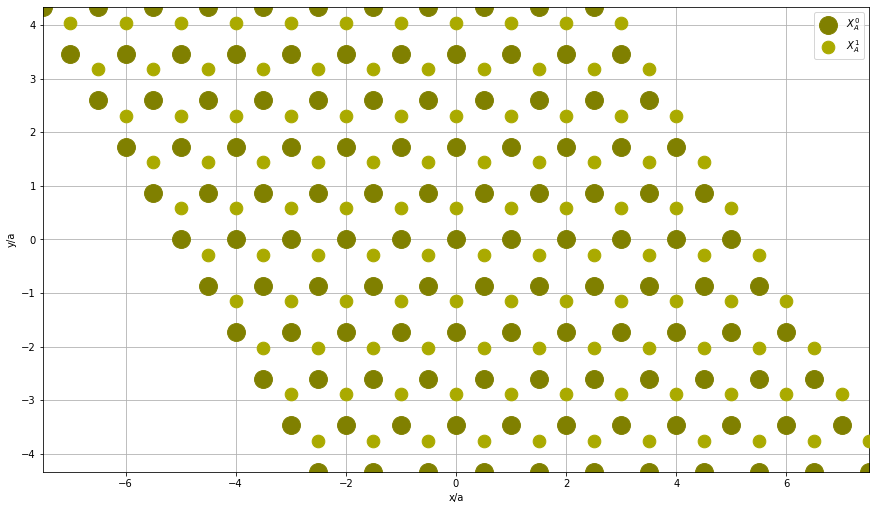

In [150]:
MoSe2_AA_MX=Multilayer(material='MoSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0], shift_M_list=[1])
MoSe2_AA_MX.plot_lattice(scale=1.5,XB=False,M=False)

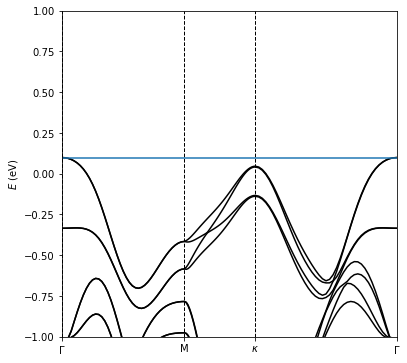

In [151]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoSe2_AA_MX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoSe2_AA_MX.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [152]:
check_bilayer_TRS_spinful(MoSe2_AA_MX,1,1),check_bilayer_C2x_spinful(MoSe2_AA_MX,1,1),check_bilayer_M2_spinful(MoSe2_AA_MX,1,1),

(0.0, 3.7248083551895608, 2.9976021664879227e-15)

#### XM

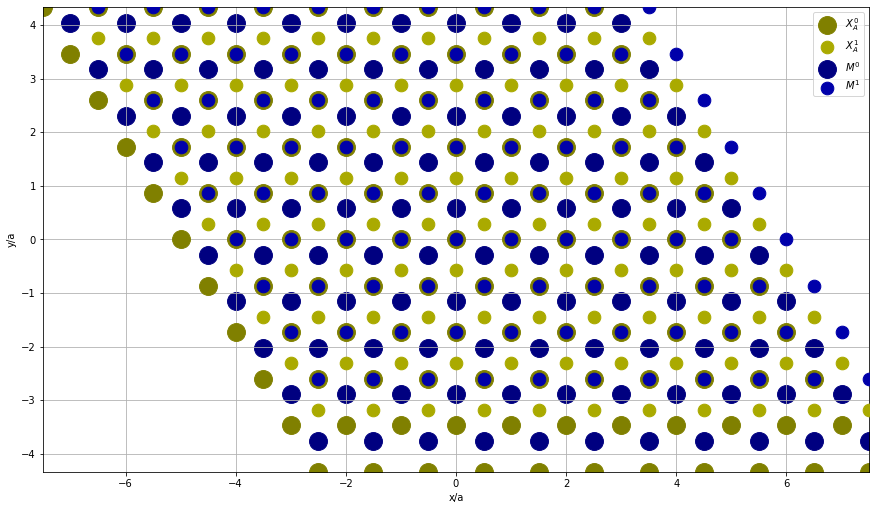

In [153]:
MoSe2_AA_XM=Multilayer(material='MoSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0], shift_M_list=[2])
MoSe2_AA_XM.plot_lattice(scale=1.5,XB=False)

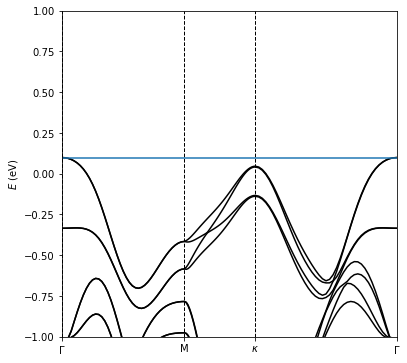

In [154]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoSe2_AA_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoSe2_AA_XM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

## WS2

### AB

#### XX

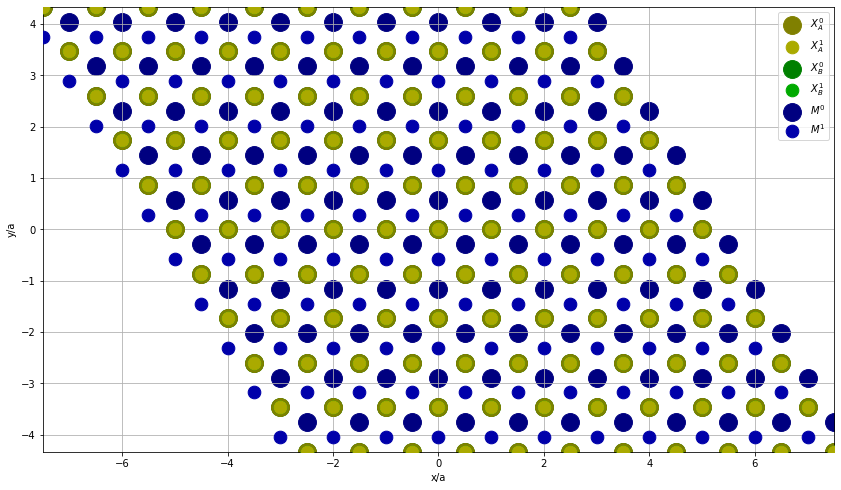

In [155]:
WS2_AB_XX=Multilayer(material='WS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180], shift_M_list=[0])
WS2_AB_XX.plot_lattice(scale=1.5)

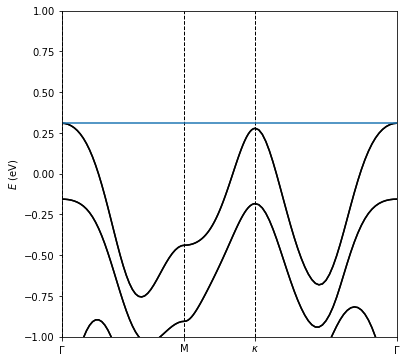

In [156]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WS2_AB_XX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WS2_AB_XX.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [157]:
check_bilayer_TRS_spinful(WS2_AB_XX,1,1),check_bilayer_C2x_spinful(WS2_AB_XX,1,1),check_bilayer_M2_spinful(WS2_AB_XX,1,1),

(0.0, 2.0471501066083613e-15, 2.0471501066083613e-15)

#### XM

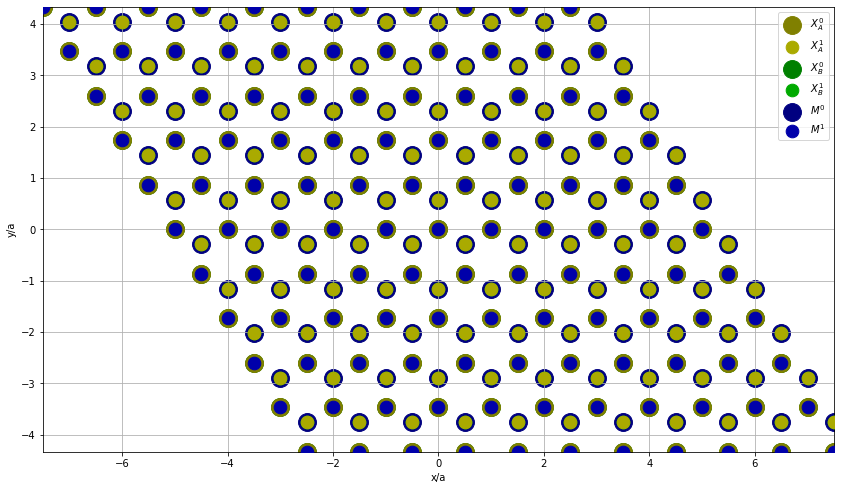

In [158]:
WS2_AB_XM=Multilayer(material='WS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180], shift_M_list=[1])
WS2_AB_XM.plot_lattice(scale=1.5)

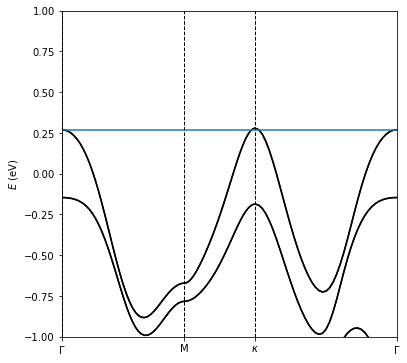

In [159]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WS2_AB_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WS2_AB_XM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [160]:
check_bilayer_TRS_spinful(WS2_AB_XM,1,1),check_bilayer_C2x_spinful(WS2_AB_XM,1,1),check_bilayer_M2_spinful(WS2_AB_XM,1,1),

(0.0, 2.0471501066083613e-15, 2.0471501066083613e-15)

#### MM

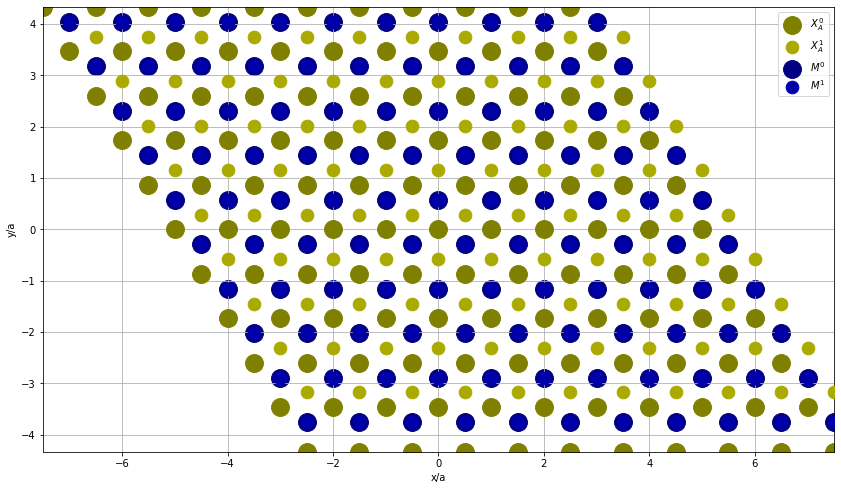

In [161]:
WS2_AB_MM=Multilayer(material='WS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180], shift_M_list=[2])
WS2_AB_MM.plot_lattice(scale=1.5,XB=False)

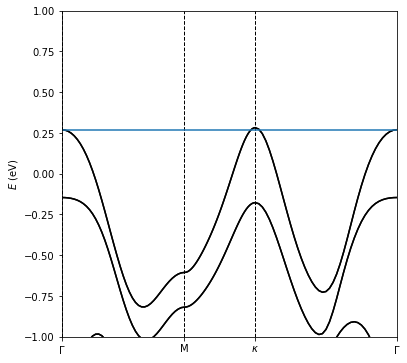

In [162]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WS2_AB_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WS2_AB_MM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [163]:
check_bilayer_TRS_spinful(WS2_AB_MM,1,1),check_bilayer_C2x_spinful(WS2_AB_MM,1,1),check_bilayer_M2_spinful(WS2_AB_MM,1,1),

(0.0, 2.0471501066083613e-15, 2.0471501066083613e-15)

### AA

#### MM

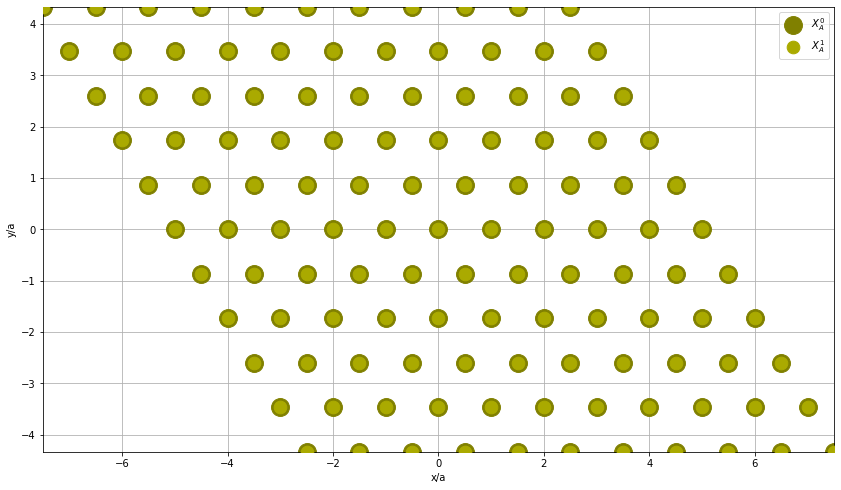

In [164]:
WS2_AA_MM=Multilayer(material='WS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0], shift_M_list=[0])
WS2_AA_MM.plot_lattice(scale=1.5,XB=False,M=False)

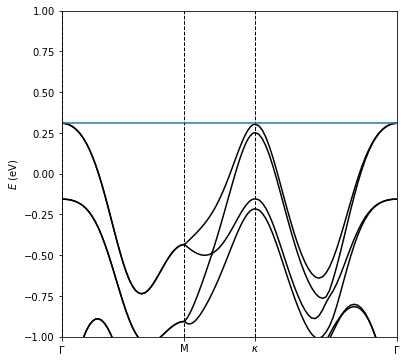

In [165]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WS2_AA_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WS2_AA_MM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [166]:
check_bilayer_TRS_spinful(WS2_AA_MM,1,1),check_bilayer_M1_spinful(WS2_AA_MM,1,1),check_bilayer_M2_spinful(WS2_AA_MM,1,1),

(0.0, 3.469446951953614e-18, 2.0471501066083613e-15)

#### MX

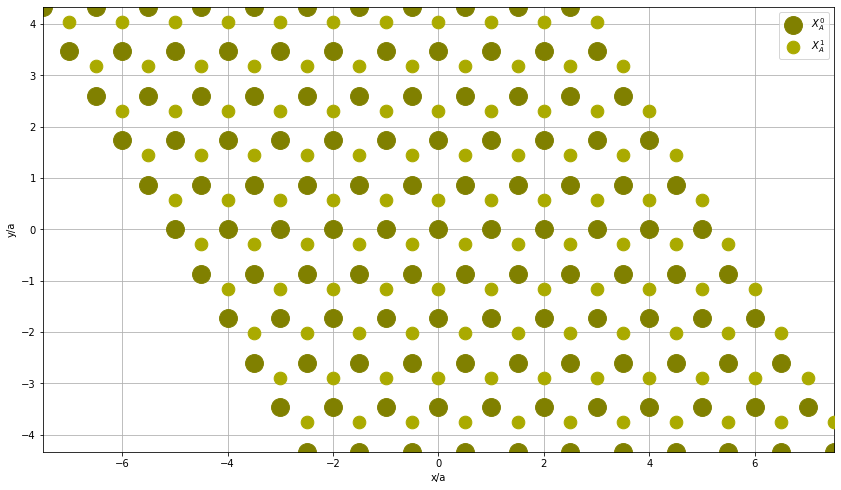

In [167]:
WS2_AA_MX=Multilayer(material='WS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0], shift_M_list=[1])
WS2_AA_MX.plot_lattice(scale=1.5,XB=False,M=False)

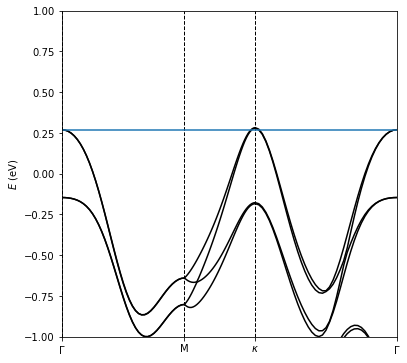

In [168]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WS2_AA_MX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WS2_AA_MX.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [169]:
check_bilayer_TRS_spinful(WS2_AA_MX,1,1),check_bilayer_C2x_spinful(WS2_AA_MX,1,1),check_bilayer_M2_spinful(WS2_AA_MX,1,1),

(0.0, 4.481743797538835, 2.0471501066083613e-15)

#### XM

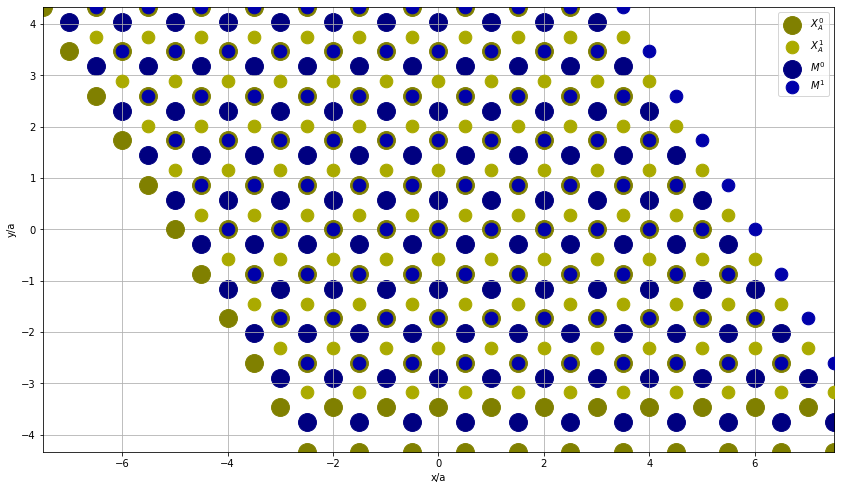

In [170]:
WS2_AA_XM=Multilayer(material='WS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0], shift_M_list=[2])
WS2_AA_XM.plot_lattice(scale=1.5,XB=False)

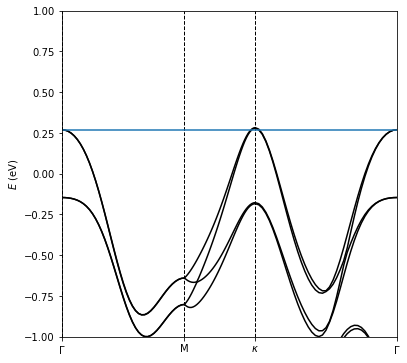

In [171]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WS2_AA_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WS2_AA_XM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

## WSe2

### AB

#### XX

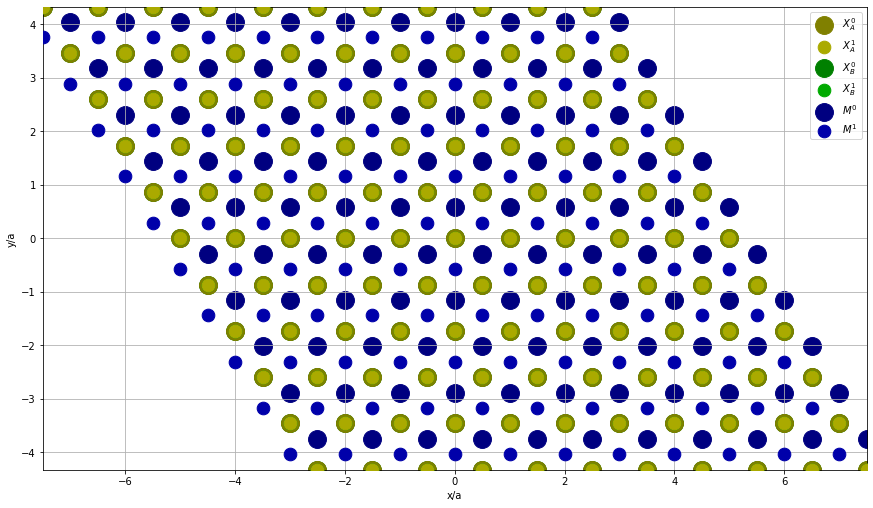

In [252]:
WSe2_AB_XX=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180], shift_M_list=[0])
WSe2_AB_XX.plot_lattice(scale=1.5)

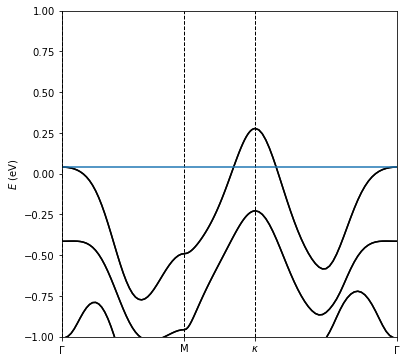

In [281]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_AB_XX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_AB_XX.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [282]:
check_bilayer_TRS_spinful(WSe2_AB_XX,1,1),check_bilayer_C2x_spinful(WSe2_AB_XX,1,1),check_bilayer_M2_spinful(WSe2_AB_XX,1,1),

(0.0, 2.112343365827712e-15, 2.112343365827712e-15)

#### XM

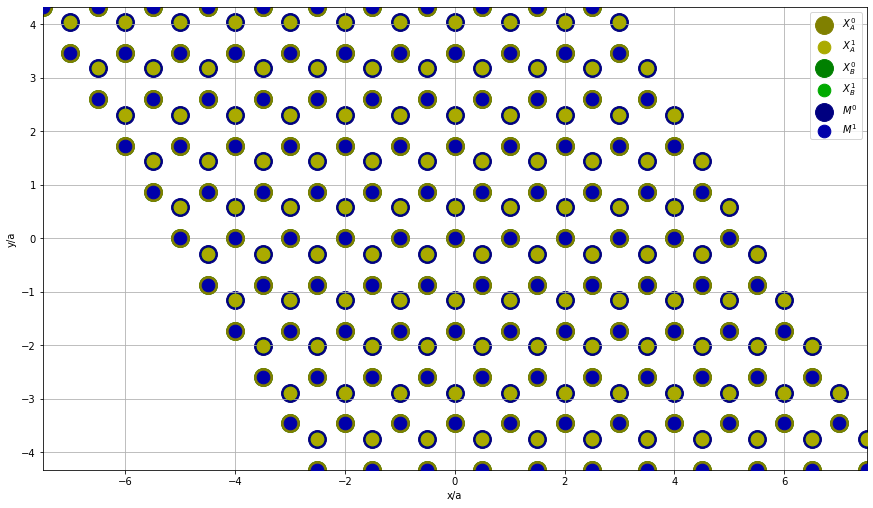

In [283]:
WSe2_AB_XM=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180], shift_M_list=[1])
WSe2_AB_XM.plot_lattice(scale=1.5)

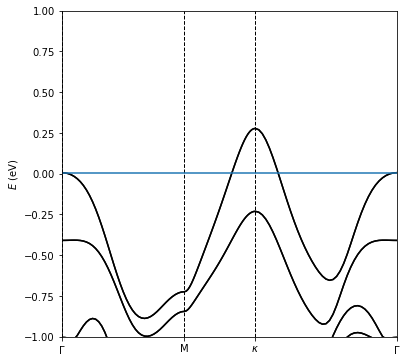

In [284]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_AB_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_AB_XM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [285]:
check_bilayer_TRS_spinful(WSe2_AB_XM,1,1),check_bilayer_C2x_spinful(WSe2_AB_XM,1,1),check_bilayer_M2_spinful(WSe2_AB_XM,1,1),

(0.0, 2.112343365827712e-15, 2.112343365827712e-15)

#### MM

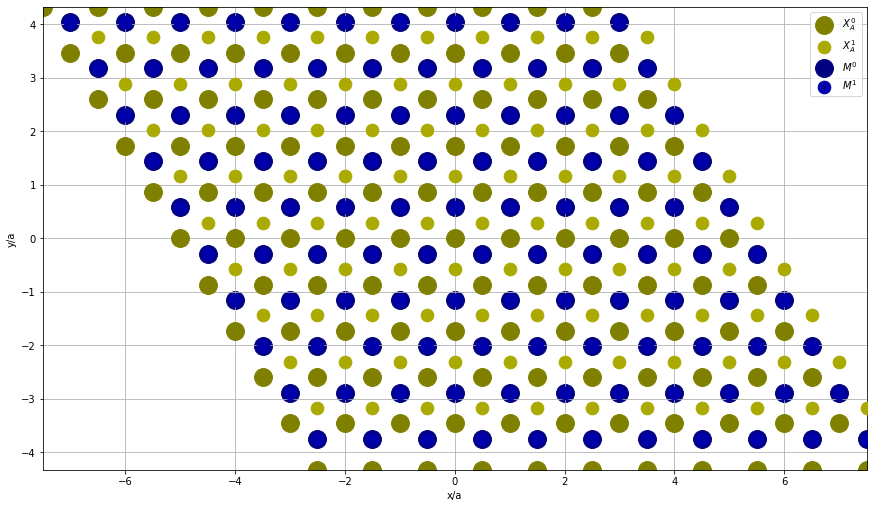

In [286]:
WSe2_AB_MM=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180], shift_M_list=[2])
WSe2_AB_MM.plot_lattice(scale=1.5,XB=False)

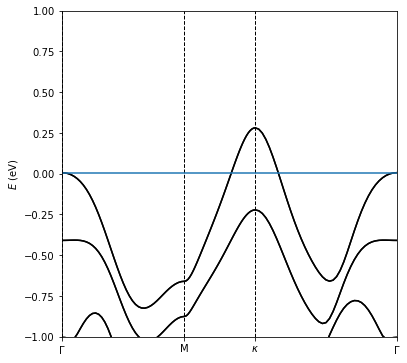

In [287]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_AB_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_AB_MM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [288]:
check_bilayer_TRS_spinful(WSe2_AB_MM,1,1),check_bilayer_C2x_spinful(WSe2_AB_MM,1,1),check_bilayer_M2_spinful(WSe2_AB_MM,1,1),

(0.0, 2.112343365827712e-15, 2.112343365827712e-15)

### AA

#### MM

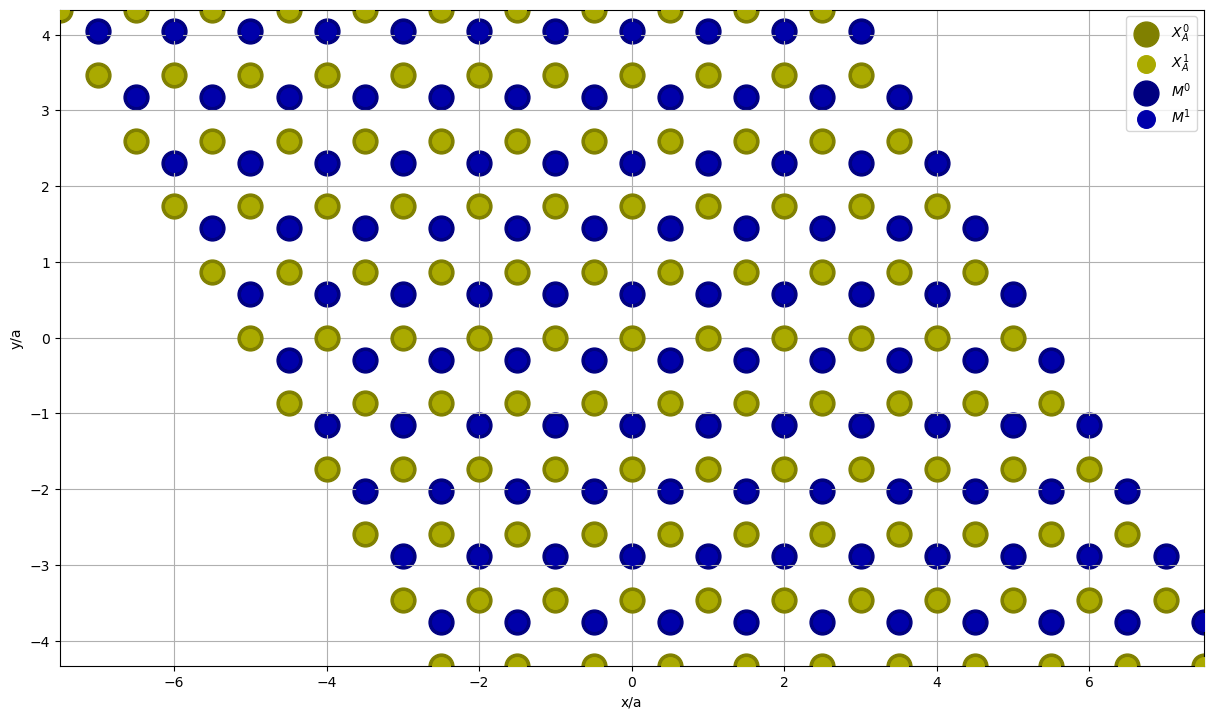

In [21]:
WSe2_AA_MM=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0], shift_M_list=[0],z_list=[6.5])
WSe2_AA_MM.plot_lattice(scale=1.5,XB=False)

In [11]:
Ham=WSe2_AA_MM.get_Hamiltonian_spinful(*WSe2_AA_MM.high_symm['kappa'])

/tmp/ipykernel_24834/1282311478.py:408: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  H_tunnel=np.zeros((11,11),dtype=np.complex)


/tmp/ipykernel_24834/1282311478.py:408: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  H_tunnel=np.zeros((11,11),dtype=np.complex)


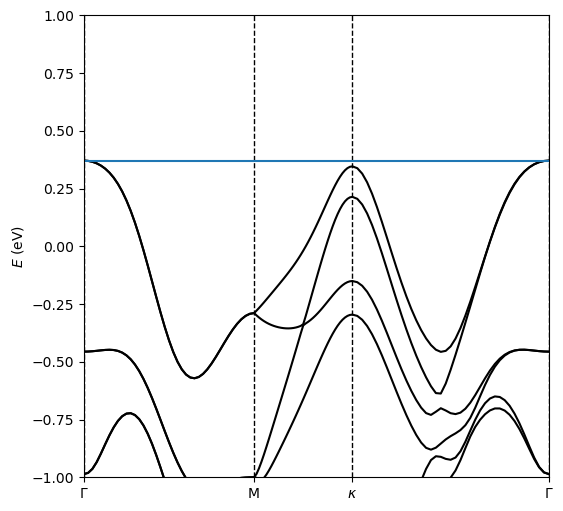

In [34]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_AA_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_AA_MM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [467]:
energy_list[80,17]

0.24918146986842288

In [465]:
(energy_list[80,16]-energy_list[80,17])/6

0.009153297892974597

In [291]:
check_bilayer_TRS_spinful(WSe2_AA_MM,1,1),check_bilayer_M1_spinful(WSe2_AA_MM,1,1),check_bilayer_M2_spinful(WSe2_AA_MM,1,1),

(0.0, 2.6020852139652106e-18, 2.112343365827712e-15)

#### MX

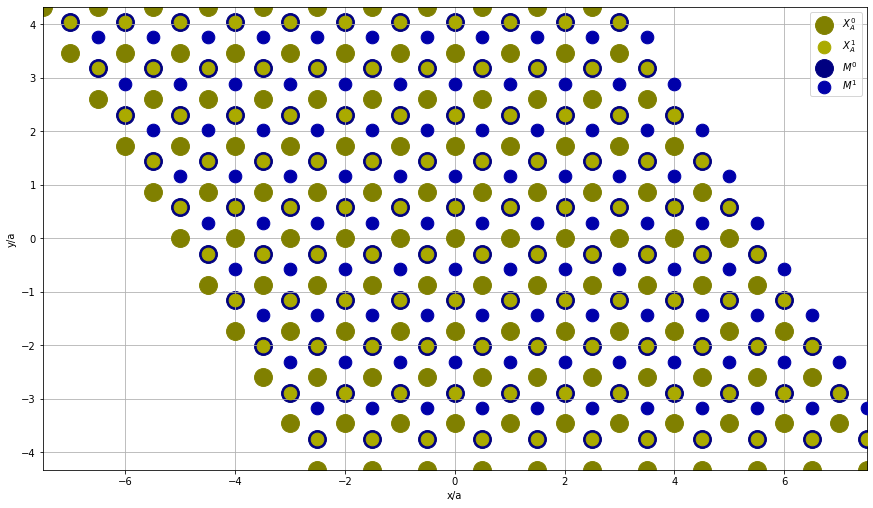

In [454]:
WSe2_AA_MX=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0], shift_M_list=[1])
WSe2_AA_MX.plot_lattice(scale=1.5,XB=False)

In [455]:
Ham=WSe2_AA_MX.get_Hamiltonian_spinful(*WSe2_AA_MX.high_symm['kappa'])

In [456]:
val,vec=get_energy(Ham)

In [457]:
val[[16,17,18,19]]

array([ 0.28137988,  0.27714141, -0.22176685, -0.22838691])

In [458]:
np.linalg.norm(vec[:,16].reshape((2,-1)),axis=1)

array([0.05905697, 0.99825461])

In [459]:
np.linalg.norm(vec[:,17].reshape((2,-1)),axis=1)

array([0.99970852, 0.0241429 ])

In [460]:
np.linalg.norm(vec[:,16].reshape((-1,2)),axis=0)

array([0.99993724, 0.01120365])

In [461]:
np.linalg.norm(vec[:,17].reshape((-1,2)),axis=0)

array([9.99999551e-01, 9.47797224e-04])

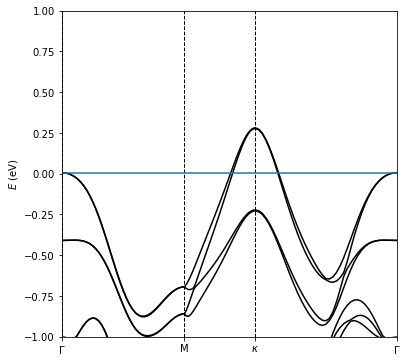

In [468]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_AA_MX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_AA_MX.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [478]:
from scipy.optimize import fsolve

In [484]:
def func(x):
    return np.cos(x)-.5

In [485]:
root=fsolve(func,0.1)

In [486]:
root

array([5.23598776])

In [502]:
np.sum([np.cos(b@(WSe2_AA_MX.a1+2*WSe2_AA_MX.a2)/3)for b in WSe2_AA_MX.g])

-2.999999999999998

In [503]:
np.sum([np.cos(b@(WSe2_AA_MX.a1+2*WSe2_AA_MX.a2)*2/3)for b in WSe2_AA_MX.g])

-3.000000000000005

In [497]:
np.sum([np.cos(b@(WSe2_AA_MX.a1+2*WSe2_AA_MX.a2)/3+x[1])for b in WSe2_AA_MX.g])

IndexError: invalid index to scalar variable.

In [490]:
def func(x):
    cos_pos=np.sum([np.cos(b@(WSe2_AA_MX.a1+2*WSe2_AA_MX.a2)/3+x[1])for b in WSe2_AA_MX.g[::2]])
    cos_neg=np.sum([np.cos(b@(WSe2_AA_MX.a1+2*WSe2_AA_MX.a2)/3-x[1])for b in WSe2_AA_MX.g[::2]])
    return [6*x[0]*np.cos(x[1])-2*x[0]*cos_pos-(304-281-3*9.1),
            6*x[0]*np.cos(x[1])-2*x[0]*cos_neg-(304-277-3*9.1)]

In [495]:
root=fsolve(func,[10,0])

In [496]:
root

array([-0.46201384, -0.9846749 ])

In [494]:
304-281-3*9.1

-4.299999999999997

In [471]:
(WSe2_AA_MX.a1+2*WSe2_AA_MX.a2)/3

array([4.44089210e-16, 1.89370888e+00])

In [477]:
[np.cos(b@(WSe2_AA_MX.a1+2*WSe2_AA_MX.a2)/3+psi)for b in WSe2_AA_MX.g[1::2]]

[2.0943951023931944, -4.188790204786392, 2.094395102393194]

In [469]:
energy_list[80,16],energy_list[80,17]

(0.28137987873666775, 0.27714140974345886)

#### XM

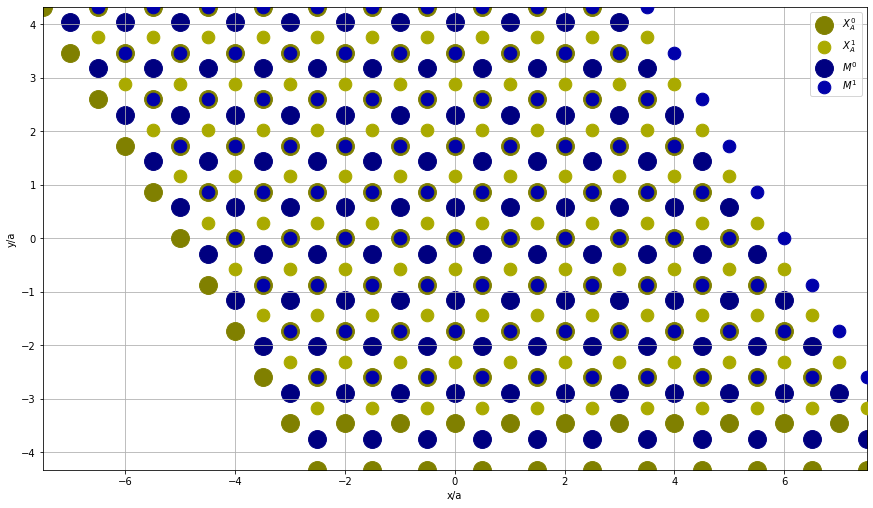

In [307]:
WSe2_AA_XM=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0], shift_M_list=[2])
WSe2_AA_XM.plot_lattice(scale=1.5,XB=False)

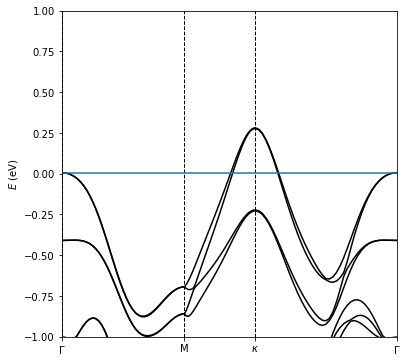

In [308]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_AA_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_AA_XM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

# Trilayer

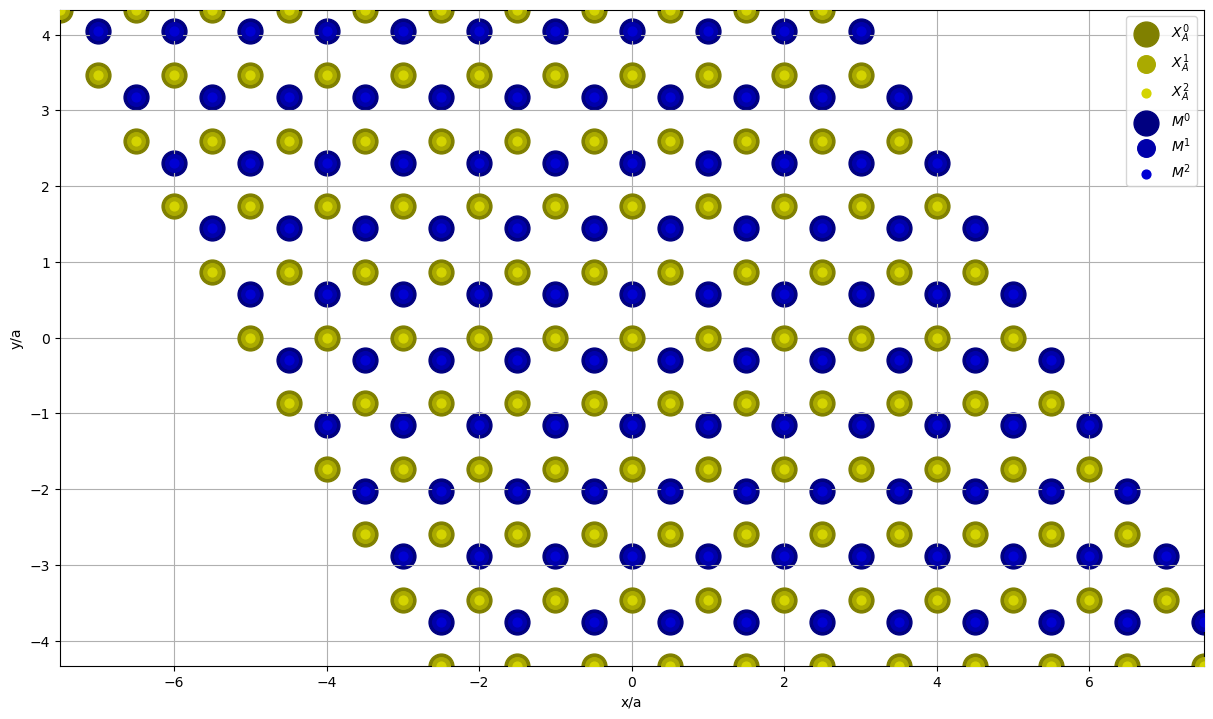

In [29]:
WSe2_AAA_MMM=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0,0], shift_M_list=[0,0],z_list=[6.,6.])
WSe2_AAA_MMM.plot_lattice(scale=1.5,XB=False)

/tmp/ipykernel_24834/1282311478.py:408: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  H_tunnel=np.zeros((11,11),dtype=np.complex)


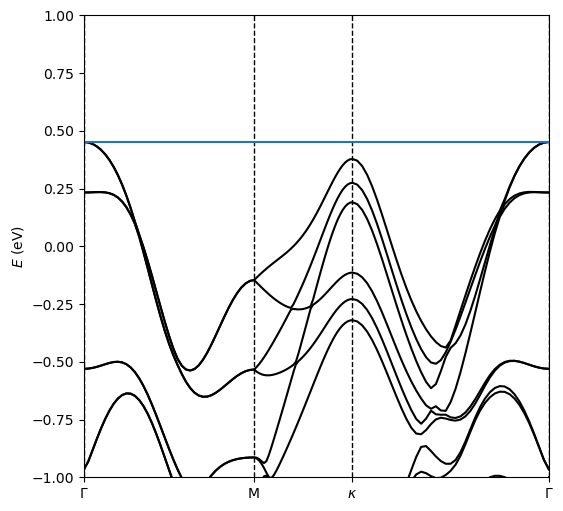

In [30]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_AAA_MMM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_AAA_MMM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,24])

#### Quadlayer

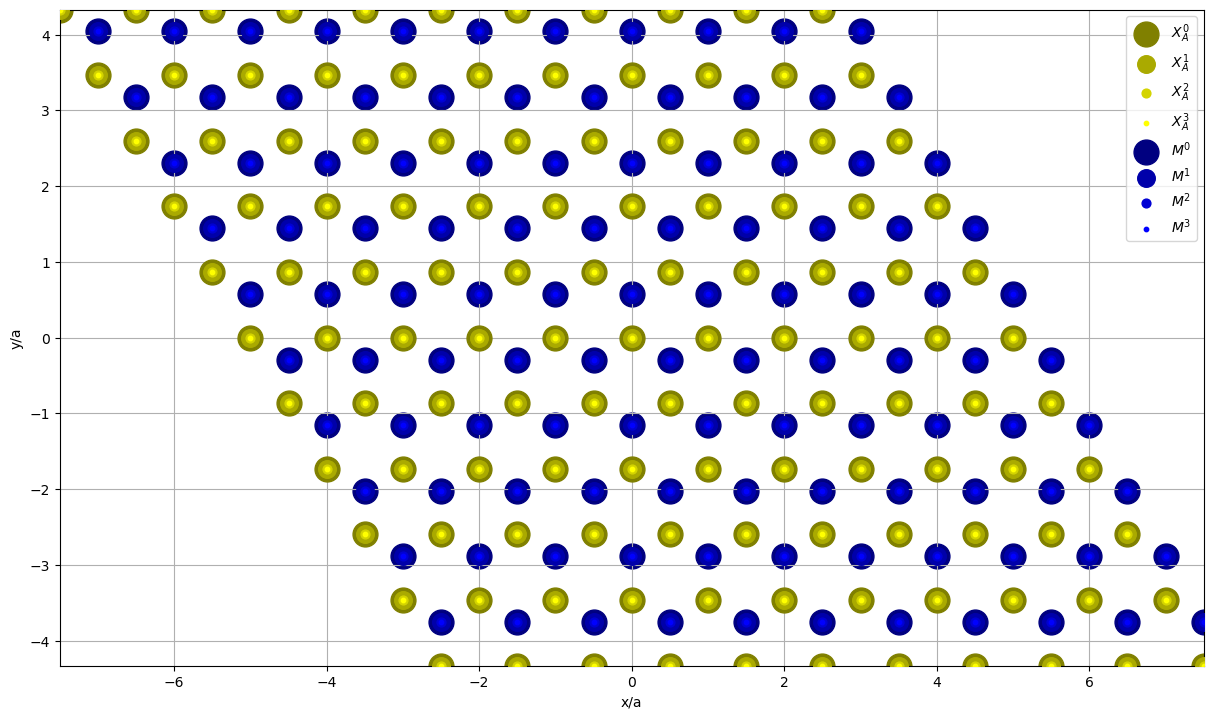

In [31]:
WSe2_AAAA_MMMM=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[0,0,0], shift_M_list=[0,0,0],z_list=[6,6,6])
WSe2_AAAA_MMMM.plot_lattice(scale=1.5,XB=False)

/tmp/ipykernel_24834/1282311478.py:408: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  H_tunnel=np.zeros((11,11),dtype=np.complex)


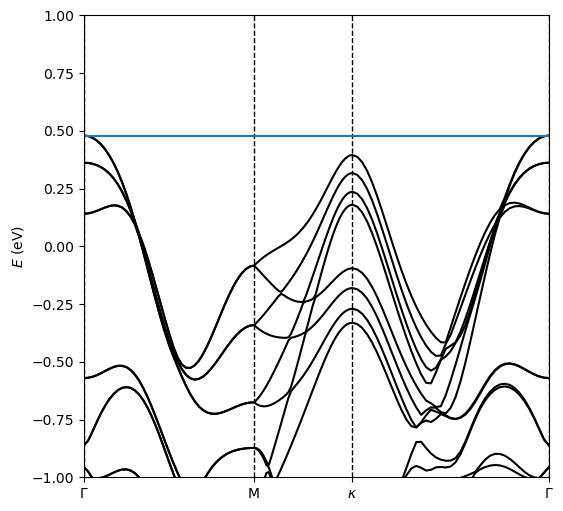

In [32]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_AAAA_MMMM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_AAAA_MMMM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,32])

# Four layers

## MoS2

### ABBA

#### MM

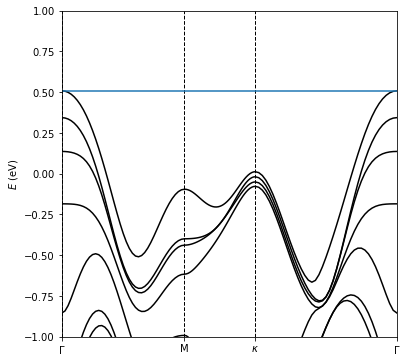

In [287]:
MoS2_ABBA_MM=Multilayer(material='MoS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,1,0])
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_ABBA_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_ABBA_MM.get_Hamiltonian_spinless)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [288]:
check_bilayer_M1_spinless(MoS2_ABBA_MM,1,1)

6.550551057807856e-16

In [289]:
check_bilayer_M2_spinless(MoS2_ABBA_MM,1,1)

2.0471501066083613e-15

In [290]:
check_bilayer_TRS_spinless(MoS2_ABBA_MM,1,1)

0.0

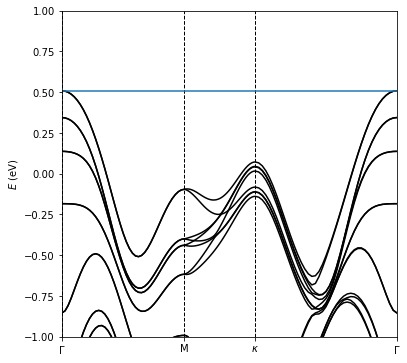

In [291]:
MoS2_ABBA_MM=Multilayer(material='MoS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,1,0])
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_ABBA_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_ABBA_MM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,32])

In [292]:
check_bilayer_M1_spinful(MoS2_ABBA_MM,1,1)

6.550551057807856e-16

In [293]:
check_bilayer_M2_spinful(MoS2_ABBA_MM,1,1)

2.0471501066083613e-15

In [294]:
check_bilayer_TRS_spinful(MoS2_ABBA_MM,1,1)

0.0

In [302]:
Ham=MoS2_ABBA_MM.get_Hamiltonian_spinful(*MoS2_ABBA.high_symm['kappa'])    
val,vec=get_energy(Ham)

In [303]:
val[32:40]

array([ 0.07221024,  0.04505891,  0.04253558,  0.01674936, -0.08186089,
       -0.11039205, -0.11161825, -0.13851117])

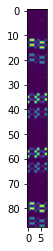

In [304]:
plt.imshow(vec[:,32:40].__abs__())

In [305]:
np.linalg.norm(vec[:,32].reshape((4,-1)),axis=1)

array([0.10865455, 0.69870894, 0.69870894, 0.10865455])

In [306]:
np.linalg.norm(vec[:,33].reshape((4,-1)),axis=1)

array([0.68934819, 0.15747722, 0.15747722, 0.68934819])

In [307]:
np.linalg.norm(vec[:,34].reshape((4,-1)),axis=1)

array([0.69957489, 0.1029319 , 0.1029319 , 0.69957489])

In [308]:
np.linalg.norm(vec[:,35].reshape((4,-1)),axis=1)

array([0.14586494, 0.69189842, 0.69189842, 0.14586494])

In [309]:
np.linalg.norm(vec[:,36].reshape((4,-1)),axis=1)

array([0.15759389, 0.68932153, 0.68932153, 0.15759389])

In [310]:
np.linalg.norm(vec[:,37].reshape((4,-1)),axis=1)

array([0.69870069, 0.10870762, 0.10870762, 0.69870069])

In [311]:
np.linalg.norm(vec[:,38].reshape((4,-1)),axis=1)

array([0.69187284, 0.1459862 , 0.1459862 , 0.69187284])

In [312]:
np.linalg.norm(vec[:,39].reshape((4,-1)),axis=1)

array([0.10298911, 0.69956647, 0.69956647, 0.10298911])

In [313]:
np.linalg.norm(vec[:,32].reshape((-1,2)),axis=0)

array([0.00223148, 0.99999751])

In [314]:
np.linalg.norm(vec[:,33].reshape((-1,2)),axis=0)

array([0.99999595, 0.00284468])

In [315]:
np.linalg.norm(vec[:,34].reshape((-1,2)),axis=0)

array([0.99999645, 0.00266637])

In [316]:
np.linalg.norm(vec[:,35].reshape((-1,2)),axis=0)

array([0.00306327, 0.99999531])

In [317]:
np.linalg.norm(vec[:,36].reshape((-1,2)),axis=0)

array([0.99991476, 0.01305666])

In [318]:
np.linalg.norm(vec[:,37].reshape((-1,2)),axis=0)

array([0.01530611, 0.99988285])

In [319]:
np.linalg.norm(vec[:,38].reshape((-1,2)),axis=0)

array([0.01518224, 0.99988474])

In [320]:
np.linalg.norm(vec[:,39].reshape((-1,2)),axis=0)

array([0.9998013 , 0.01993373])

#### MX

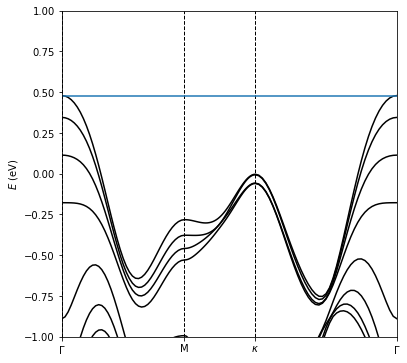

In [295]:
MoS2_ABBA_MX=Multilayer(material='MoS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,2,1])
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_ABBA_MX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_ABBA_MX.get_Hamiltonian_spinless)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [322]:
check_bilayer_M1_spinless(MoS2_ABBA_MX,1,1)

0.3838974148692653

In [323]:
check_bilayer_M2_spinless(MoS2_ABBA_MX,1,1)

2.0471501066083613e-15

In [324]:
check_bilayer_TRS_spinless(MoS2_ABBA_MX,1,1)

0.0

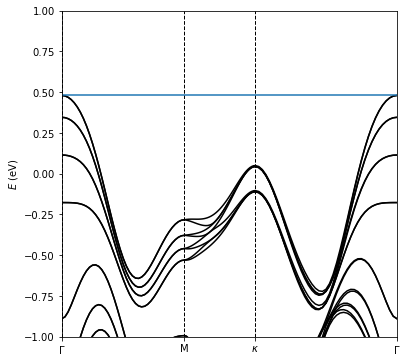

In [330]:
MoS2_ABBA_MX=Multilayer(material='MoS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,2,1])
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_ABBA_MX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_ABBA_MX.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,32])

In [331]:
check_bilayer_M1_spinful(MoS2_ABBA_MX,1,1)

0.38389741486926526

In [332]:
check_bilayer_M2_spinful(MoS2_ABBA_MX,1,1)

2.0471501066083613e-15

In [333]:
check_bilayer_TRS_spinful(MoS2_ABBA_MX,1,1)

0.0

#### XM

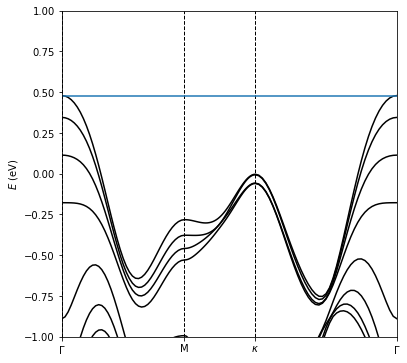

In [325]:
MoS2_ABBA_XM=Multilayer(material='MoS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,3,2])
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_ABBA_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_ABBA_XM.get_Hamiltonian_spinless)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [326]:
check_bilayer_M1_spinless(MoS2_ABBA_XM,1,1)

0.38389741486926504

In [327]:
check_bilayer_M2_spinless(MoS2_ABBA_XM,1,1)

2.0471501066083613e-15

In [328]:
check_bilayer_TRS_spinless(MoS2_ABBA_XM,1,1)

0.0

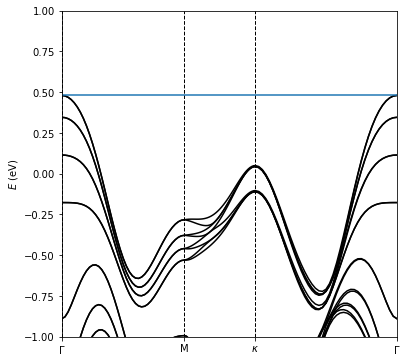

In [329]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_ABBA_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_ABBA_XM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,32])

In [365]:
check_bilayer_M1_spinful(MoS2_ABBA_XM,1,1)

0.38389741486926504

In [366]:
check_bilayer_M2_spinful(MoS2_ABBA_XM,1,1)

2.0471501066083613e-15

In [367]:
check_bilayer_TRS_spinful(MoS2_ABBA_XM,1,1)

0.0

### ABAB

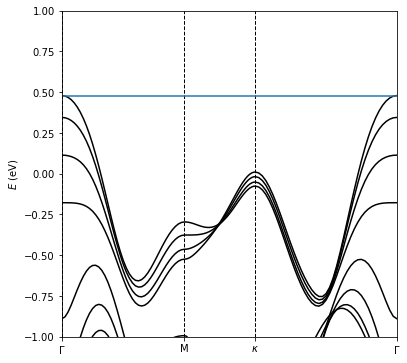

In [169]:
MoS2_ABAB=Multilayer(material='MoS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,0,180], shift_M_list=[1,0,1])
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_ABAB.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_ABAB.get_Hamiltonian_spinless)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [170]:
check_bilayer_C2x_spinless(MoS2_ABAB,1,1)

2.0471501066083613e-15

In [173]:
check_bilayer_M2_spinless(MoS2_ABAB,1,1)

2.0471501066083613e-15

In [174]:
check_bilayer_TRS_spinless(MoS2_ABAB,1,1)

0.0

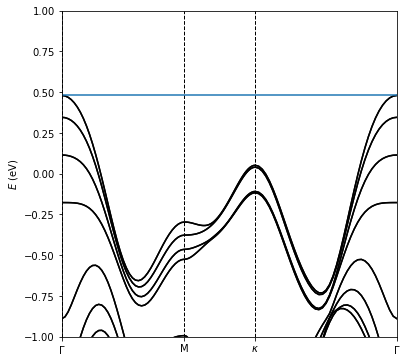

In [206]:
MoS2_ABAB=Multilayer(material='MoS2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,0,180], shift_M_list=[1,0,1])
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2_ABAB.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=MoS2_ABAB.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,32])

In [211]:
check_bilayer_C2x_spinful(MoS2_ABAB,1,1)

2.0471501066083613e-15

In [214]:
check_bilayer_M2_spinful(MoS2_ABAB,1,1)

2.0471501066083613e-15

In [215]:
check_bilayer_TRS_spinful(MoS2_ABAB,1,1)

0.0

## WSe2

### ABBA

#### MM

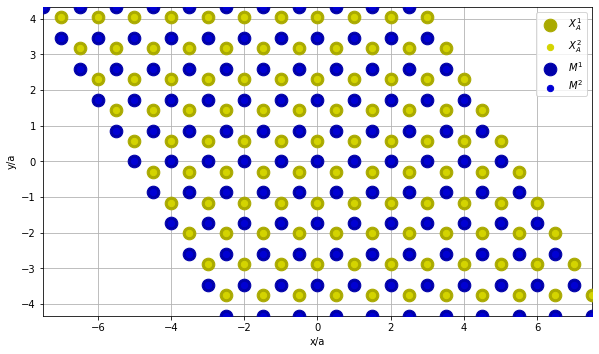

In [409]:
WSe2_ABBA_MM=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,1,0])
WSe2_ABBA_MM.plot_lattice(show_layer=[1,2],XB=False)

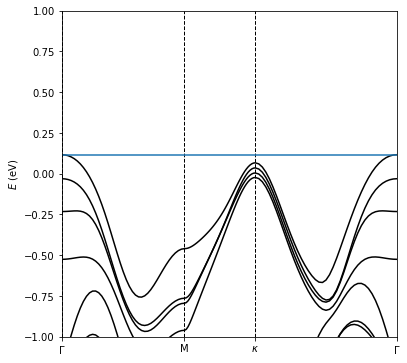

In [337]:

fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABBA_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABBA_MM.get_Hamiltonian_spinless)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [338]:
check_bilayer_M1_spinless(WSe2_ABBA_MM,1,1)

7.108895957933346e-16

In [339]:
check_bilayer_M2_spinless(WSe2_ABBA_MM,1,1)

2.112343365827712e-15

In [340]:
check_bilayer_TRS_spinless(WSe2_ABBA_MM,1,1)

0.0

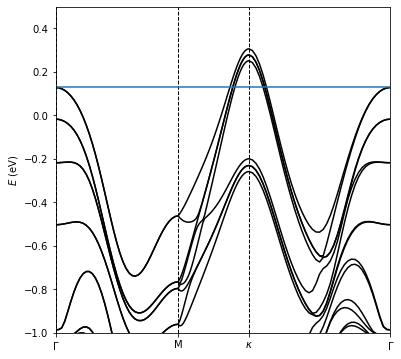

In [341]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABBA_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABBA_MM.get_Hamiltonian_spinful)
ax.set_ylim(-1,.5)
ax.axhline(y=energy_list[0,32])

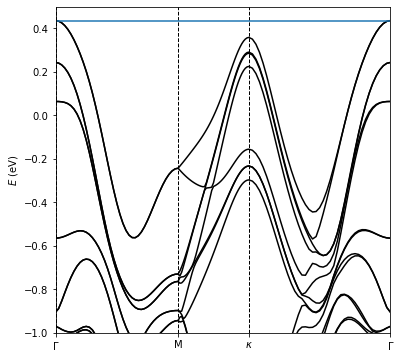

In [31]:
WSe2_ABBA=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,1,0],z_list=[6,6,6],threshold=10)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABBA.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABBA.get_Hamiltonian_spinful)
ax.set_ylim(-1,.5)
ax.axhline(y=energy_list[0,32])

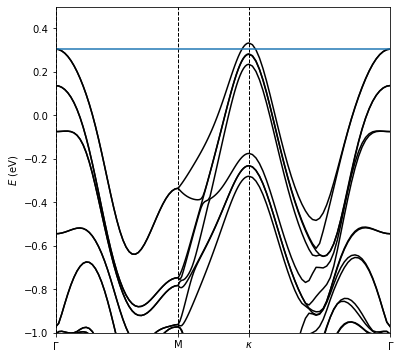

In [52]:
WSe2_ABBA=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,1,0],z_list=[6.2,6.2,6.2],threshold=10)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABBA.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABBA.get_Hamiltonian_spinful)
ax.set_ylim(-1,.5)
ax.axhline(y=energy_list[0,32])

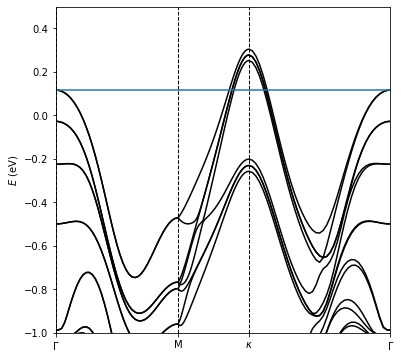

In [ ]:
WSe2_ABBA=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,1,0],z_list=[6.5,6.5,6.5],threshold=10)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABBA.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABBA.get_Hamiltonian_spinful)
ax.set_ylim(-1,.5)
ax.axhline(y=energy_list[0,32])

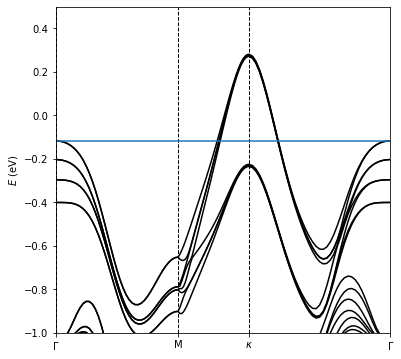

In [30]:
WSe2_ABBA=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,1,0],z_list=[7,7,7],threshold=10)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABBA.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABBA.get_Hamiltonian_spinful)
ax.set_ylim(-1,.5)
ax.axhline(y=energy_list[0,32])

In [342]:
check_bilayer_M1_spinful(WSe2_ABBA_MM,1,1)

7.108895957933346e-16

In [343]:
check_bilayer_M2_spinful(WSe2_ABBA_MM,1,1)

2.112343365827712e-15

In [344]:
check_bilayer_TRS_spinful(WSe2_ABBA_MM,1,1)

0.0

In [67]:
en_diff=[]
layer_list=np.linspace(6,7,11)
for x in layer_list:
    WSe2_ABBA=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,1,0],z_list=[x,x,x],threshold=10)

    energy_Gamma,_=get_energy(WSe2_ABBA.get_Hamiltonian_spinful(0, 0))
    energy_Kappa,_=get_energy(WSe2_ABBA.get_Hamiltonian_spinful(*WSe2_ABBA.high_symm['kappa']))

    en_diff.append(energy_Gamma[32]-energy_Kappa[32])

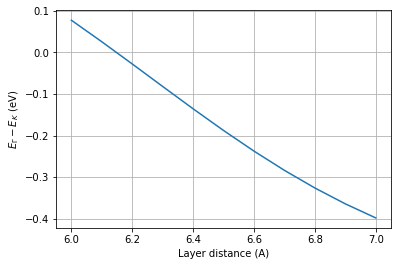

In [73]:
fig,ax=plt.subplots()
ax.plot(layer_list,en_diff)
ax.set_xlabel('Layer distance (A)')
ax.set_ylabel(r'$E_{\Gamma}-E_{K}$ (eV)')
# ax.axhline(y=0,ls='dashed',color='k')
ax.grid('on')

#### XM

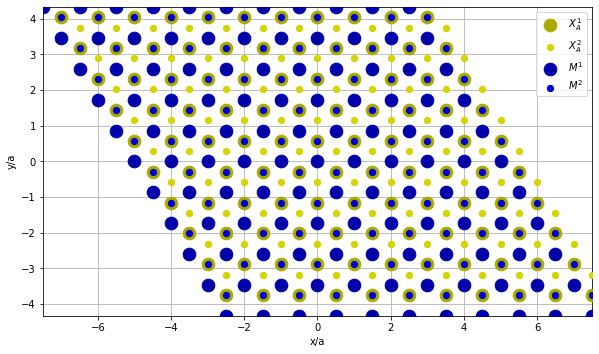

In [411]:
WSe2_ABBA_XM=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,2,1])
WSe2_ABBA_XM.plot_lattice(show_layer=[1,2],XB=False)

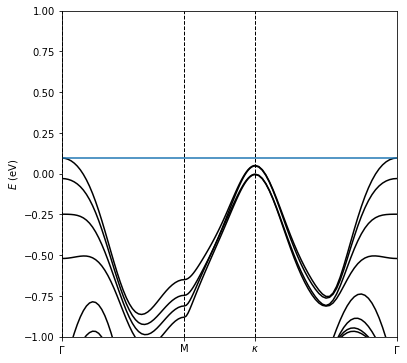

In [412]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABBA_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABBA_XM.get_Hamiltonian_spinless)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [413]:
check_bilayer_M1_spinless(WSe2_ABBA_XM,1,1)

0.4349442537815623

In [414]:
check_bilayer_M2_spinless(MoS2_ABBA_XM,1,1)

2.0471501066083613e-15

In [415]:
check_bilayer_TRS_spinless(MoS2_ABBA_XM,1,1)

0.0

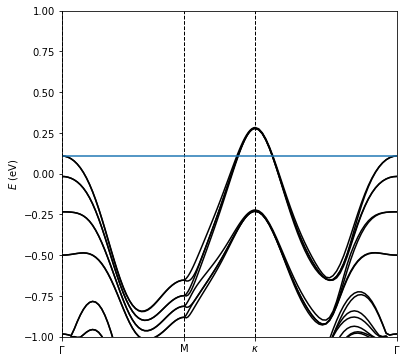

In [416]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABBA_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABBA_XM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,32])

In [417]:
check_bilayer_M1_spinful(WSe2_ABBA_XM,1,1)

0.4349442537815623

In [418]:
check_bilayer_M2_spinful(WSe2_ABBA_XM,1,1)

2.112343365827712e-15

In [419]:
check_bilayer_TRS_spinful(WSe2_ABBA_XM,1,1)

0.0

#### MX

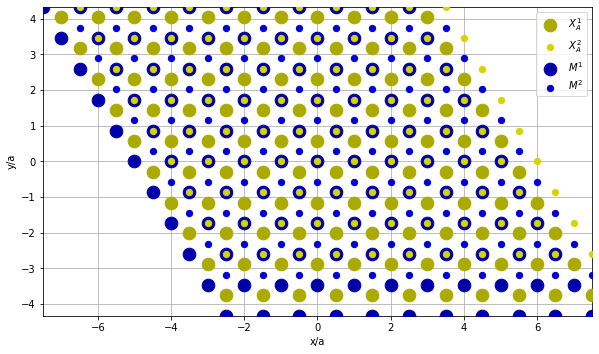

In [420]:
WSe2_ABBA_MX=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,3,2])
WSe2_ABBA_MX.plot_lattice(show_layer=[1,2],XB=False)

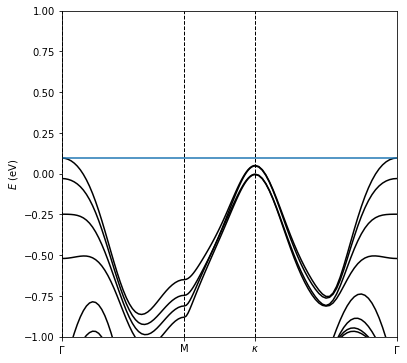

In [421]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABBA_MX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABBA_MX.get_Hamiltonian_spinless)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [354]:
check_bilayer_M1_spinless(WSe2_ABBA_MX,1,1)

0.4349442537815612

In [422]:
check_bilayer_M2_spinless(WSe2_ABBA_MX,1,1)

2.112343365827712e-15

In [423]:
check_bilayer_TRS_spinless(WSe2_ABBA_MX,1,1)

0.0

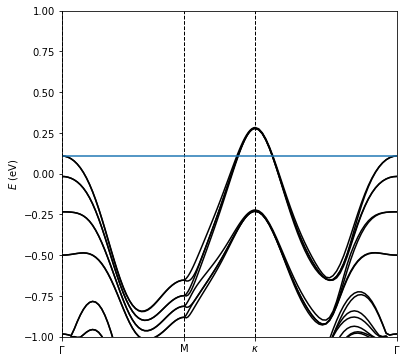

In [424]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABBA_MX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABBA_MX.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,32])

In [425]:
check_bilayer_M1_spinful(WSe2_ABBA_MX,1,1)

0.4349442537815612

In [426]:
check_bilayer_M2_spinful(WSe2_ABBA_MX,1,1)

2.112343365827712e-15

In [427]:
check_bilayer_TRS_spinful(WSe2_ABBA_MX,1,1)

0.0

### ABAB

#### XX

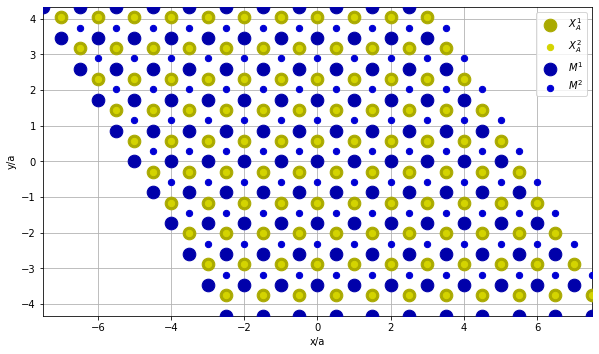

In [387]:
WSe2_ABAB_XX=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,0,180], shift_M_list=[1,1,2])
WSe2_ABAB_XX.plot_lattice(XB=False,show_layer=[1,2])

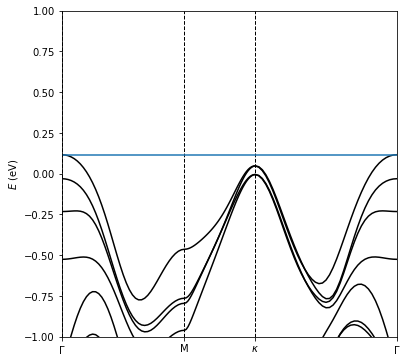

In [368]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABAB_XX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABAB_XX.get_Hamiltonian_spinless)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [370]:
check_bilayer_C2x_spinless(WSe2_ABAB_XX,1,1)

2.112343365827712e-15

In [371]:
check_bilayer_M2_spinless(WSe2_ABAB_XX,1,1)

2.112343365827712e-15

In [372]:
check_bilayer_TRS_spinless(WSe2_ABAB_XX,1,1)

0.0

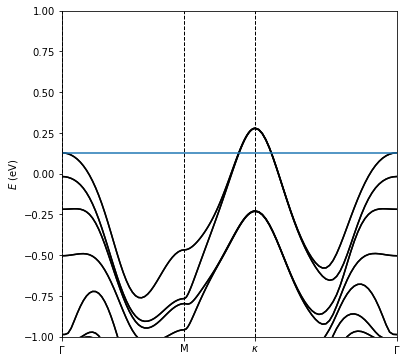

In [428]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABAB_XX.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABAB_XX.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,32])

In [382]:
check_bilayer_C2x_spinful(WSe2_ABAB_XX,1,1)

2.112343365827712e-15

In [383]:
check_bilayer_M2_spinful(WSe2_ABAB_XX,1,1)

2.112343365827712e-15

In [384]:
check_bilayer_TRS_spinful(WSe2_ABAB_XX,1,1)

0.0

#### MM

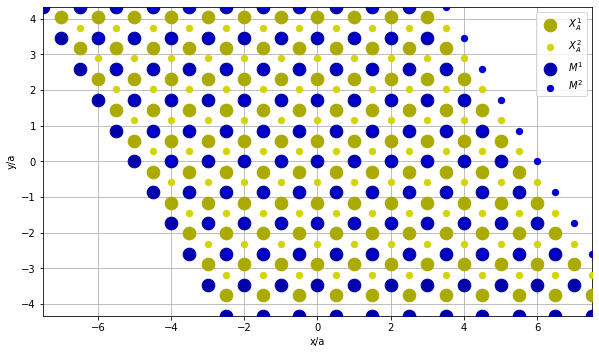

In [435]:
WSe2_ABAB_MM=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,0,180], shift_M_list=[1,2,3])
WSe2_ABAB_MM.plot_lattice(XB=False,show_layer=[1,2])

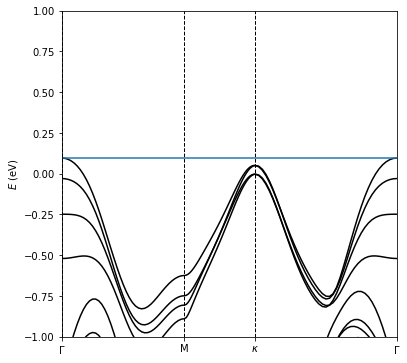

In [436]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABAB_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABAB_MM.get_Hamiltonian_spinless)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [437]:
check_bilayer_C2x_spinless(WSe2_ABAB_MM,1,1)

2.112343365827712e-15

In [391]:
check_bilayer_M2_spinless(WSe2_ABAB_MM,1,1)

2.112343365827712e-15

In [392]:
check_bilayer_TRS_spinless(WSe2_ABAB_MM,1,1)

0.0

In [440]:
energy_list[0,32]

0.10883497962296709

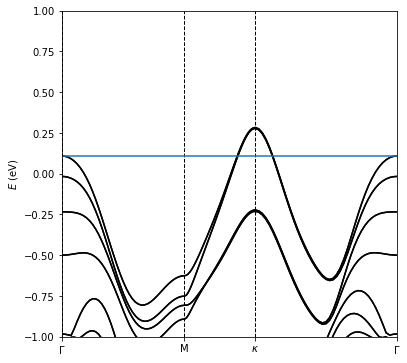

In [439]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABAB_MM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABAB_MM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,32])

In [394]:
check_bilayer_C2x_spinful(WSe2_ABAB_MM,1,1)

2.112343365827712e-15

In [395]:
check_bilayer_M2_spinful(WSe2_ABAB_MM,1,1)

2.112343365827712e-15

In [396]:
check_bilayer_TRS_spinful(WSe2_ABAB_MM,1,1)

0.0

#### XM

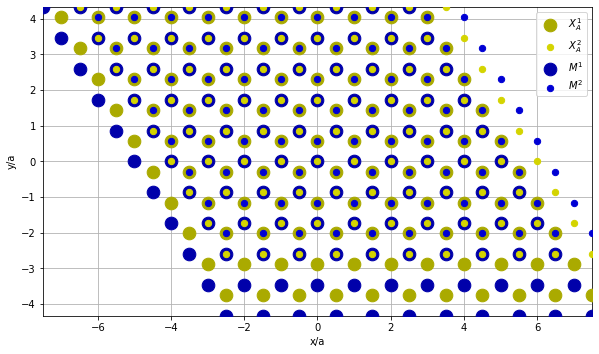

In [432]:
WSe2_ABAB_XM=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,0,180], shift_M_list=[1,3,4])
WSe2_ABAB_XM.plot_lattice(show_layer=[1,2],XB=False)

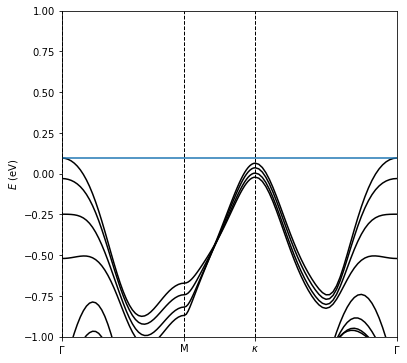

In [433]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABAB_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABAB_XM.get_Hamiltonian_spinless)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,16])

In [400]:
check_bilayer_C2x_spinless(WSe2_ABAB_XM,1,1)

2.112343365827712e-15

In [401]:
check_bilayer_M2_spinless(WSe2_ABAB_XM,1,1)

2.112343365827712e-15

In [402]:
check_bilayer_TRS_spinless(WSe2_ABAB_XM,1,1)

0.0

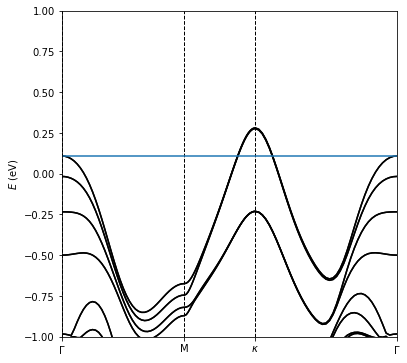

In [434]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_ABAB_XM.plot_dispersion(XM2=True,ax=ax,color='k',eff=1,func=WSe2_ABAB_XM.get_Hamiltonian_spinful)
ax.set_ylim(-1,1)
ax.axhline(y=energy_list[0,32])

In [404]:
check_bilayer_C2x_spinful(WSe2_ABAB_XM,1,1)

2.112343365827712e-15

In [405]:
check_bilayer_M2_spinful(WSe2_ABAB_XM,1,1)

2.112343365827712e-15

In [406]:
check_bilayer_TRS_spinful(WSe2_ABAB_XM,1,1)

0.0

# k p thoery

In [26]:
def energy_comp(d,stacking):
    if stacking =='XM':
        WSe2_ABBA=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,2,1],z_list=d,threshold=10)
    if stacking == 'MM':
        WSe2_ABBA=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,1,0],z_list=d,threshold=10)
    ham_Gamma=WSe2_ABBA.get_Hamiltonian_spinful(0, 0)
    ham_Kappa=WSe2_ABBA.get_Hamiltonian_spinful(*WSe2_ABBA.high_symm['kappa'])

    val_Gamma,_=get_energy(ham_Gamma)
    val_Kappa,_=get_energy(ham_Kappa)
    return val_Gamma,val_Kappa


In [40]:
d_MM_list=np.linspace(5.7,6.6,11)
d_XM_list=np.linspace(5.7,6.6,11)
val_MM_Gamma_list=np.zeros((d_MM_list.shape[0],d_XM_list.shape[0],88))
val_XM_Gamma_list=np.zeros((d_MM_list.shape[0],d_XM_list.shape[0],88))
val_MM_Kappa_list=np.zeros((d_MM_list.shape[0],d_XM_list.shape[0],88))
val_XM_Kappa_list=np.zeros((d_MM_list.shape[0],d_XM_list.shape[0],88))

# for d_AB_idx,d_AB in enumerate(d_AB_list):
#     for d_BB_idx,d_BB in enumerate(d_BB_list):
#         val_MM_Gamma_list[d_AB_idx,d_BB_idx],val_XM_Gamma_list[d_AB_idx,d_BB_idx],val_MM_Kappa_list[d_AB_idx,d_BB_idx],val_XM_Kappa_list[d_AB_idx,d_BB_idx]=energy_comp([d_AB,d_BB,d_AB])

for d_MM_idx,d_MM in enumerate(d_MM_list):
    for d_XM_idx,d_XM in enumerate(d_XM_list):
        val_MM_Gamma_list[d_MM_idx,d_XM_idx],val_MM_Kappa_list[d_MM_idx,d_XM_idx]=energy_comp([6,d_MM,6],stacking='MM')
        val_XM_Gamma_list[d_MM_idx,d_XM_idx],val_XM_Kappa_list[d_MM_idx,d_XM_idx]=energy_comp([6,d_XM,6],stacking='XM')

In [41]:
np.min(val_MM_Gamma_list[:,:,32]-val_XM_Gamma_list[:,:,32])

-0.13266639933540864

Text(0.5, 1.0, '$E_{MM}(\\Gamma)-E_{XM}(\\Gamma)$')

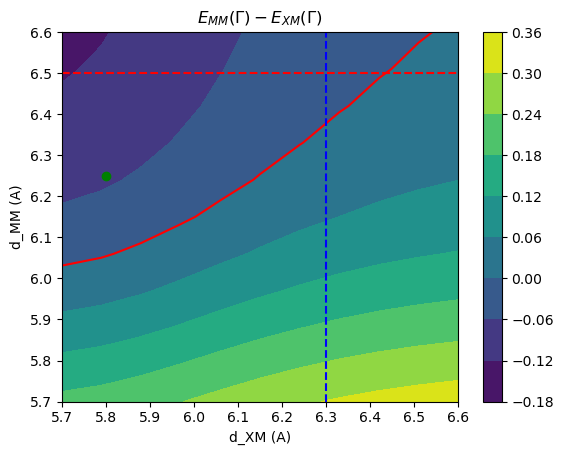

In [47]:
fig,ax=plt.subplots()
im=ax.contourf(d_XM_list,d_MM_list,val_MM_Gamma_list[:,:,32]-val_XM_Gamma_list[:,:,32],)
ax.contour(d_XM_list,d_MM_list,val_MM_Gamma_list[:,:,32]-val_XM_Gamma_list[:,:,32],levels=[0],colors='r')
plt.colorbar(im)
ax.set_xlabel('d_XM (A)')
ax.set_ylabel('d_MM (A)')
ax.axvline(x=6.3,ls='dashed',color='blue')
ax.axhline(y=6.5,ls='dashed',color='red')
ax.scatter(5.8,6.25,color='g')
ax.set_title('$E_{MM}(\Gamma)-E_{XM}(\Gamma)$')

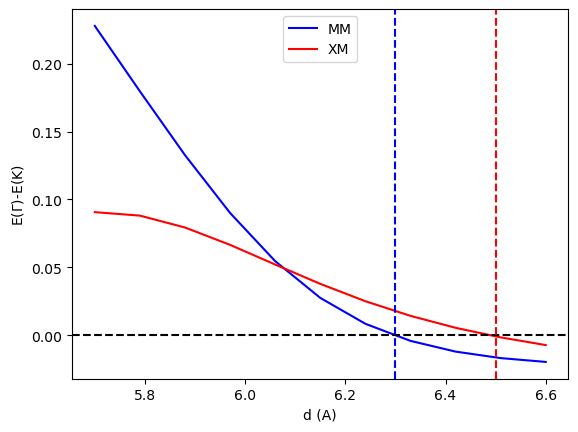

In [43]:
fig,ax=plt.subplots()
ax.plot(d_MM_list,val_MM_Gamma_list[:,0,32]-val_MM_Kappa_list[:,0,32],label='MM',color='b')
ax.plot(d_XM_list,val_XM_Gamma_list[0,:,32]-val_XM_Kappa_list[0,:,32],label='XM',color='r')

ax.set_xlabel('d (A)')
ax.set_ylabel('E($\Gamma$)-E(K)')
ax.legend()
ax.axhline(y=0,ls='dashed',color='k')
ax.axvline(x=6.3,ls='dashed',color='blue')
ax.axvline(x=6.5,ls='dashed',color='red')

[Text(0.5, 1.0, 'MM'), Text(0.5, 1.0, 'XM')]

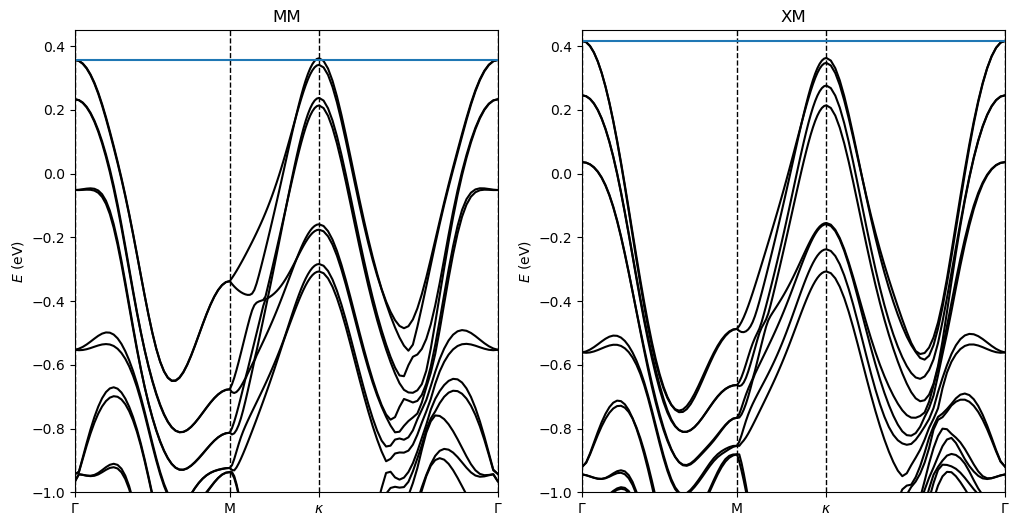

In [11]:
WSe2_ABBA_MM=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,1,0],z_list=[6,6.25,6],offset_list=[x*5e-2 for x in [3/2,1/2,-1/2,-3/2]])
WSe2_ABBA_XM=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,2,1],z_list=[6,5.8,6],offset_list=[x*5e-2 for x in [3/2,1/2,-1/2,-3/2]])

fig,ax=plt.subplots(1,2,figsize=(12,6))
energy_list_MM=WSe2_ABBA_MM.plot_dispersion(XM2=True,ax=ax[0],color='k',eff=1,func=WSe2_ABBA_MM.get_Hamiltonian_spinful)
ax[0].axhline(y=energy_list_MM[0,32])

energy_list_XM=WSe2_ABBA_XM.plot_dispersion(XM2=True,ax=ax[1],color='k',eff=1,func=WSe2_ABBA_XM.get_Hamiltonian_spinful)
ax[1].axhline(y=energy_list_XM[0,32])
[ax.set_ylim(-1,.45) for ax in ax]
[ax.set_title(text) for ax,text in zip(ax,['MM','XM'])]

In [12]:
pd.DataFrame({'MM Gamma':energy_list_MM[0,32:40:2],'XM Gamma':energy_list_XM[0,32:40:2],'MM Kappa':energy_list_MM[80,32:40:2],'XM Kappa':energy_list_XM[80,32:40:2]})

MM Gamma  XM Gamma  MM Kappa  XM Kappa
0  0.356853  0.416696  0.362102  0.363141
1  0.233379  0.245787  0.237797  0.276521
2 -0.051420  0.036141 -0.158904 -0.154871
3 -0.552829 -0.561136 -0.283532 -0.237387

In [13]:
pd.DataFrame({'MM Gamma':energy_list_MM[0,32:40:2],'XM Gamma':energy_list_XM[0,32:40:2],'MM Kappa':energy_list_MM[80,32:40:2],'XM Kappa':energy_list_XM[80,32:40:2]})

MM Gamma  XM Gamma  MM Kappa  XM Kappa
0  0.356853  0.416696  0.362102  0.363141
1  0.233379  0.245787  0.237797  0.276521
2 -0.051420  0.036141 -0.158904 -0.154871
3 -0.552829 -0.561136 -0.283532 -0.237387

In [14]:
pd.DataFrame({'MM':energy_list_MM[0,32:40:2],'XM':energy_list_XM[0,32:40:2]})

MM        XM
0  0.356853  0.416696
1  0.233379  0.245787
2 -0.051420  0.036141
3 -0.552829 -0.561136

In [15]:
energy_list_MM[0,32]-energy_list_XM[0,32]

-0.05984265875353495

In [572]:
energy_list_MM[0,32]-energy_list_MM[80,32]

0.0065422183902248965

In [573]:
energy_list_XM[0,32]-energy_list_XM[80,32]

0.08704646150777329

In [46]:
from scipy.optimize import least_squares

In [43]:
def func(x,rhs):
    V1_0,V2_0,V2_1,phi2,Tm_0,Tp_0,Tp_1=x
    V1_1,phi1,Tm_1=0,0,0
    kind_dict={'MM':0,'XM':4*np.pi/3}
    eq=[]
    for key,kind in kind_dict.items():
        Vb1=V1_0+V1_1*6*np.cos(kind+phi1)
        Vb2=V2_0+V2_1*6*np.cos(kind+phi2)
        Vt1=V1_0+V1_1*6*np.cos(kind-phi1)
        Vt2=V2_0+V2_1*6*np.cos(kind-phi2)
        Tm=Tm_0+Tm_1*6*np.cos(kind)
        Tp=Tp_0+Tp_1*6*np.cos(kind)
        diag=np.diag([Vb1,Vb2,Vt2,Vt1])
        offdiag=np.diag([Tm,Tp,Tm],k=1)+np.diag([Tm,Tp,Tm],k=-1)
        mat=diag+offdiag
        val=np.linalg.eigvals(mat)
        val=np.sort(val)[::-1] # descending order
        eq.append(val-rhs[key])
    return np.hstack(eq)
    # return (eq)


In [17]:
def func_2(x,rhs):
    V1_0,V2_0,V2_1,phi2,Tm_0,Tm_1,Tp_0,Tp_1=x
    V1_1,phi1=0,0
    kind_dict={'MM':0,'XM':4*np.pi/3}
    eq=[]
    for key,kind in kind_dict.items():
        Vb1=V1_0+V1_1*6*np.cos(kind+phi1)
        Vb2=V2_0+V2_1*6*np.cos(kind+phi2)
        Vt1=V1_0+V1_1*6*np.cos(kind-phi1)
        Vt2=V2_0+V2_1*6*np.cos(kind-phi2)
        Tm=Tm_0+Tm_1*6*np.cos(kind)
        Tp=Tp_0+Tp_1*6*np.cos(kind)
        diag=np.diag([Vb1,Vb2,Vt2,Vt1])
        offdiag=np.diag([Tm,Tp,Tm],k=1)+np.diag([Tm,Tp,Tm],k=-1)
        mat=diag+offdiag
        val=np.linalg.eigvals(mat)
        val=np.sort(val)[::-1] # descending order
        eq.append(val-rhs[key])
    return np.hstack(eq)
    # return (eq)


In [18]:
energy_list_XM[0,32:40:2],energy_list_MM[0,32:40:2]

(array([ 0.416696  ,  0.24578728,  0.03614106, -0.56113552]),
 array([ 0.35685334,  0.23337887, -0.05142022, -0.55282948]))

In [19]:
valence_energy={'MM':energy_list_MM[0,32:40:2],'XM':energy_list_XM[0,32:40:2]}
valence_0={'MM':0*energy_list_MM[0,32:40:2],'XM':0*energy_list_XM[0,32:40:2]}


In [44]:
res_1=least_squares(lambda x: func(x,rhs=valence_energy),x0=[.1,.1,.01,0,.1,.1,.01],)
# bounds=([-1,-1,0,-1,-1,0,-1,0,-1,-1],[1,1,np.pi,-1,-1,0,1,0,1,1])

In [911]:
res_2=fsolve(lambda x: func_2(x,rhs=valence_energy),x0=[.1,.1,.01,0,.1,0.01,.1,.01],)
# bounds=([-1,-1,0,-1,-1,0,-1,0,-1,-1],[1,1,np.pi,-1,-1,0,1,0,1,1])

In [45]:
res_1.cost

0.00012804737945531196

In [908]:
res_1.x

array([ 0.20025978, -0.15918337, -0.00858256, -0.17636353,  0.18420718,
        0.35674912, -0.00970301])

In [ ]:
res_1.x

array([-0.08960117, -0.08337232, -0.00096439, -0.75810343,  0.157044  ,
        0.38950095, -0.00105308])

In [302]:
res_1.x

array([-8.40720527e-02,  7.58346976e-02,  1.58298878e+00, -8.88969824e-02,
        2.21354776e-04,  1.32426212e-02,  1.55770259e-01,  2.55013038e-04,
        1.18856041e-01,  4.40281703e-02])

In [344]:
func(res_1.x,valence_0)

array([ 0.35151811, -0.03323215, -0.14551081, -0.52712554,  0.36558558,
       -0.03359419, -0.14378293, -0.52995374])

In [583]:
valence_energy

{'MM': array([ 0.3411115 ,  0.24437328, -0.05032087, -0.55337819]),
 'XM': array([ 0.41008047,  0.2428302 ,  0.04296905, -0.56405639])}

In [427]:
np.sum(np.abs(func(res_1.x*np.array([.6,1,1,1,1,1,1]),valence_energy))**2)/2

0.002059545169178256

In [38]:
def binary_search(i,x0,target,ub=True,thres=.001):
    if ub:
        x_min,x_max=1,2
    else:
        x_min,x_max=.5,1
    factor=np.array([1.]*7,dtype=float)
    while x_max/x_min-1>thres:
        x_mid=(x_min+x_max)/2
        factor_mid=np.copy(factor)
        factor_mid[i]=x_mid
        new_error=np.sum(np.abs(func(x0*(factor_mid),valence_energy))**2)/2
        if new_error>2*target:
            if ub:
                x_max=x_mid
            else:
                x_min=x_mid
        else:
            if ub:
                x_min=x_mid
            else:
                x_max=x_mid
    return x_mid

In [39]:
def estimate_accuracy(x0):
    err=np.sum(np.abs(func(x0*np.array([1,1,1,1,1,1,1]),valence_energy))**2)/2

    ub_list=[]
    lb_list=[]
    for i in range(7):
        ub_list.append(binary_search(i,target=err,x0=x0,ub=True))
        lb_list.append(binary_search(i,target=err,x0=x0,ub=False))
    return lb_list,ub_list

In [40]:
lb_list,ub_list=estimate_accuracy(res_1.x)

In [ ]:
ub_list

[1.0185546875,
 1.0224609375,
 1.0927734375,
 1.998046875,
 1.0166015625,
 1.0107421875,
 1.0810546875]

In [ ]:
pd.DataFrame({'Lower Bound':res_1.x*lb_list,'x':res_1.x,'Upper Bound':res_1.x*ub_list},index=['V1 (eV)','V2_0 (eV)','V2_1 (eV)','phi2 (rad)','T12 (eV)','T23_0 (eV)','T23_1 (eV)'])  

Lower Bound         x  Upper Bound
V1 (eV)        0.196544  0.200260     0.203976
V2_0 (eV)     -0.155608 -0.159183    -0.162759
V2_1 (eV)     -0.007782 -0.008583    -0.009379
phi2 (rad)    -0.088268 -0.176364    -0.352383
T12 (eV)       0.181149  0.184207     0.187265
T23_0 (eV)     0.352917  0.356749     0.360581
T23_1 (eV)    -0.008921 -0.009703    -0.010489

In [916]:
pd.DataFrame({'x':res_2,},index=['V1 (eV)','V2_0 (eV)','V2_1 (eV)','phi2 (rad)','T12_0 (eV)','T12_1 (eV)','T23_0 (eV)','T23_1 (eV)'])  

x
V1 (eV)     2.006868e-01
V2_0 (eV)  -1.601055e-01
V2_1 (eV)  -4.561648e-02
phi2 (rad)  8.601799e+06
T12_0 (eV)  1.828124e-01
T12_1 (eV)  5.955138e-04
T23_0 (eV)  3.067212e-01
T23_1 (eV) -1.401813e-03

In [ ]:
pd.DataFrame({'Lower Bound':res_1.x*lb_list,'x':res_1.x,'Upper Bound':res_1.x*ub_list},index=['V1 (eV)','V2_0 (eV)','V2_1 (eV)','phi2 (rad)','T12 (eV)','T23_0 (eV)','T23_1 (eV)'])  

Lower Bound         x  Upper Bound
V1 (eV)        0.199673  0.200260     0.200846
V2_0 (eV)     -0.158717 -0.159183    -0.159650
V2_1 (eV)     -0.008050 -0.008583    -0.009111
phi2 (rad)    -0.160604 -0.176364    -0.191003
T12 (eV)       0.184027  0.184207     0.184387
T23_0 (eV)     0.356401  0.356749     0.357098
T23_1 (eV)    -0.009300 -0.009703    -0.010110

In [350]:
np.cos(0.758)*2

1.4524248060820526

In [560]:
m=np.diag([-89.6,-83.3,-83.3,-89.6])+np.diag([157,389,157],k=1)+np.diag([157,389,157],k=-1)

In [562]:
sorted(np.linalg.eigvals(m))

[-528.465297507043, -144.3673577628924, -33.43470249295702, 360.46735776289245]

# 2 Layer k.p

In [694]:
WSe2_ABBA_MM=Multilayer(material='WSe2', data_TB=data_TB, data_lattice=data_lattice, data_interlayer=data_interlayer, data_SOC=data_SOC, theta_list=[180,180,0], shift_M_list=[1,1,0],z_list=[6,6.25,6])

In [695]:
ham=WSe2_ABBA_MM.get_Hamiltonian_spinful(0, 0)

In [696]:
val,vec=get_energy(ham)

In [697]:
val[32:36]

array([0.3411115 , 0.3411115 , 0.24437328, 0.24437328])

In [698]:
np.sum(np.abs(vec[:,32].reshape((4,-1)))**2,axis=1)

array([0.13165248, 0.36834752, 0.36834752, 0.13165248])

In [699]:
np.sum(np.abs(vec[:,34].reshape((4,-1)))**2,axis=1)

array([0.26794114, 0.23205886, 0.23205886, 0.26794114])

In [700]:
np.sum(np.abs(vec[:,36].reshape((4,-1)))**2,axis=1)

array([0.2574932, 0.2425068, 0.2425068, 0.2574932])

In [701]:
np.sum(np.abs(vec[:,38].reshape((4,-1)))**2,axis=1)

array([0.27455255, 0.22544745, 0.22544745, 0.27455255])

# 4 Layer k.p

In [9]:
def convert_params(x):
    return {'V1':x[0]*1e3,'V2_0':x[1]*1e3,'V2_1':x[2]*1e3,'phi2':x[3],'Tm':x[4]*1e3,'Tp_0':x[5]*1e3,'Tp_1':x[6]*1e3,}

In [18]:
%%writefile four_layer.py
from pathlib import Path
import pandas as pd
import numpy as np
path_A = Path('lattice_exp.csv')
path_B = Path('/mnt/d/Cornell/ABBA/lattice_exp.csv')
path= path_A if path_A.exists() else path_B
data_lattice=pd.read_csv(path,delimiter=' ',)
data_lattice=data_lattice.set_index('Angstrom')
class Params:
    def __init__(self,a=data_lattice['WSe2']['a'],m=1.2, theta=3, Tm=157,Tp_0=389,Tp_1=-1,V1=-89.6,V2_0=-83.3,V2_1=-1,phi2=-0.758,Ez=0,Nmax=2,n=15,B=0):
        self.m=m
        self.a=a
        self.theta=deg2rad(theta)   
        self.Tm=Tm
        self.Tp_0=Tp_0
        self.Tp_1=Tp_1
        self.V1=V1
        self.V2_0=V2_0
        self.V2_1=V2_1
        self.phi2=phi2
        self.Ez=Ez
        self.Nmax=Nmax
        self.hbar2=(1.05457182e-34)**2/(9.1e-31)/(1e-10)**2/1.602e-19*1e3
        self.aM=self.a/(self.theta)  # amstrong
        # conventional def
        self.aM1=self.aM*np.array([np.cos(deg2rad(-30)),np.sin(deg2rad(-30))])
        self.aM2=self.aM*np.array([np.cos(deg2rad(30)),np.sin(deg2rad(30))])

        self.bM=4*np.pi/(np.sqrt(3)*self.aM)    # 1/amstrong
        self.g=[np.array([np.cos(deg2rad(x)),np.sin(deg2rad(x))])*self.bM for x in np.arange(6)*60]
        self.bM1=self.g[5]
        self.bM2=self.g[1]
        self.bM3=self.g[3]

        self.g_idx=np.array(self.g)@np.linalg.inv(np.array([self.bM1,self.bM2]))

        self.bM1_idx=self.g_idx[5]
        self.bM2_idx=self.g_idx[1]
        self.bM3_idx=self.g_idx[3]
        self.G=np.array([self.bM1,self.bM2,self.bM3])

        self.n=n

        self.neighbor_index=generate_shell(self.Nmax)
        self.h1index=self.neighbor_index[:,0]
        self.h2index=self.neighbor_index[:,1]

        self.G_idx=np.array([self.bM1_idx,self.bM2_idx,self.bM3_idx])
        self.G_m_idx=-self.G_idx
        h1matX,h1matY,h2matX,h2matY=self._get_h()
        self.Tmmat=self._T(h1matX-h1matY,h2matX-h2matY,layer='-')
        self.TmTmat=self.Tmmat.T.conj() # TRS ensures the hermicity
        self.Tpmat=self._T(h1matX-h1matY,h2matX-h2matY,layer='+')
        self.TpTmat=self.Tpmat.T.conj() # TRS ensures the hermicity
        self.Vb1mat=self._V(h1matX-h1matY,h2matX-h2matY,layer=1)
        self.Vb2mat=self._V(h1matX-h1matY,h2matX-h2matY,layer=2)
        self.Vb3mat=self._V(h1matX-h1matY,h2matX-h2matY,layer=3)
        self.Vb4mat=self._V(h1matX-h1matY,h2matX-h2matY,layer=4)
        self.high_symm=self._generate_high_symm()
        mu_B,g=5.78e-5,10
        self.Vz=g*mu_B*B*1e3

    def _generate_high_symm(self):
        K_=(self.bM1+2*self.bM2)/3
        Kp_=(-self.bM1+self.bM2)/3
        M_=self.bM2/2
        G_=0*self.bM1

        G_M_K_G=[G_,M_,K_,G_]
        K_M_Kp_G=[K_,M_,Kp_,G_]

        G_M_K_G_kx,G_M_K_G_ky=_interpolate_path(G_M_K_G,self.n)
        K_M_Kp_G_kx,K_M_Kp_G_ky=_interpolate_path(K_M_Kp_G,self.n)
        
        G_M_K_G_dist=np.r_[0,np.cumsum(np.sqrt(np.diff(G_M_K_G_kx)**2+np.diff(G_M_K_G_ky)**2))]

        K_M_Kp_G_dist=np.r_[0,np.cumsum(np.sqrt(np.diff(K_M_Kp_G_kx)**2+np.diff(K_M_Kp_G_ky)**2))]

        G_M_K_G_name={G_M_K_G_dist[idx*self.n]:n for idx,n in enumerate([r'$\Gamma$',r'M',r'$\kappa$',r'$\Gamma$'])}

        K_M_Kp_G_name={K_M_Kp_G_dist[idx*self.n]:n for idx,n in enumerate([r'$\kappa$',r'M',r'$\kappa^\prime$',r'$\Gamma$'])}

        nshell=int(self.n)
        u_index=generate_shell(nshell)/nshell
        k_hex=u_index@np.array([self.bM1,self.bM2])/np.sqrt(3)@_rotate(deg2rad(30))

        ux,uy=np.mgrid[0:self.n,0:self.n]
        u_index=np.c_[ux.flatten()/self.n,uy.flatten()/self.n]
        k_diamond=u_index@np.array([self.bM1,self.bM2])
        
        return {'kappa':K_,'M':M_,'Gamma':G_,'kappa_p':Kp_,
        'G_M_K_G':(G_M_K_G_kx,G_M_K_G_ky),'G_M_K_G_dist':G_M_K_G_dist,'G_M_K_G_name':G_M_K_G_name,
        'K_M_Kp_G':(K_M_Kp_G_kx,K_M_Kp_G_ky),'K_M_Kp_G_dist':K_M_Kp_G_dist,'K_M_Kp_G_name':K_M_Kp_G_name,
        'hex':k_hex,'diamond':k_diamond,
        }

    def _get_h(self):
        h1matX,h1matY=np.meshgrid(self.h1index,self.h1index,indexing='ij')
        h2matX,h2matY=np.meshgrid(self.h2index,self.h2index,indexing='ij')
        return h1matX,h1matY,h2matX,h2matY

    def _T(self,h1,h2,layer):
        '''
        layer: + Tp
        layer: - Tm
        '''

        # h1,h2=h1*self.t,h2*self.t
        if layer=='-':
            w0_sum=self.Tm*(np.isclose(h1,0)*np.isclose(h2,0))
            return w0_sum
        else:
            w0_sum=self.Tp_0*(np.isclose(h1,0)*np.isclose(h2,0))
            w1_sum=self.Tp_1*(np.sum([np.isclose(h1,idx[0])*np.isclose(h2,idx[1]) for idx in np.vstack([self.G_idx,self.G_m_idx])],axis=0))
            return w0_sum+w1_sum

    def _V(self,h1,h2,layer):
        '''
        l=+1: bottom layer
        l=-1: top layer
        t=+1/-1: TRS
        '''
        # h1,h2=h1*self.t,h2*self.t
        phi=self.phi2
        l=1 if layer<=2 else -1
        if layer==1 or layer==4:
            return self.V1*(np.isclose(h1,0)*np.isclose(h2,0))
        else:
            return self.V2_0*(np.isclose(h1,0)*np.isclose(h2,0)) +         self.V2_1*(
            np.exp(-1j*phi*l)*np.sum([np.isclose(h1,idx[0])*np.isclose(h2,idx[1]) for idx in self.G_idx],axis=0)
        +np.exp(1j*phi*l)*np.sum([np.isclose(h1,idx[0])*np.isclose(h2,idx[1]) for idx in self.G_m_idx],axis=0)
        )

    def energy_bonding(self,kx,ky):
        klist=np.c_[kx,ky]+self.h1index[:,np.newaxis]*self.bM1+self.h2index[:,np.newaxis]*self.bM2
        H=-self.hbar2/(2*self.m)*np.diag(np.sum(klist*klist,axis=1))
        return H
        
    def energy_single(self,kx,ky):
        # kblist=np.c_[kx,ky]+self.h1index[:,np.newaxis]*self.bM1+self.h2index[:,np.newaxis]*self.bM2
        # ktlist=kblist
        # kblist=kblist*self.t
        # ktlist=ktlist*self.t
        # kblist[:,0]=self.C2y*kblist[:,0]
        # ktlist[:,0]=self.C2y*ktlist[:,0]
        T=self.energy_bonding(kx,ky)

        H11=T+self.Ez*3/2*np.eye(T.shape[0])+self.Vb1mat
        H22=T+self.Ez*1/2*np.eye(T.shape[0])+self.Vb2mat
        H33=T-self.Ez*1/2*np.eye(T.shape[0])+self.Vb3mat
        H44=T-self.Ez*3/2*np.eye(T.shape[0])+self.Vb4mat
        H12=self.Tmmat
        H21=self.TmTmat
        H23=self.Tpmat
        H32=self.TpTmat
        H34=self.TmTmat
        H43=self.TmTmat
        zeros=np.zeros((T.shape[0],T.shape[0]))
        H=np.block([[H11,H12,zeros,zeros],
                    [H21,H22,H23,zeros],
                    [zeros,H32,H33,H34],
                    [zeros,zeros,H43,H44]])
        H=np.kron(np.eye(2),H)+self.Vz*np.kron(np.array([[0,1],[1,0]]),np.eye(H.shape[0]))

        val,vec=np.linalg.eigh(H)
        vec=self._correct_T(vec)
        return val[::-1],vec[:,::-1],H
    def _correct_T(self,vec,phase=None):
        '''
        Correct U(1) for TRS, because Gamma is always at the center
        '''
        if phase is None:
            phase=np.angle(vec[self.h1index.shape[0]//2,:])
        return vec@np.diag(np.exp(-1j*phase))
    def plot_dispersion(self,ax=None,k=10,line='G_M_K_G',color='k'):
        '''
        take 10 maximal band
        '''
        assert line in {'G_M_K_G','K_M_Kp_G'}, 'line should be "K_M_Kp_G" or "G_M_K_G"'
        energy_list=[]
        for kx,ky in zip(*self.high_symm[line]):
            val,vec,_=self.energy_single(kx, ky)
            energy_list.append(val)
        
        energy_list=np.array(energy_list)
        if ax is not False:
            if ax is None:
                fig,ax=plt.subplots(figsize=(4,4/self.aM1[0]*self.aM2[1]))
            ax.plot(self.high_symm[line+'_dist'],energy_list[:,:k],color=color)

            xticks,xticklabels=[],[]
            for pos,name in self.high_symm[line+'_name'].items():
                ax.axvline(x=pos,ls='dashed',color='k',lw=1)
                xticks.append(pos)
                xticklabels.append(name)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels)

            ax.set_ylabel(r'$E$ (meV)')
            ax.set_xlim(self.high_symm[line+'_dist'][[0,-1]])
            # ax.set_ylim(energy_list[:,k].min(),energy_list[:,0].max()) 

        return energy_list
    #plot_bandstructure
    #LDOS_r
    #plot_LDOS


    def u(self,vec,rx,ry):
        expo=np.exp(1j*(np.c_[self.h1index,self.h2index]@np.array([self.bM1,self.bM2]))@np.c_[rx,ry].T)
        vec1=vec[:vec.shape[0]//4]
        vec2=vec[vec.shape[0]//4:vec.shape[0]//2]
        vec3=vec[vec.shape[0]//2:3*vec.shape[0]//4]
        vec4=vec[3*vec.shape[0]//4:]
        u1=vec1@expo
        u2=vec2@expo
        u3=vec3@expo
        u4=vec4@expo
        return u1,u2,u3,u4

    def psi(self,vec,rx,ry,kx,ky):
        expo=np.exp(1j*(np.c_[self.h1index,self.h2index]@np.array([self.bM1,self.bM2])+np.array([kx,ky]))@np.c_[rx,ry].T)
        vec1=vec[:vec.shape[0]//4]
        vec2=vec[vec.shape[0]//4:vec.shape[0]//2]
        vec3=vec[vec.shape[0]//2:3*vec.shape[0]//4]
        vec4=vec[3*vec.shape[0]//4:]
        psi1=vec1@expo
        psi2=vec2@expo
        psi3=vec3@expo
        psi4=vec4@expo
        return psi1,psi2,psi3,psi4

    def plot_lattice(self,nshell,ax=None):
        line_1=np.array([[0,0],self.aM1])/self.aM
        line_2=np.array([[0,0],self.aM2])/self.aM
        line_3=np.array([[0,0],-self.aM1+self.aM2])/self.aM
        if ax is None:
            fig,ax=plt.subplots()
        neighbor_list=generate_shell(nshell)
        for h1,h2 in neighbor_list:
            for line in [line_1,line_2,line_3]:
                line=line+h1*self.aM1/self.aM+h2*self.aM2/self.aM
                ax.plot(*(line.T),lw=1,color='k')

    def plot_psi(self,kx,ky,state,ax=None,resolution=50):
        rx_list=np.linspace(-self.aM1[0],self.aM1[0],resolution+1)
        ry_list=np.linspace(-2*self.aM2[1],2*self.aM2[1],resolution+1)
        rx_mat,ry_mat=np.meshgrid(rx_list,ry_list)

        val,vec,_=self.energy_single(kx,ky)

        psi1,psi2,psi3,psi4=self.psi(vec[:,state],rx_mat.flatten(),ry_mat.flatten(),kx,ky)
        psi1_2=np.abs(psi1.reshape(rx_mat.shape))**2
        psi2_2=np.abs(psi2.reshape(rx_mat.shape))**2
        psi3_2=np.abs(psi3.reshape(rx_mat.shape))**2
        psi4_2=np.abs(psi4.reshape(rx_mat.shape))**2
        psi1_arg=np.angle(psi1.reshape(rx_mat.shape))
        psi2_arg=np.angle(psi2.reshape(rx_mat.shape))
        psi3_arg=np.angle(psi3.reshape(rx_mat.shape))
        psi4_arg=np.angle(psi4.reshape(rx_mat.shape))

        if ax is None:
            k=0.03
            fig,ax=plt.subplots(2,4,figsize=(k*(rx_list[-1]-rx_list[0])*(4+0.2*3),k*(ry_list[-1]-ry_list[0])*(2+0.2)),gridspec_kw=dict(wspace=0.2,hspace=0.2))
        [self.plot_lattice(nshell=2,ax=ax) for ax in ax.flatten()]
        im_abs=[ax.pcolormesh(rx_list/self.aM,ry_list/self.aM,psi,cmap='Blues',shading='auto',vmin=0) for ax,psi in zip(ax[0],[psi1_2,psi2_2,psi3_2,psi4_2])]
        im_arg=[ax.pcolormesh(rx_list/self.aM,ry_list/self.aM,psi,cmap='hsv',shading='auto',vmin=-np.pi,vmax=np.pi) for ax,psi in zip(ax[1],[psi1_arg,psi2_arg,psi3_arg,psi4_arg])]


        [ax.set_xlabel('$x/|a_M|$') for ax in ax[1]]
        [ax.set_ylabel('$y/|a_M|$') for ax in ax[:,0]]
        [ax.set_xticklabels([]) for ax in ax[0]]
 
        axins=[ax.inset_axes([.5,1.05,.5,.05],transform=ax.transAxes) for ax in ax.flatten()]
        cb=[plt.colorbar(im,cax=axins,orientation='horizontal') for im,axins in zip(im_abs+im_arg,axins)]

        [axins.xaxis.set_label_position('top') for axins in axins]
        [axins.xaxis.set_ticks_position('top') for axins in axins]
        [axins.xaxis.set_tick_params(pad=0) for axins in axins]
        [ax.text(0,1.02,r'$|\psi_k^{{({})}}(r)|^2$'.format(layer),transform=ax.transAxes) for layer,ax in zip('1234',ax[0])]
        [ax.text(0,1.02,r'Arg($\psi_k^{{({})}}(r)$)'.format(layer),transform=ax.transAxes) for layer,ax in zip('1234',ax[1])]
        [ax.set_xlim(rx_list[0]/self.aM,rx_list[-1]/self.aM) for ax in ax.flatten()]
        [ax.set_ylim(ry_list[0]/self.aM,ry_list[-1]/self.aM) for ax in ax.flatten()]
        return psi1,psi2,psi3,psi4

        # return psib2,psit2,psib_arg,psit_arg,rx_mat,ry_mat

    def plot_bandstructure(self,state,ax=None,bz='hex',vH=None,FS=['dashed','dashed'],FS_shift=[0.02,0.02]):
        if not hasattr(self, 'energy_list'):
            energy_list=[]
            for kx,ky in (self.high_symm[bz]):
                val,vec,_=self.energy_single(kx, ky)
                energy_list.append(val)
            energy_list=np.array(energy_list)
            self.energy_list=energy_list
        else:
            energy_list=self.energy_list


        if bz=='hex':
            l,r,b,t=-params.high_symm['kappa'][0],params.high_symm['kappa'][0],-params.high_symm['kappa_p'][1],params.high_symm['kappa_p'][1]
        elif bz=='diamond':
            l,r,b,t=0,2*params.bM2[0],-params.bM2[1],params.bM2[1]
        if ax is not False:
            if ax is None:
                fig,ax=plt.subplots(figsize=(4,4*(t-b)/(r-l)))
            energy_list_bz=energy_list[:,state]
            if vH is not None:
                levels=np.r_[np.linspace(energy_list_bz.min()+FS_shift[0],energy_list_bz.max()-FS_shift[1],2),vH]
                ls=np.array([FS[0]]+[FS[-1]]+['dotted'])
                colors=np.array(['r','r','k'])
            else:
                levels=np.linspace(energy_list_bz.min()+FS_shift[0],energy_list_bz.max()-FS_shift[1],2)
                # levels=np.linspace(energy_list_bz.min()*1.1,energy_list_bz.max()*.9,2)
                ls=np.array([FS[0]]+[FS[-1]])
                colors=np.array(['r','r'])
            ls=ls[levels.argsort()]
            colors=colors[levels.argsort()]
            levels=np.sort(levels)

            im=ax.tripcolor(*(self.high_symm[bz].T/self.bM),energy_list_bz,cmap='Blues')
            ax.tricontour(*(self.high_symm[bz].T/self.bM),energy_list_bz,levels=levels,linestyles=ls,colors=colors)
            ax.set_xlabel('$k_x/|b_M|$')
            ax.set_ylabel('$k_y/|b_M|$')
            ax.set_xlim(l/self.bM,r/self.bM)
            ax.set_ylim(b/self.bM,t/self.bM)
            ax.text(0.5,1.02,'E (meV)',transform=ax.transAxes,ha='right')
            ax.text(0.,1.02,'$E_z$={}'.format(self.Ez),transform=ax.transAxes,ha='left')

            axins=ax.inset_axes([.5,1.05,.5,.05],transform=ax.transAxes)
            cb=plt.colorbar(im,cax=axins,orientation='horizontal')
            axins.xaxis.set_label_position('top')
            axins.xaxis.set_ticks_position('top')
            axins.xaxis.set_tick_params(pad=0)
        
        return energy_list

    def plot_LDOS(self,ax=None,bw_method=0.15,state=2):
        if not hasattr(self, 'energy_list'):
            self.energy_list=self.plot_bandstructure(state=0,bz='diamond',ax=False)
        energy_map=self.energy_list[:,:state].flatten()
        kde=KernelDensity(kernel='exponential',bandwidth=bw_method).fit(energy_map[:,np.newaxis])
        energy_range=np.linspace(energy_map.min(), energy_map.max(),1001)
        filling_range=-np.sum((energy_range[:,np.newaxis]-energy_map)<0,axis=1)/energy_map.shape[0]*state
        log_dos=kde.score_samples(energy_range[:,np.newaxis])
        dos=np.exp(log_dos)/(np.sqrt(3)/2*(self.aM/10)**2)*1e3
        if ax is not False:
            if ax is None:
                fig,ax=plt.subplots(1,2,figsize=(8,4))
            ax[0].plot(energy_range,dos)
            ax[1].plot(filling_range,dos)
            ax[0].set_xlabel('E (meV)')
            ax[1].set_xlabel(r'$\nu$')
            ax[0].set_ylabel('DOS (eV$^{-1}$nm$^{-2}$)')
        return energy_range,filling_range,dos,energy_map

def deg2rad(theta):
    return theta*np.pi/180

def _rotate(theta):
    return np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])

def generate_shell(nshell,kind='hex'):
    '''kind: hex (onsite)/ tri (center of the center of triangle)
    '''            
    if kind=='hex':
        neighborlist=[[xindex,yindex] for yindex in range(-nshell,nshell+1) for xindex in range(max(-nshell,-nshell+yindex),min(nshell+yindex,nshell)+1)]
    elif kind=='tri':
        neighborlist=[[xindex,yindex] for xindex in range(-nshell,1+2*nshell+1) for yindex in range(xindex-nshell,1+nshell+1)]
    return np.array(neighborlist)



def _interpolate_path(path,n):
    '''
    path: directional path
    n: # of pts 
    '''
    k=np.arange(n)/n 
    
    return np.hstack([(1-k)*start[0]+k*end[0] for start,end in zip(path[:-1],path[1:])]+[path[-1][0]]),np.hstack([(1-k)*start[1]+k*end[1] for start,end in zip(path[:-1],path[1:])]+[path[-1][1]])


Overwriting four_layer.py


## Band structure

In [11]:
pp=np.array([0.200260,-0.159183,-0.008583,-0.176364,0.184207,0.356749,-0.009703])

In [12]:
# params=Params(Nmax=4,**convert_params(res_1.x),Ez=300)
params=Params(Nmax=3,**convert_params(pp),Ez=00,theta=2,B=1.3,n=111)
# params=Params(Nmax=3,**convert_params(pp),Ez=00,theta=2,B=0,n=27)

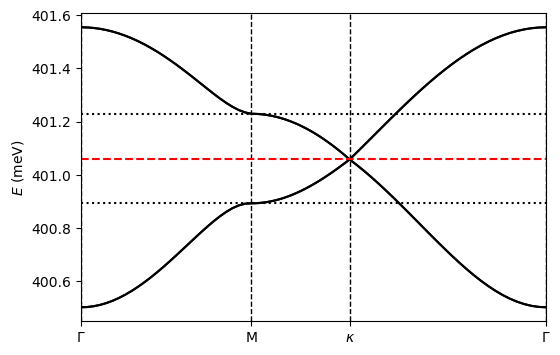

In [14]:
fig,ax=plt.subplots(figsize=(6,4))
energy_list=params.plot_dispersion(k=4,ax=ax)
vH=energy_list[params.n+1,:4]
ax.axhline(y=(energy_list[:,1].min()+energy_list[:,2].max())/2,ls='dashed',color='red')
ax.axhline(y=vH[1],ls='dotted',color='black')
ax.axhline(y=vH[2],ls='dotted',color='black')

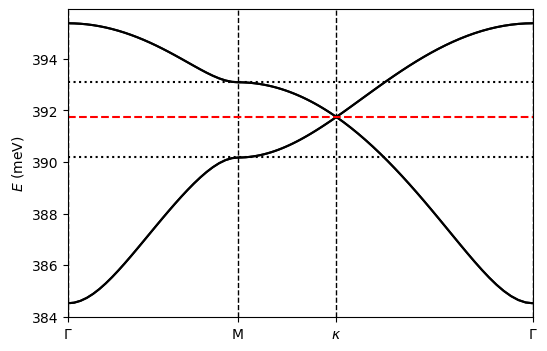

In [16]:
fig,ax=plt.subplots(figsize=(6,4))
energy_list=params.plot_dispersion(k=4,ax=ax)
vH=energy_list[params.n+1,:4]
ax.axhline(y=(energy_list[:,1].min()+energy_list[:,2].max())/2,ls='dashed',color='red')
ax.axhline(y=vH[1],ls='dotted',color='black')
ax.axhline(y=vH[2],ls='dotted',color='black')

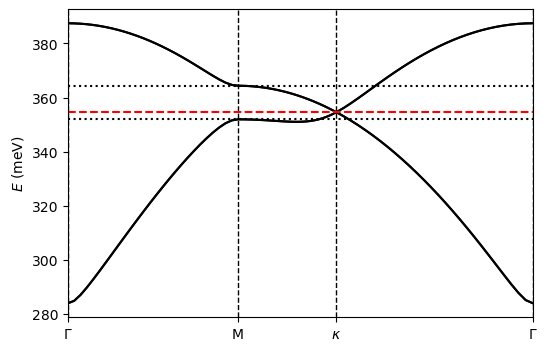

In [ ]:
fig,ax=plt.subplots(figsize=(6,4))
energy_list=params.plot_dispersion(k=4,ax=ax)
vH=energy_list[params.n+1,:4]
ax.axhline(y=(energy_list[:,1].min()+energy_list[:,2].max())/2,ls='dashed',color='red')
ax.axhline(y=vH[1],ls='dotted',color='black')
ax.axhline(y=vH[2],ls='dotted',color='black')

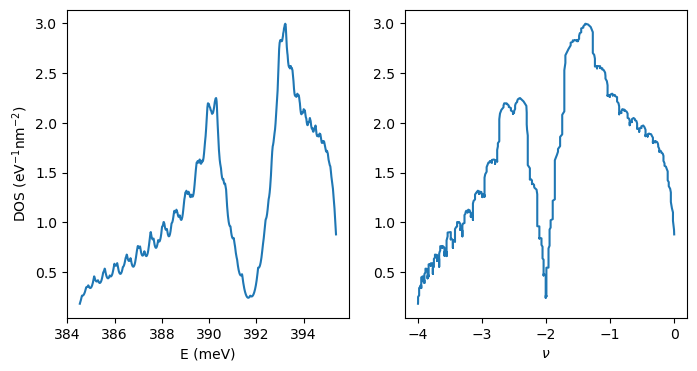

In [20]:
energy_range,filling_range,dos,energy_map=params.plot_LDOS(state=4,bw_method=0.2)

array([[ 396.12736377,  394.62456377,  385.27533835, ..., -731.92864157,
        -731.92864157, -731.92964109],
       [ 396.12628303,  394.62348303,  385.28103984, ..., -732.44114715,
        -732.44115109, -732.95311834],
       [ 396.12304127,  394.62024127,  385.29808288, ..., -732.95774005,
        -732.95774204, -733.98166804],
       ...,
       [ 396.10804391,  394.60524391,  385.30064784, ..., -807.58173502,
        -860.32415719, -861.82695719],
       [ 396.1121844 ,  394.6093844 ,  385.27758817, ..., -807.23712596,
        -861.00078717, -862.50358717],
       [ 396.11415945,  394.61135945,  385.2657224 , ..., -806.90207575,
        -861.68049542, -863.18329542]])

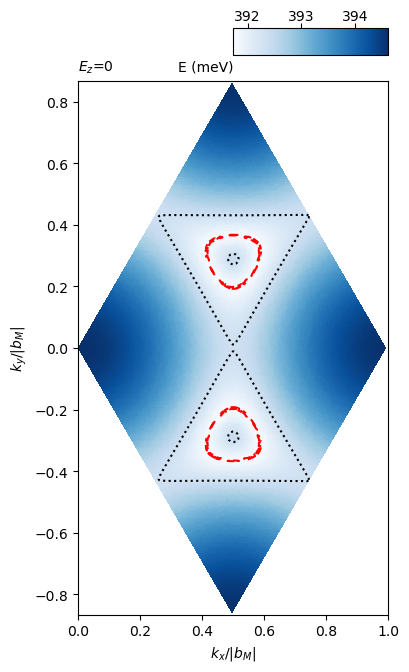

In [288]:
params.plot_bandstructure(state=2,bz='diamond',vH=vH[2],FS=['dashed','dashed'],FS_shift=[0.025,-1])

In [40]:
1.44/(params.aM/10)

0.15324842212633139

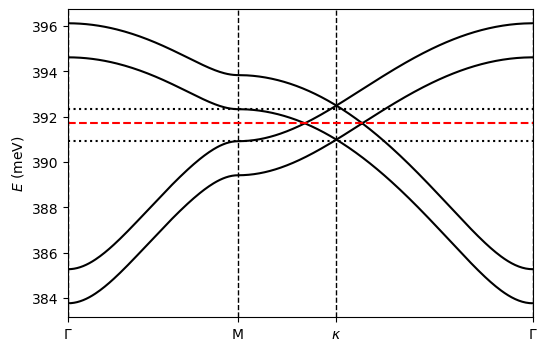

In [291]:
fig,ax=plt.subplots(figsize=(6,4))
energy_list=params.plot_dispersion(k=4,ax=ax)
vH=energy_list[params.n+1,:4]
ax.axhline(y=(energy_list[:,1].min()+energy_list[:,2].max())/2,ls='dashed',color='red')
ax.axhline(y=vH[1],ls='dotted',color='black')
ax.axhline(y=vH[2],ls='dotted',color='black')

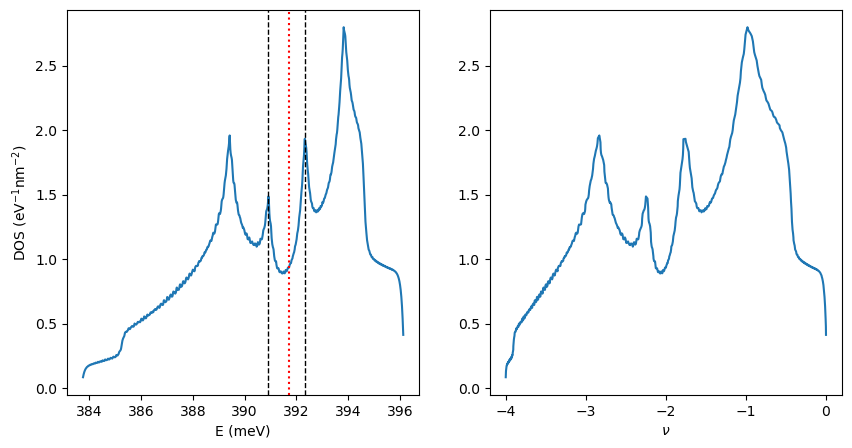

In [295]:
fig,ax=plt.subplots(1,2,figsize=(10,5))
energy_range,filling_range,dos,energy_map=params.plot_LDOS(state=4,bw_method=0.08,ax=ax)
# ax[0].axvline(x=vH[0],ls='dashed')
ax[0].axvline(x=vH[1],ls='dashed',color='k',lw=1)
ax[0].axvline(x=vH[2],ls='dashed',color='k',lw=1)
ax[0].axvline(x=energy_list[:,1].min(),ls='dotted',color='r')
# ax[1].axvline(x=vH[1],ls='dashed')
# ax[1].axvline(x=vH[2],ls='dashed')
# ax[0].axvline(x=vH[3],ls='dashed')

In [1110]:
val,vec,_=params.energy_single(*params.high_symm['Gamma'])

In [1112]:
vec.shape

(28, 28)

In [1111]:
pd.DataFrame(vec[:,0].reshape((4,-1)))

0                   1                   2  \
0 -0.054646-0.000917j -0.054646+0.000917j -0.054646+0.000917j   
1 -0.069241-0.001163j -0.069241+0.001163j -0.069241+0.001163j   
2 -0.069241+0.001163j -0.069241-0.001163j -0.069241-0.001163j   
3 -0.054646+0.000917j -0.054646-0.000917j -0.054646-0.000917j   

                    3                   4                   5  \
0  0.467677+0.000000j -0.054646-0.000917j -0.054646-0.000917j   
1  0.484337+0.000000j -0.069241-0.001163j -0.069241-0.001163j   
2  0.484337+0.000000j -0.069241+0.001163j -0.069241+0.001163j   
3  0.467677+0.000000j -0.054646+0.000917j -0.054646+0.000917j   

                    6  
0 -0.054646+0.000917j  
1 -0.069241+0.001163j  
2 -0.069241-0.001163j  
3 -0.054646-0.000917j

In [1113]:
pd.DataFrame(vec[:,7].reshape((4,-1)))

0                   1                   2  \
0  0.001081+0.001568j  0.001081-0.001568j  0.001081-0.001568j   
1  0.000512+0.000743j  0.000512-0.000743j  0.000512-0.000743j   
2 -0.000512+0.000743j -0.000512-0.000743j -0.000512-0.000743j   
3 -0.001081+0.001568j -0.001081-0.001568j -0.001081-0.001568j   

                    3                   4                   5  \
0  0.687231+0.000000j  0.001081+0.001568j  0.001081+0.001568j   
1  0.166392+0.000000j  0.000512+0.000743j  0.000512+0.000743j   
2 -0.166392-0.000000j -0.000512+0.000743j -0.000512+0.000743j   
3 -0.687231-0.000000j -0.001081+0.001568j -0.001081+0.001568j   

                    6  
0  0.001081-0.001568j  
1  0.000512-0.000743j  
2 -0.000512-0.000743j  
3 -0.001081-0.001568j

In [1114]:
pd.DataFrame(vec[:,14].reshape((4,-1)))

0                   1                   2  \
0 -0.075538-0.001414j -0.075538+0.001414j -0.075538+0.001414j   
1  0.055951+0.001047j  0.055951-0.001047j  0.055951-0.001047j   
2  0.055951-0.001047j  0.055951+0.001047j  0.055951+0.001047j   
3 -0.075538+0.001414j -0.075538-0.001414j -0.075538-0.001414j   

                    3                   4                   5  \
0  0.479363-0.000000j -0.075538-0.001414j -0.075538-0.001414j   
1 -0.466019+0.000000j  0.055951+0.001047j  0.055951+0.001047j   
2 -0.466019+0.000000j  0.055951-0.001047j  0.055951-0.001047j   
3  0.479363-0.000000j -0.075538+0.001414j -0.075538+0.001414j   

                    6  
0 -0.075538+0.001414j  
1  0.055951-0.001047j  
2  0.055951+0.001047j  
3 -0.075538-0.001414j

In [1115]:
pd.DataFrame(vec[:,21].reshape((4,-1)))

0                   1                   2  \
0  0.005154+0.000354j  0.005154-0.000354j  0.005154-0.000354j   
1 -0.020088-0.001380j -0.020088+0.001380j -0.020088+0.001380j   
2  0.020088-0.001380j  0.020088+0.001380j  0.020088+0.001380j   
3 -0.005154+0.000354j -0.005154-0.000354j -0.005154-0.000354j   

                    3                   4                   5  \
0  0.166008+0.000000j  0.005154+0.000354j  0.005154+0.000354j   
1 -0.685455+0.000000j -0.020088-0.001380j -0.020088-0.001380j   
2  0.685455-0.000000j  0.020088-0.001380j  0.020088-0.001380j   
3 -0.166008+0.000000j -0.005154+0.000354j -0.005154+0.000354j   

                    6  
0  0.005154-0.000354j  
1 -0.020088+0.001380j  
2  0.020088+0.001380j  
3 -0.005154-0.000354j

In [1120]:
val,vec=np.linalg.eigh(np.diag([1,2,1],1)+np.diag([1,2,1],-1))

In [1122]:
val

array([-2.41421356, -0.41421356,  0.41421356,  2.41421356])

In [1121]:
vec

array([[-0.27059805,  0.65328148,  0.65328148,  0.27059805],
       [ 0.65328148, -0.27059805,  0.27059805,  0.65328148],
       [-0.65328148, -0.27059805, -0.27059805,  0.65328148],
       [ 0.27059805,  0.65328148, -0.65328148,  0.27059805]])

In [1106]:
np.sum(np.abs()**2,axis=1)

array([0.23260063, 0.26739937, 0.26739937, 0.23260063])

In [939]:
pd.DataFrame(val.reshape((4,-1)).T)

0           1          2           3
0  391.028870  244.860007  21.180533 -560.342622
1  359.418274  202.362640 -10.529094 -601.024481
2  349.723004  202.293450 -19.015646 -601.989399
3  349.723004  202.293450 -19.015646 -601.989399
4  331.703057  202.154601 -37.300430 -604.357863
5  331.703057  202.154601 -37.300430 -604.357863
6  318.165335  202.084894 -56.273700 -605.567058

In [ ]:
pd.DataFrame(val.reshape((4,-1)))

0             1             2             3             4   \
0    280.168245    240.174415    238.697464    238.697464    235.863340   
1   -286.517030   -350.952455   -351.227632   -351.227632   -352.450424   
2  -9723.828978  -9764.354766  -9765.504008  -9765.504008  -9767.740160   
3 -10305.817662 -10373.304393 -10373.544470 -10373.544470 -10374.450771   

             5             6             7             8             9   \
0    235.863340    234.406055    152.210085    152.137923    152.137923   
1   -352.450424   -353.248674   -395.806204   -397.247863   -397.247863   
2  -9767.740160  -9768.895119  -9851.776835  -9851.819217  -9851.819217   
3 -10374.450771 -10375.021234 -10406.215674 -10406.215723 -10406.215723   

             10            11            12            13            14  \
0    151.993268    151.993268    151.920773    109.337299    109.314065   
1   -400.029670   -400.029670   -401.409771   -402.342145   -402.342465   
2  -9851.904104  -9851.904104  -9851.946609  -9894.553799  -9894.569224   
3 -10406.215797 -10406.215797 -10406.215827 -10417.630593 -10418.731955   

             15            16            17            18            19  \
0    109.314065    109.267802    109.267802    109.244780    -17.060492   
1   -402.342465   -402.344184   -402.344184   -402.348807   -516.134508   
2  -9894.569224  -9894.599988  -9894.599988  -9894.615326 -10021.289885   
3 -10418.731955 -10420.882602 -10420.882602 -10421.954632 -10538.957212   

             20            21            22            23            24  \
0    -17.089352    -17.089352    -17.148787    -17.148787    -17.179434   
1   -516.216455   -516.216455   -516.380271   -516.380271   -516.462056   
2 -10021.306543 -10021.306543 -10021.340589 -10021.340589 -10021.358001   
3 -10539.010536 -10539.010536 -10539.116678 -10539.116678 -10539.169441   

             25            26            27            28            29  \
0    -19.888218    -19.917320    -19.917320    -19.973666    -19.973666   
1   -531.701226   -531.833110   -531.833110   -532.097830   -532.097830   
2 -10023.524407 -10023.541232 -10023.541232 -10023.574107 -10023.574107   
3 -10552.512173 -10552.595736 -10552.595736 -10552.763921 -10552.763921   

             30            31            32            33            34  \
0    -20.000986   -103.841153   -103.841183   -103.841183   -103.841243   
1   -532.230493   -610.509809   -610.578540   -610.578540   -610.715686   
2 -10023.590180 -10107.736407 -10107.736418 -10107.736418 -10107.736439   
3 -10552.848436 -10631.984453 -10632.031425 -10632.031425 -10632.125246   

             35            36            37            38            39  \
0   -103.841243   -103.841272   -219.861275   -231.672697   -231.672850   
1   -610.715686   -610.784104   -735.373065   -735.373774   -735.373774   
2 -10107.736439 -10107.736450 -10235.594909 -10235.594961 -10235.594961   
3 -10632.125246 -10632.172097 -10757.567226 -10757.567354 -10757.567354   

             40            41            42            43            44  \
0   -231.672850   -231.673168   -231.673168   -231.673328   -253.119618   
1   -735.375194   -735.375194   -735.375905   -780.281994   -780.331875   
2 -10235.595064 -10235.595064 -10235.595115 -10242.772169 -10276.945099   
3 -10757.567610 -10757.567610 -10757.567739 -10801.939508 -10801.964782   

             45            46            47            48            49  \
0   -259.731999   -259.731999   -274.006562   -274.006562   -274.354472   
1   -780.331875   -780.436999   -780.436999   -780.492665   -783.171489   
2 -10278.261431 -10278.266991 -10278.266991 -10278.281348 -10278.281348   
3 -10801.964782 -10802.017122 -10802.017122 -10802.044277 -10804.148396   

             50            51            52            53            54  \
0   -274.363605   -274.363605   -274.386688   -274.386688   -274.401570   
1   -783.227888   -783.227888   -783.334475   -783.334475   -783.385086   
2 -10278.292555 -10278.32666

## Wavefunction

In [1097]:
params=Params(Nmax=4,**convert_params(res_1.x),Ez=600)

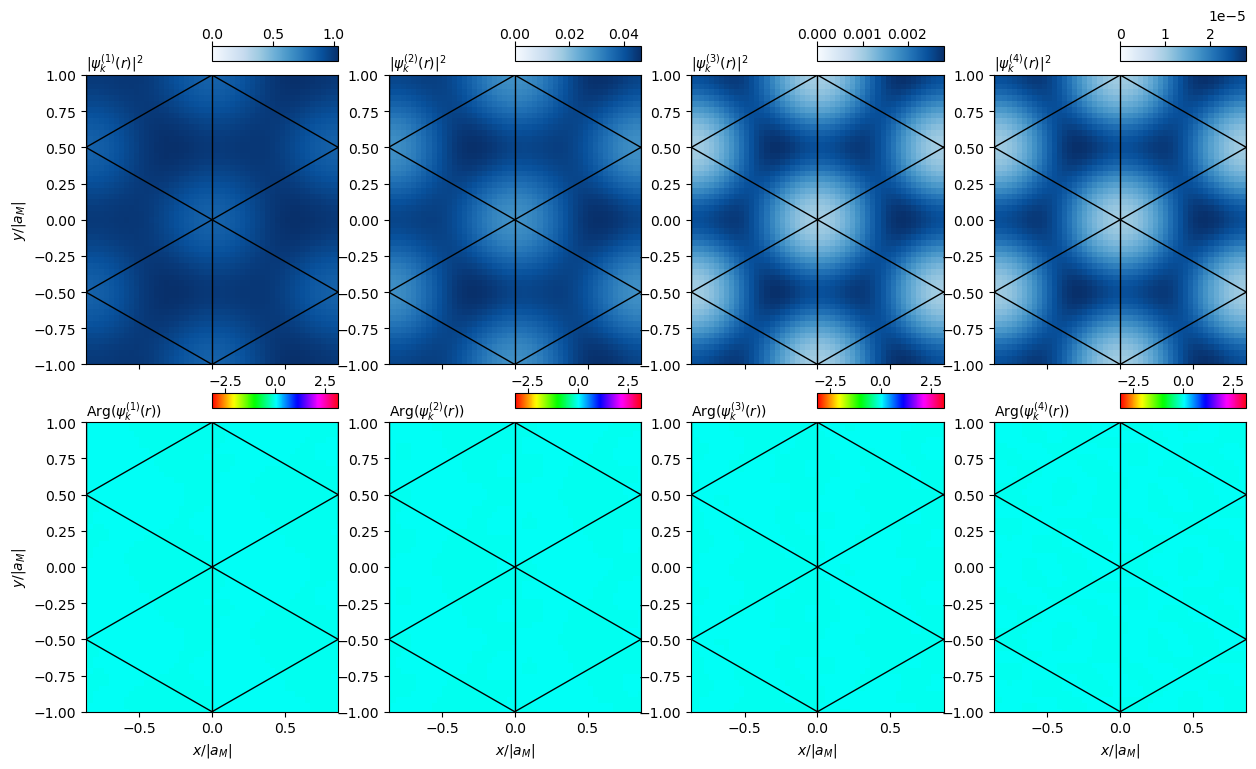

In [1098]:
psi1,psi2,psi3,psi4=params.plot_psi(0,0,state=0)

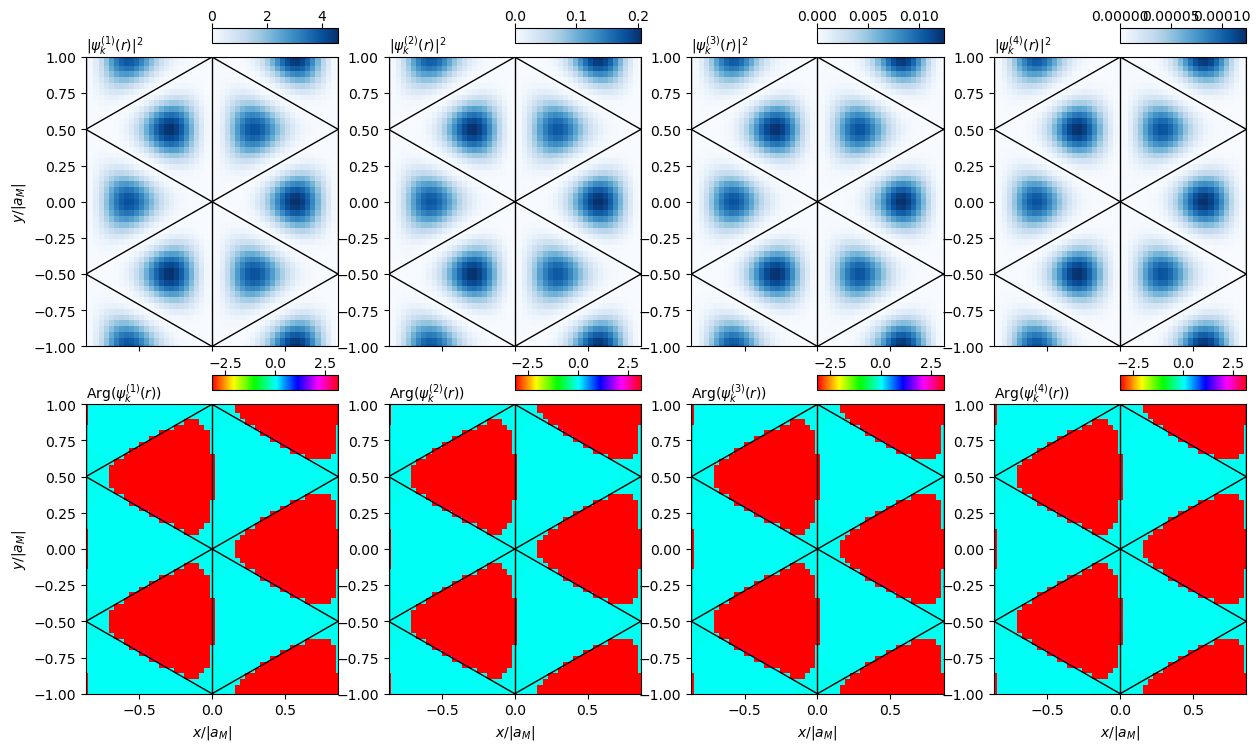

In [1099]:
psi1,psi2,psi3,psi4=params.plot_psi(0,0,state=1)

In [1100]:
params=Params(Nmax=4,Ez=0.01+600,**convert_params(res_1.x))

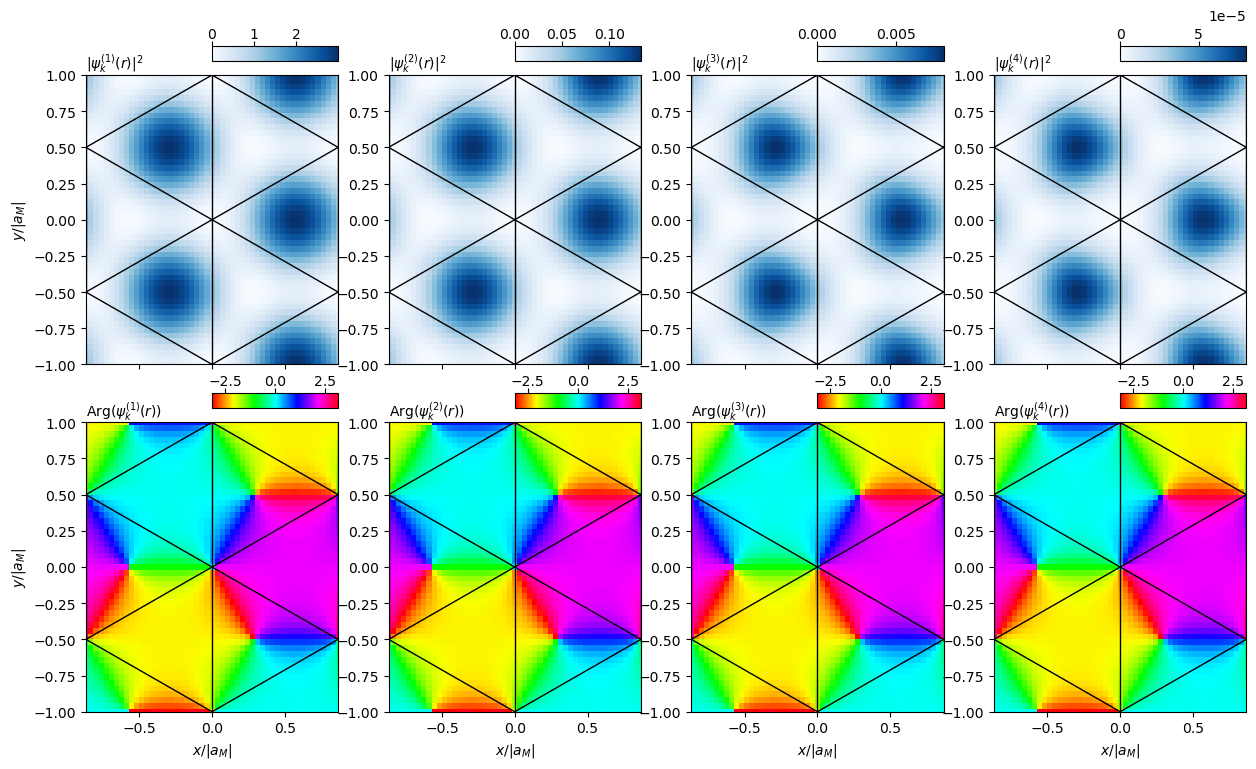

In [1101]:
psi1,psi2,psi3,psi4=params.plot_psi(*(params.high_symm['kappa']),state=0)

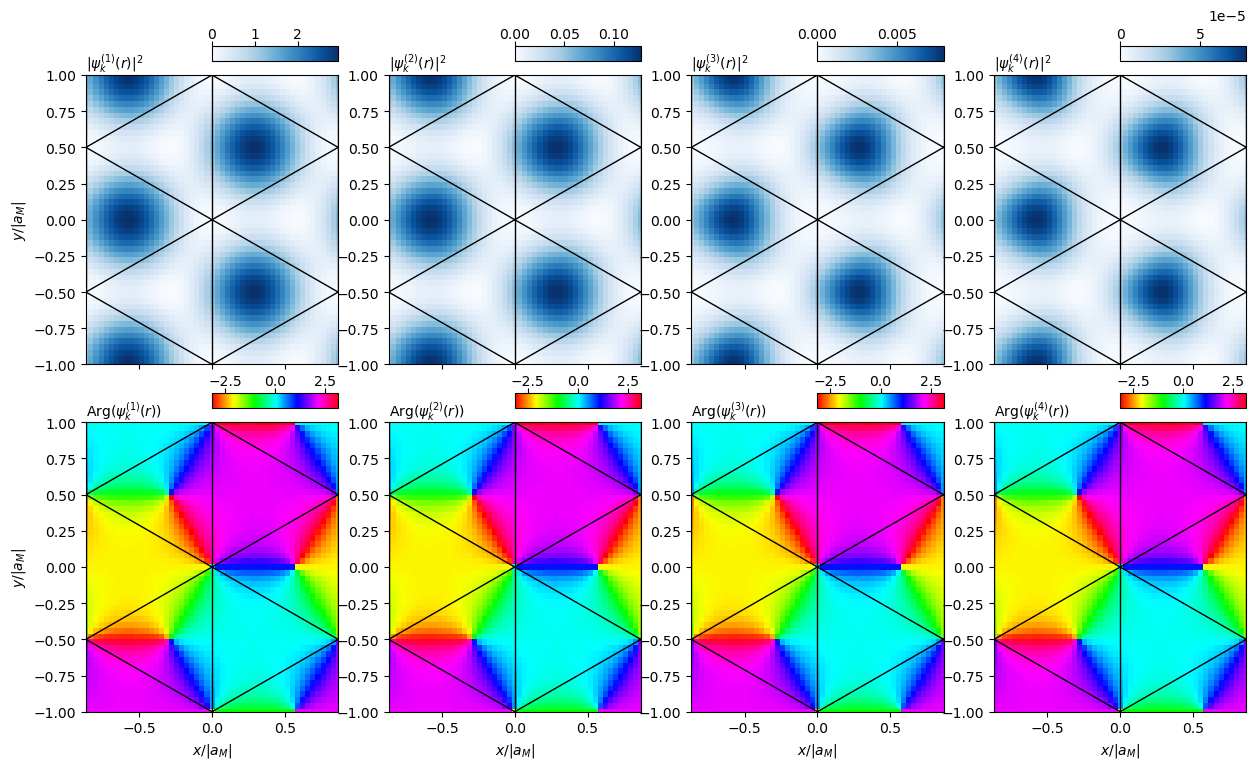

In [1102]:
psi1,psi2,psi3,psi4=params.plot_psi(*(params.high_symm['kappa']),state=1)

## Gap vs Ez

In [14]:
pp=np.array([0.200260,-0.159183,-0.008583,-0.176364,0.184207,0.356749,-0.009703])

In [68]:
Ez_list=np.linspace(0,100,51)
gap12_list={}
# gap23_list=[]
theta_list=[2,3,4,5]
for theta in theta_list:
    gap12_list[theta]=[]
    for Ez in Ez_list:
        params=Params(Nmax=4,**convert_params(pp),Ez=Ez,theta=theta)
        en_list,val_list,_=params.energy_single(*params.high_symm['kappa'])
        gap12_list[theta].append(en_list[0]-en_list[1])
        # en_list=params.plot_dispersion(k=2,ax=False)
        # gap12_list.append(en_list[:,0].min()-en_list[:,1].max())
        # gap23_list.append(en_list[:,1].min()-en_list[:,2].max())
    gap12_list[theta]=np.array(gap12_list[theta])
    # gap23_list=np.array(gap23_list)

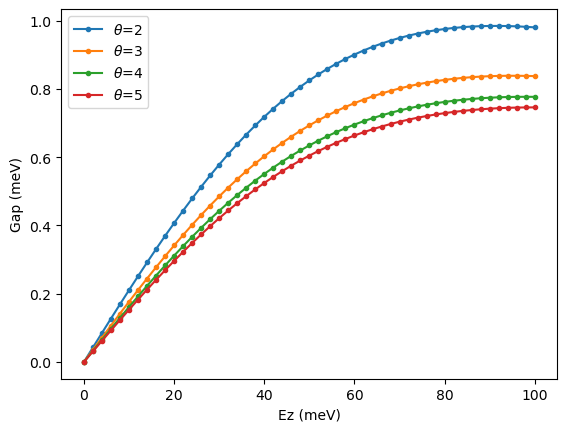

In [69]:
fig,ax=plt.subplots()
for theta,gap in gap12_list.items():
    ax.plot(Ez_list,gap,'.-',label=r'$\theta$={}'.format(str(theta)))
# ax.plot(Ez_list,gap23_list,'.-',label='$E_3-E_2$')
ax.set_xlabel('Ez (meV)')
ax.set_ylabel('Gap (meV)')
ax.legend()

## V_f, compare Zeeman and gauge  

In [17]:
pp=np.array([0.200260,-0.159183,-0.008583,-0.176364,0.184207,0.356749,-0.009703],)

In [17]:
convert_params(pp)

{'V1': 200.26,
 'V2_0': -159.183,
 'V2_1': -8.583,
 'phi2': -0.176364,
 'Tm': 184.20700000000002,
 'Tp_0': 356.74899999999997,
 'Tp_1': -9.703}

In [27]:
params=Params(Nmax=4,**convert_params(pp),Ez=00,n=15,theta=2)

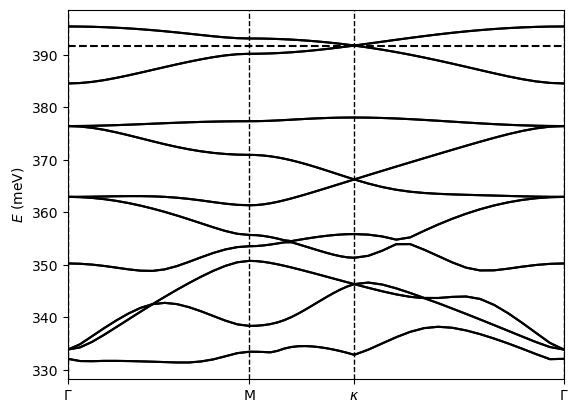

In [34]:
fig,ax=plt.subplots()
energy_list=params.plot_dispersion(k=20,ax=ax)
ax.axhline(y=energy_list[:,0].min(),ls='dashed',color='black')

In [300]:
def bandwidth(params):
    energy_list=params.plot_dispersion(ax=False,k=2)
    band1=np.r_[energy_list[:2*params.n+1,0],energy_list[2*params.n+1:,1]]


In [301]:
def vF(params):
    energy_list=params.plot_dispersion(ax=False,k=2)
    band1=np.r_[energy_list[:2*params.n+1,0],energy_list[2*params.n+1:,1]]
    k_dist=params.high_symm['G_M_K_G_dist']
    v_f=np.gradient(band1,k_dist)
    # in the unit of m/s
    bw=band1.max()-band1.min()
    return np.abs(v_f[params.n*2]/(6.58e-16*1e3*1e10)),bw, params.aM
    # params.aM*bw/6.582e-13*1e-10
    

In [302]:
theta_list=np.linspace(1,5,21)
vF_list,bw_list,at_list=[],[],[]
for theta in theta_list:
    vf,bw,at=vF(Params(Nmax=4,**convert_params(pp),Ez=00,theta=theta,n=15))
    vF_list.append(vf)
    bw_list.append(bw)
    at_list.append(at)


Text(0.5, 0, '$\\theta$ (deg)')

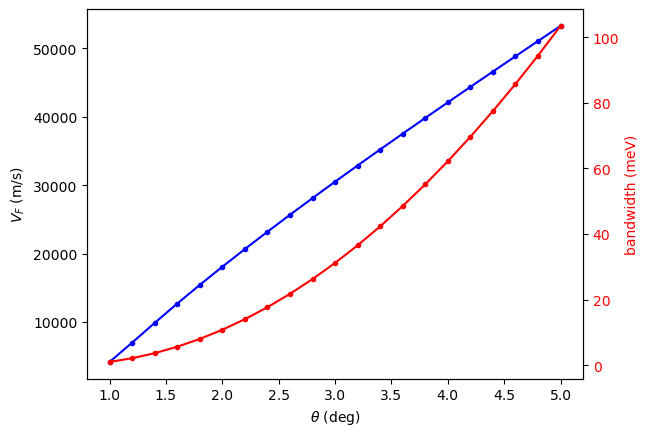

In [23]:
fig,ax=plt.subplots()
ax.plot(theta_list,vF_list,'.-',color='b')
# ax.plot(theta_list,np.array(at_list)/11,'.-',color='y')
ax.set_ylabel('$V_F$ (m/s)')
ax2=ax.twinx()
ax2.plot(theta_list,bw_list,'.-',color='r')
ax2.set_ylabel('bandwidth (meV)',color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax.set_xlabel(r'$\theta$ (deg)')

Text(0, 0.5, '$a_M (\\AA)$')

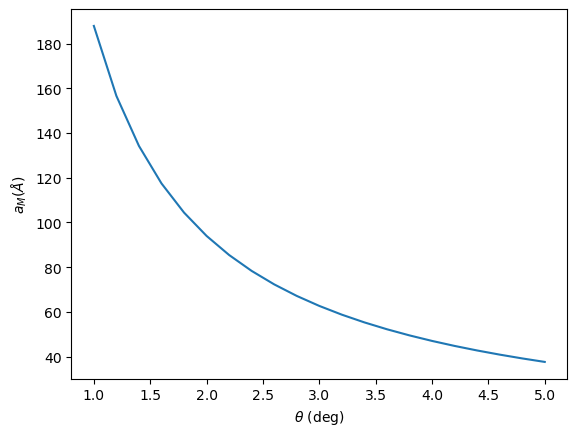

In [27]:
fig,ax=plt.subplots()
ax.plot(theta_list,at_list)
ax.set_xlabel(r'$\theta$ (deg)')
ax.set_ylabel('$a_M (\AA)$')

In [3]:
1.05e-34*20000/(6e-9)/1.6e-19

0.0021875000000000006

In [8]:
np.exp(-1/(12*1000*6**2))

0.9999976851878644

In [ ]:
np.exp(-1/(12*1000*6**2))

In [12]:
(12*1000*6**2)

432000

In [9]:
12*0.002081909744287143

0.024982916931445717

In [11]:
12*79386453547650830*5.245e-20

0.04996583386289143

In [21]:
5.78e-5*10*2*1e3

1.1560000000000001

In [308]:
B=np.linspace(0,50)
E_A=np.sqrt(1.05e-34*1.6e-19*B)*30000/1.6e-19*1e3
E_Z=5.78e-5*B*2*1e3

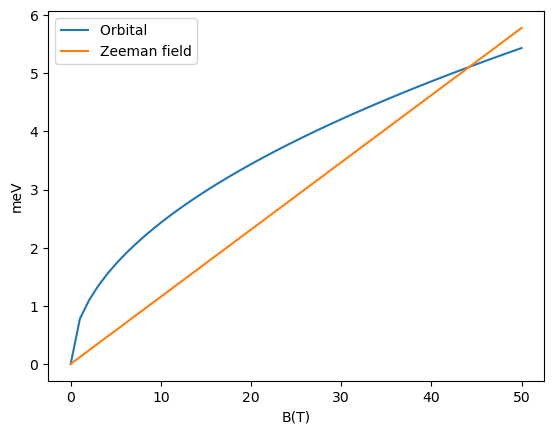

In [309]:
fig,ax=plt.subplots()
# v_F e A=v_F \sqrt{\hbar e B}
ax.plot(B,E_A,label='Orbital ')
# g\mu_B B
ax.plot(B,E_Z,label='Zeeman field')
ax.set_xlabel('B(T)')
ax.set_ylabel('meV')
ax.legend()

In [24]:
params.aM

62.64338560097001

In [25]:
6.62607015e-34/1.6e-19/(np.sqrt(3)/4*6e-9**2)

265.6641239424892

In [17]:
vF(Params(Nmax=4,**convert_params(pp),Ez=00,n=15,theta=3))

(30500.659951749985, 31.219242121659647)

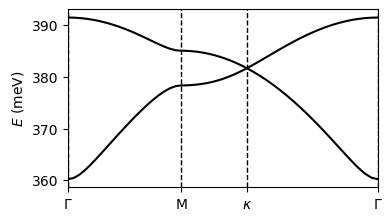

In [96]:
energy_list=params.plot_dispersion(k=2)

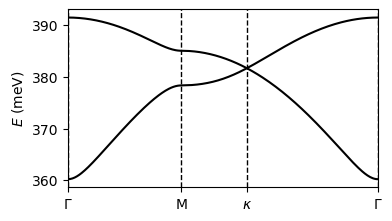

In [ ]:
energy_list=params.plot_dispersion(k=2)

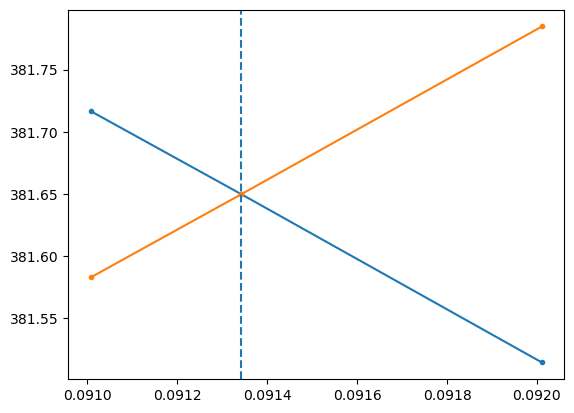

In [87]:
band1=np.r_[energy_list[:2*params.n+1,0],energy_list[2*params.n+1:,1]]
band2=np.r_[energy_list[:2*params.n+1,1],energy_list[2*params.n+1:,0]]
k_dist=params.high_symm['G_M_K_G_dist']
fig,ax=plt.subplots()
ax.plot(k_dist[2*params.n-1:2*params.n+2],band1[2*params.n-1:2*params.n+2],'.-')
ax.plot(k_dist[2*params.n-1:2*params.n+2],band2[2*params.n-1:2*params.n+2],'.-')
ax.axvline(x=params.high_symm['G_M_K_G_dist'][2*params.n],ls='dashed')

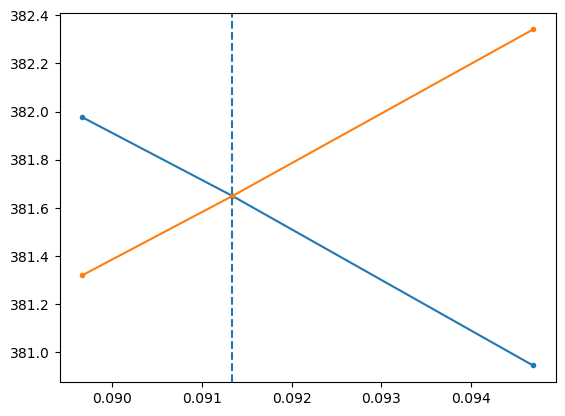

In [97]:
band1=np.r_[energy_list[:2*params.n+1,0],energy_list[2*params.n+1:,1]]
band2=np.r_[energy_list[:2*params.n+1,1],energy_list[2*params.n+1:,0]]
k_dist=params.high_symm['G_M_K_G_dist']
fig,ax=plt.subplots()
ax.plot(k_dist[2*params.n-1:2*params.n+2],band1[2*params.n-1:2*params.n+2],'.-')
ax.plot(k_dist[2*params.n-1:2*params.n+2],band2[2*params.n-1:2*params.n+2],'.-')
ax.axvline(x=params.high_symm['G_M_K_G_dist'][2*params.n],ls='dashed')

In [88]:
v_f=np.gradient(band1,k_dist)

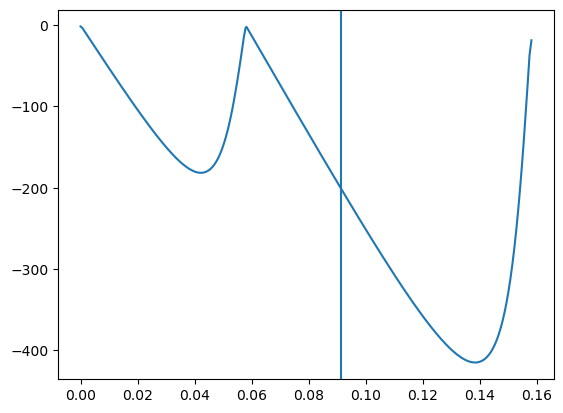

In [89]:
fig,ax=plt.subplots()
ax.plot(k_dist,v_f)
ax.axvline(x=k_dist[params.n*2])

In [90]:
v_f[params.n*2]/(6.58e-16*1e3*1e10)

-30504.16965867088

In [64]:
(band1[2:]-band1[:-2])/(k_dist[2:]-k_dist[:-2])

array([ -0.4751313 ,  -0.95016281,  -1.42499464,  -1.89952666,
        -2.37365837,  -2.84728882,  -3.32031648,  -3.79263909,
        -4.26415355,  -4.7347558 ,  -5.20434067,  -5.67280176,
        -6.14003127,  -6.6059199 ,  -7.07035663,  -7.53322861,
        -7.99442096,  -8.45381663,  -8.91129615,  -9.36673749,
        -9.82001581, -10.27100325, -10.71956871, -11.16557757,
       -11.60889141, -12.04936779, -12.48685984, -12.92121603,
       -13.35227974, -13.77988891, -14.20387565, -14.62406574,
       -15.04027823, -15.45232487, -15.86000956, -16.26312778,
       -16.66146591, -17.05480055, -17.44289771, -17.82551205,
       -18.20238591, -18.57324838, -18.93781419, -19.29578259,
       -19.64683607, -19.99063894, -20.3268359 , -20.65505035,
       -20.97488262, -21.285908  , -21.58767463, -21.87970116,
       -22.16147423, -22.43244569, -22.69202956, -22.93959882,
       -23.17448175, -23.39595808, -23.6032548 , -23.79554155,
       -23.97192572, -24.13144712, -24.2730723 , -24.39

# Draft

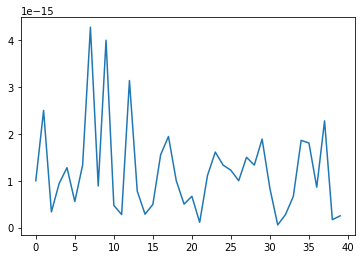

In [ ]:
plt.plot(energy_list[:40,16]-energy_list[:40,17])

In [ ]:
energy_list[0,16]-energy_list[0,18]

0.5087386497548527

In [ ]:
energy_list[0,16]-energy_list[80,16]

0.3529091079065129

In [ ]:
energy_list[80].reshape((-1,2))

array([[ 4.47896724,  4.47896724],
       [ 3.60959261,  3.50296922],
       [ 2.98194402,  2.98194402],
       [ 1.77396867,  1.77396867],
       [-0.00729098, -0.06058284],
       [-1.96188481, -1.96188481],
       [-2.68946958, -2.68946958],
       [-3.51533363, -3.51533363],
       [-3.71611704, -3.93359343],
       [-4.57673517, -4.57673517],
       [-5.41959888, -5.58469215]])

: 

(-1.0, 1.0)

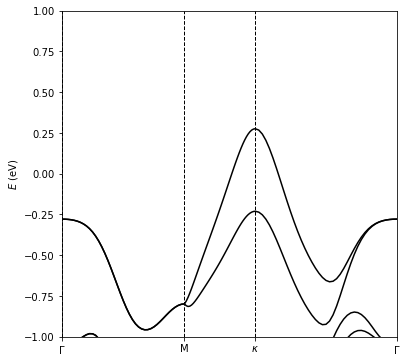

In [ ]:
WSe2_AA=TB(data,'WSe2',data_lattice=data_lattice,data_interlayer=data_interlayer,SOC=data_SOC,N_n=5,theta=0,shift_M=0)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_AA.plot_dispersion(XM2=True,ax=ax,color='k',spinless=False,monolayer=True,eff=1)
ax.set_ylim(-1,1)

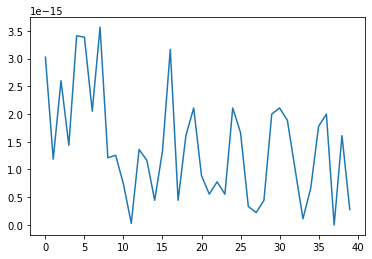

In [ ]:
plt.plot(energy_list[:40,16]-energy_list[:40,17])

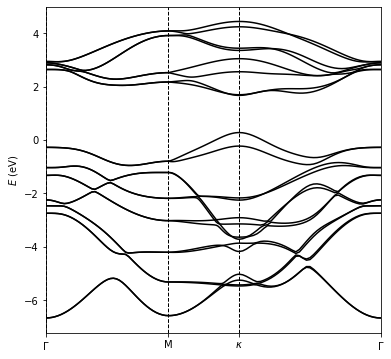

In [ ]:
WSe2=TB(data,'WSe2',data_lattice=data_lattice,data_interlayer=data_interlayer,SOC=data_SOC,N_n=5,theta=0,shift_M=0)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2.plot_dispersion(XM2=True,ax=ax,color='k',spinless=False,monolayer=True,eff=1)
# ax.set_ylim(-1,1)

(-1.0, 1.0)

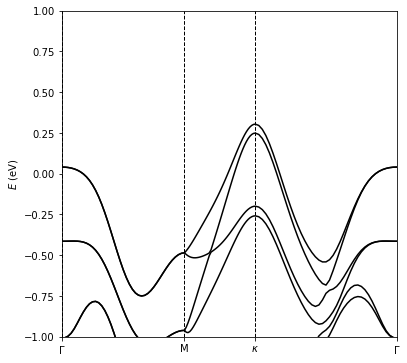

In [ ]:
WSe2_AA=TB(data,'WSe2',data_lattice=data_lattice,data_interlayer=data_interlayer,SOC=data_SOC,N_n=5,theta=0,shift_M=0)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_AA.plot_dispersion(XM2=True,ax=ax,color='k',spinless=False,monolayer=False,eff=1)
ax.set_ylim(-1,1)

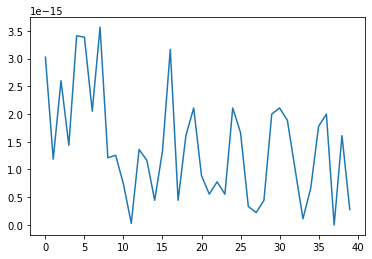

In [ ]:
plt.plot(energy_list[:40,16]-energy_list[:40,17])

(-1.2, 0.5)

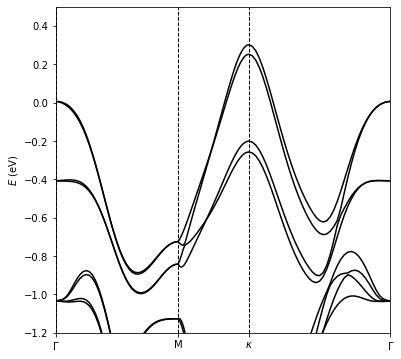

In [ ]:
WSe2_AB=TB(data,'WSe2',data_lattice=data_lattice,data_interlayer=data_interlayer,SOC=data_SOC,N_n=5,theta=180,shift_M=1)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2_AB.plot_dispersion(XM2=True,ax=ax,color='k',spinless=False,monolayer=False,eff=1)
ax.set_ylim(-1.2,.5)

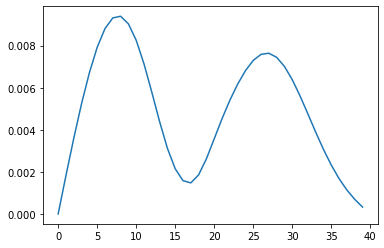

In [ ]:
plt.plot(energy_list[:40,16]-energy_list[:40,17])

(-1.5, 0.5)

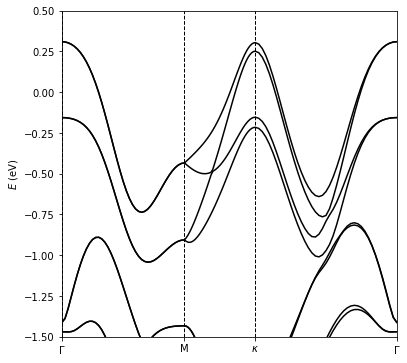

In [ ]:
WS2_AA=TB(data,'WS2',data_lattice=data_lattice,data_interlayer=data_interlayer,SOC=data_SOC,N_n=5,theta=0,shift_M=0)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WS2_AA.plot_dispersion(XM2=True,ax=ax,color='k',spinless=False,monolayer=False,eff=1)
ax.set_ylim(-1.5,.5)

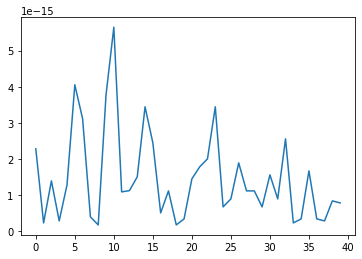

In [ ]:
plt.plot(energy_list[:40,16]-energy_list[:40,17])

(-1.2, 0.5)

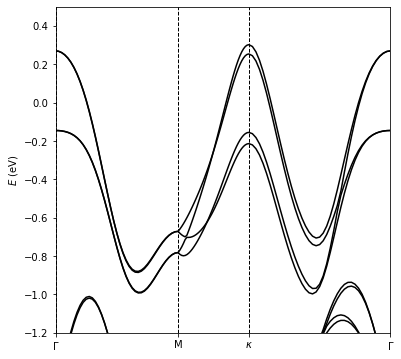

In [ ]:
WS2_AB=TB(data,'WS2',data_lattice=data_lattice,data_interlayer=data_interlayer,SOC=data_SOC,N_n=5,theta=180,shift_M=1)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WS2_AB.plot_dispersion(XM2=True,ax=ax,color='k',spinless=False,monolayer=False,eff=1)
ax.set_ylim(-1.2,.5)

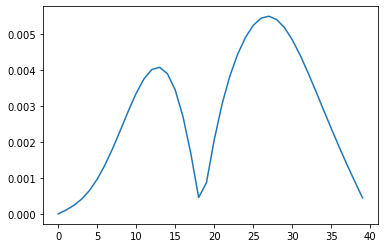

In [ ]:
plt.plot(energy_list[:40,16]-energy_list[:40,17])

(-1.5, 0.5)

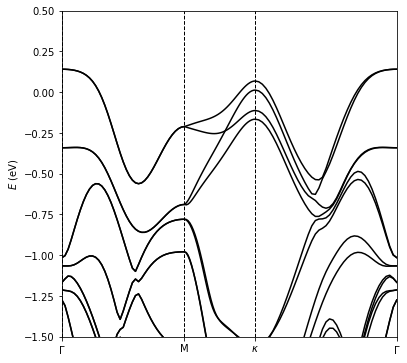

In [ ]:
MoSe2_AA=TB(data,'MoSe2',data_lattice=data_lattice,data_interlayer=data_interlayer,SOC=data_SOC,N_n=5,theta=0,shift_M=0)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoSe2_AA.plot_dispersion(XM2=True,ax=ax,color='k',spinless=False,monolayer=False,eff=1)
ax.set_ylim(-1.5,.5)

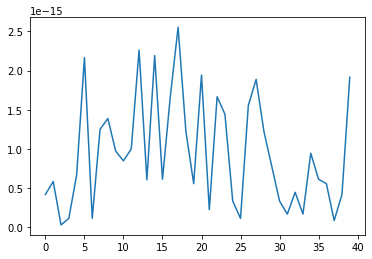

In [ ]:
plt.plot(energy_list[:40,16]-energy_list[:40,17])

(-1.0, 1.0)

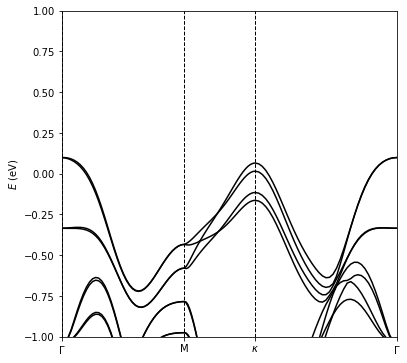

In [ ]:
MoSe2_AB=TB(data,'MoSe2',data_lattice=data_lattice,data_interlayer=data_interlayer,SOC=data_SOC,N_n=5,theta=180,shift_M=1)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoSe2_AB.plot_dispersion(XM2=True,ax=ax,color='k',spinless=False,monolayer=False,eff=1)
# energy_list_2=MoSe2.plot_dispersion(XM2=True,ax=ax,color='r',spinless=False,monolayer=False,eff=2)
ax.set_ylim(-1,1)

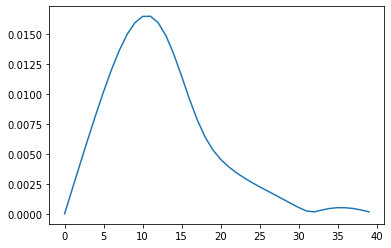

In [ ]:
plt.plot(energy_list[:40,16]-energy_list[:40,17])

In [ ]:
energy_list[0,16]-energy_list[0,18]

0.45486440000750866

In [ ]:
H_K=MoS2.get_Hamiltonian_bilayer(*MoS2.high_symm['Gamma'],spinless=True,eff=1)
val,vec=get_energy(H_K)

: 

In [ ]:
val

array([ 2.93827083,  2.93827083,  2.85092377,  2.85092377,  2.73000461,
        2.73000461,  2.65815378,  2.65815378,  0.36969587, -0.07938565,
       -1.24121513, -1.3808571 , -1.3808571 , -1.44581387, -1.44581387,
       -2.41550554, -2.77734449, -2.77734449, -2.82633753, -2.82633753,
       -5.68381017, -6.52737938])

: 

In [ ]:
np.round(MoS2.get_t_mat(*MoS2.high_symm['kappa']),3)

array([[-0.136-0.j   ,  0.   +0.136j, -0.   -0.397j],
       [ 0.   +0.136j,  0.136+0.j   ,  0.397+0.j   ],
       [-0.   -0.397j,  0.397+0.j   , -0.   -0.j   ]])

: 

In [ ]:
tunnel=MoS2.get_tunneling(*MoS2.high_symm['Gamma'])

: 

In [ ]:
H_K[np.ix_([5,8,16,19],[5,8,16,19])].real

array([[-1.9254    , -2.8566    ,  0.        ,  0.        ],
       [-2.8566    , -4.0445    ,  0.        , -0.61673528],
       [ 0.        ,  0.        , -1.9254    , -2.8566    ],
       [ 0.        , -0.61673528, -2.8566    , -4.0445    ]])

: 

In [ ]:
val2,vec2=get_energy(H_K[np.ix_([5,8,16,19],[5,8,16,19])].real)

: 

In [ ]:
val2

array([ 0.27713369, -0.12608506, -5.63029841, -6.46055022])

: 

In [ ]:
val2

array([ 0.06182038,  0.06182038, -6.03172038, -6.03172038])

: 

In [ ]:
tunnel[np.ix_([8,19],[8,19])]

array([[ 0.        +0.j, -0.61673528+0.j],
       [-0.61673528+0.j,  0.        +0.j]])

: 

In [ ]:
pd.DataFrame(np.round(tunnel[:11,11:],4),index=range(11),columns=range(11))

0         1               2               3               4   \
0   0.0+0.0j  0.0+0.0j  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j   
1   0.0+0.0j  0.0+0.0j  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j   
2   0.0+0.0j  0.0+0.0j -0.0000+0.0000j  0.0000-0.1984j -0.1984+0.0000j   
3   0.0+0.0j  0.0+0.0j -0.0000+0.1984j  0.0678-0.0000j -0.0000+0.0678j   
4   0.0+0.0j  0.0+0.0j  0.1984-0.0000j -0.0000+0.0678j -0.0678+0.0000j   
5   0.0+0.0j  0.0+0.0j  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j   
6   0.0+0.0j  0.0+0.0j  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j   
7   0.0+0.0j  0.0+0.0j  0.0000+0.0000j  0.0000+0.0000j  0.0000+0.0000j   
8   0.0+0.0j  0.0+0.0j -0.0000+0.0000j  0.0000-0.1984j -0.1984+0.0000j   
9   0.0+0.0j  0.0+0.0j -0.0000+0.1984j  0.0678-0.0000j -0.0000+0.0678j   
10  0.0+0.0j  0.0+0.0j  0.1984-0.0000j -0.0000+0.0678j -0.0678+0.0000j   

          5         6         7               8               9   \
0   0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0000+0.0000j  0.0000+0.0000j   
1   0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0000+0.0000j  0.0000+0.0000j   
2   0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0000-0.0000j -0.0000+0.1984j   
3   0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0000-0.1984j -0.0678+0.0000j   
4   0.0+0.0j  0.0+0.0j  0.0+0.0j -0.1984+0.0000j  0.0000-0.0678j   
5   0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0000+0.0000j  0.0000+0.0000j   
6   0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0000+0.0000j  0.0000+0.0000j   
7   0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0000+0.0000j  0.0000+0.0000j   
8   0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0000-0.0000j -0.0000+0.1984j   
9   0.0+0.0j  0.0+0.0j  0.0+0.0j  0.0000-0.1984j -0.0678+0.0000j   
10  0.0+0.0j  0.0+0.0j  0.0+0.0j -0.1984+0.0000j  0.0000-0.0678j   

                10  
0   0.0000+0.0000j  
1   0.0000+0.0000j  
2   0.1984-0.0000j  
3   0.0000-0.0678j  
4   0.0678-0.0000j  
5   0.0000+0.0000j  
6   0.0000+0.0000j  
7   0.0000+0.0000j  
8   0.1984-0.0000j  
9   0.0000-0.0678j  
10  0.0678-0.0000j

: 

In [ ]:
vec[:,6].conj().T@tunnel@vec[:,7]

(1.6785925287821287e-16+9.157934768027414e-18j)

: 

In [ ]:
vec[:11,6].conj().T@tunnel[:11,11:]@np.diag([1,-1,1,1,-1,1,-1,1,1,1,-1])@vec[11:,7]

(1.0266430179190617e-16+7.194148977004657e-17j)

: 

In [ ]:
vec[:11,6][-2:].conj().T@tunnel[:11,11:][-2:,-2:]@vec[11:,7][-2:]

(-1.2841429759424067e-17+9.157934768027568e-18j)

: 

In [ ]:
np.round(vec[:11,6][-2:],4).conj().T

array([ 0.    +0.2847j, -0.2847-0.j    ])

: 

In [ ]:
np.round(tunnel[:11,11:][-2:,-2:],4)

array([[-0.0678+0.j    ,  0.    -0.0678j],
       [ 0.    -0.0678j,  0.0678-0.j    ]])

: 

In [ ]:
np.round(vec[:11,6][-2:],4)

array([ 0.    -0.2847j, -0.2847+0.j    ])

: 

In [ ]:
np.round(np.diag([1,-1,1,1,-1,1,-1,1,1,1,-1])@vec[11:,7],4)

array([ 0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,  0.    +0.j    ,
        0.    +0.j    ,  0.9154+0.j    ,  0.    +0.j    ,  0.    -0.j    ,
        0.    +0.j    ,  0.    -0.2847j, -0.2847+0.j    ])

: 

In [ ]:
np.round(vec[:,6].reshape((2,-1)).T,4)

array([[ 0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ],
       [ 0.9154+0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ],
       [ 0.    -0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ],
       [ 0.    -0.2847j,  0.    +0.j    ],
       [-0.2847+0.j    ,  0.    +0.j    ]])

: 

In [ ]:
np.round((vec[:,7]).reshape((2,-1)).T,4)

array([[ 0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.9154+0.j    ],
       [ 0.    +0.j    , -0.    -0.j    ],
       [ 0.    +0.j    ,  0.    -0.j    ],
       [ 0.    +0.j    ,  0.    +0.j    ],
       [ 0.    +0.j    ,  0.    -0.2847j],
       [ 0.    +0.j    ,  0.2847-0.j    ]])

: 

In [ ]:
np.array([])

: 

In [ ]:
M3=np.diag([1]*11+[1,-1,1,1,-1,1,-1,1,1,1,-1])

: 

In [ ]:
M3@vec[:,7]

array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        9.15355212e-01+0.00000000e+00j,  6.10622664e-16+1.60628961e-15j,
        7.06231671e-16-1.01134325e-15j,  7.95242984e-16+4.91807631e-16j,
        2.46876545e-16-2.84714625e-01j, -2.84714625e-01+2.33058949e-16j])

: 

In [ ]:
energy_list[80,8]-energy_list[80,9]

0.0532918620796236

: 

In [ ]:
print(np.round(MoS2.get_t_mat(*MoS2.high_symm['Gamma']),4))

[[ 0.1366+0.j  0.    +0.j  0.    +0.j]
 [ 0.    +0.j  0.1366+0.j -0.    +0.j]
 [ 0.    +0.j -0.    +0.j  1.2335+0.j]]


: 

In [ ]:
MoS2.get_tunneling(0, 0)

(22, 22)

: 

In [ ]:
energy_list.shape

(121, 22)

: 

In [ ]:
energy_list_2.shape

(121, 44)

: 

In [ ]:
np.round(np.unique(MoS2.get_tunneling(0, 0)[22:,:22]),4)

array([-0.6167+0.j, -0.0683+0.j, -0.0683+0.j, -0.    +0.j, -0.    +0.j,
       -0.    +0.j,  0.    +0.j,  0.    +0.j,  0.    +0.j,  0.    +0.j,
        0.0683+0.j,  0.0683+0.j,  0.6167+0.j])

: 

In [ ]:
np.round(np.linalg.eigvalsh(MoS2.get_tunneling(0, 0)),4)

array([-1.2335, -1.2335, -0.1366, -0.1366, -0.1366, -0.1366, -0.    ,
       -0.    , -0.    , -0.    , -0.    , -0.    , -0.    , -0.    ,
       -0.    , -0.    , -0.    , -0.    , -0.    , -0.    , -0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.1366,  0.1366,  0.1366,  0.1366,
        1.2335,  1.2335])

: 

In [ ]:
Ham=MoS2.get_Hamiltonian_bilayer(MoS2.high_symm['G_M_K_G'][0][1],MoS2.high_symm['G_M_K_G'][1][1])

: 

: 

In [ ]:
Ham[::2,::2]

(22, 22)

: 

: 

In [ ]:
MoS2.high_symm['G_M_K_G'][0][1],MoS2.high_symm['G_M_K_G'][1][1]

(0.024854372259412935, 0.0143496785145112)

: 

: 

(-1.0, 0.5)

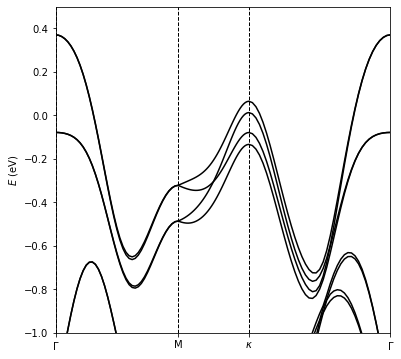

: 

In [ ]:
MoS2=TB(data,'MoS2',data_lattice=data_lattice,data_interlayer=data_interlayer,SOC=data_SOC,N_n=5,theta=180,)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2.plot_dispersion(XM2=True,ax=ax,color='k',spinless=False,monolayer=False,eff=1,line='G_M_K_G')
ax.set_ylim(-1,.5)

(-1.0, 0.5)

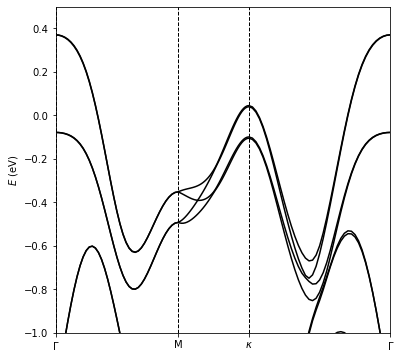

: 

In [ ]:
MoS2=TB(data,'MoS2',data_lattice=data_lattice,data_interlayer=data_interlayer,SOC=data_SOC,N_n=5,theta=180,)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2.plot_dispersion(XM2=True,ax=ax,color='k',spinless=False,monolayer=False,eff=1,line='G_M_K_G')
ax.set_ylim(-1,.5)

(-1.0, 0.5)

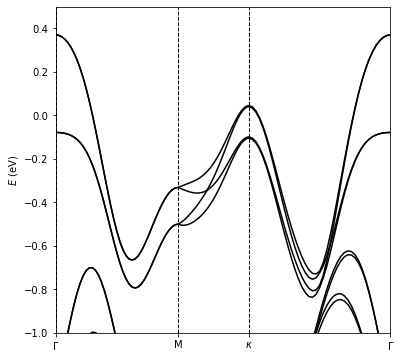

: 

In [ ]:
MoS2=TB(data,'MoS2',data_lattice=data_lattice,data_interlayer=data_interlayer,SOC=data_SOC,N_n=5,theta=180,)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=MoS2.plot_dispersion(XM2=True,ax=ax,color='k',spinless=False,monolayer=False,eff=1,line='G_M_K_G')
ax.set_ylim(-1,.5)

In [ ]:
energy_list[80,16]-energy_list[80,18]

0.14371084375199383

: 

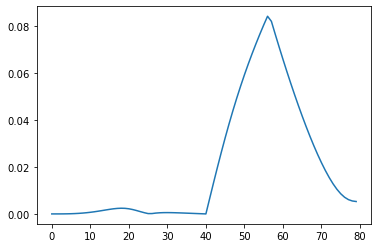

: 

In [ ]:
plt.plot(energy_list[:80,16]-energy_list[:80,17])

(0.26, 0.29)

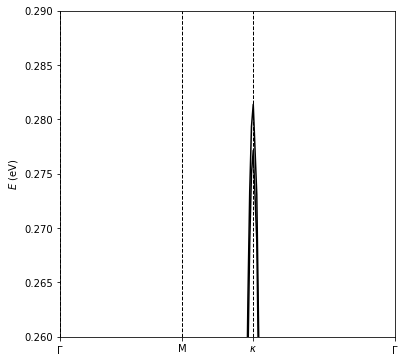

: 

In [ ]:
WSe2=TB(data,'WSe2',data_lattice=data_lattice,data_interlayer=data_interlayer,SOC=data_SOC,N_n=5,theta=180,)
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2.plot_dispersion(XM2=True,ax=ax,color='k',spinless=False,monolayer=False,eff=1)
ax.set_ylim(0.26,.29)

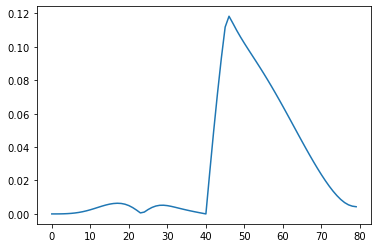

: 

In [ ]:
plt.plot(energy_list[:80,16]-energy_list[:80,17])

In [ ]:
np.round(MoS2.get_t_mat(0,0),3)

array([[ 0.273+0.j,  0.   +0.j,  0.   +0.j],
       [ 0.   +0.j,  0.273+0.j, -0.   +0.j],
       [ 0.   +0.j, -0.   +0.j,  2.467+0.j]])

: 

: 

In [ ]:
np.round(MoS2.get_t_mat(*MoS2.high_symm['kappa']),3)

array([[-0.271+0.j,  0.   +0.j, -0.   +0.j],
       [ 0.   +0.j,  0.271+0.j,  0.793+0.j],
       [-0.   +0.j,  0.793+0.j, -0.   +0.j]])

: 

: 

In [ ]:
WSe2=TB(data,material='WSe2',data_lattice=data_lattice,SOC=data_SOC)

: 

: 

(-1.0, 0.5)

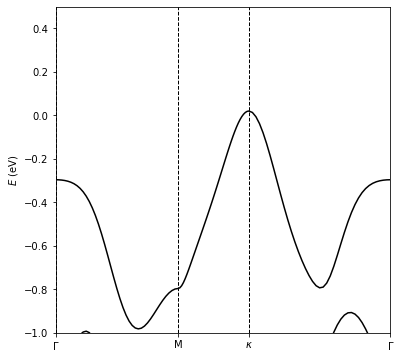

: 

: 

In [ ]:
fig,ax=plt.subplots(figsize=(6,6))
WSe2.plot_dispersion(XM2=True,ax=ax,color='k')
ax.set_ylim(-1,.5)

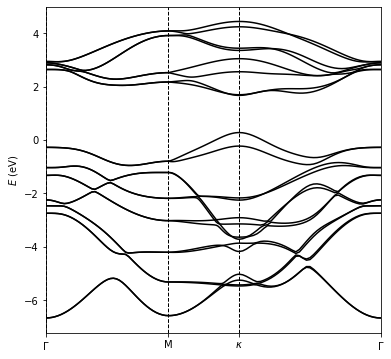

: 

: 

In [ ]:
fig,ax=plt.subplots(figsize=(6,6))
energy_list=WSe2.plot_dispersion(XM2=True,ax=ax,color='k',spinless=False)

(0.0, 39.0)

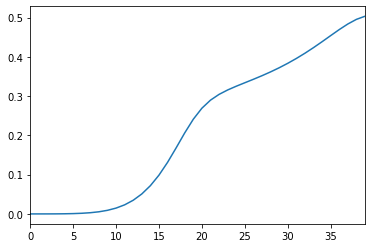

: 

: 

In [ ]:
splitting=energy_list[-40:,8]-energy_list[-40:,9]
fig,ax=plt.subplots()
ax.plot(splitting[::-1])
ax.set_xlim(0,39)
# ax.set_ylim(0,0.15)
# ax.set_yticks(np.arange(0,0.16,0.05))

In [ ]:
diag_sp=sparse(diag)

: 

: 

In [ ]:
off_diag_sp=sparse(off_diag)+sparse(off_diag).T.conj()

: 

: 

In [ ]:
pd.DataFrame(H.toarray())

0                   1                   2   \
0   0.813908+0.000000j  0.728793-0.575836j -0.325992+1.097725j   
1   0.728793+0.575836j  0.936195+0.000000j -2.315592+0.408147j   
2  -0.325992-1.097725j -2.315592-0.408147j -1.161443+0.000000j   
3   1.731583-1.140644j -0.348296-1.172830j  0.257036-0.055329j   
4  -0.348296-1.172830j  1.721688+1.203862j  0.003836-0.230420j   
5   0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
6   0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
7   0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
8   0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
9   0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
10  0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   

                    3                   4                   5   \
0   1.731583+1.140644j -0.348296+1.172830j  0.000000+0.000000j   
1  -0.348296+1.172830j  1.721688-1.203862j  0.000000+0.000000j   
2   0.257036+0.055329j  0.003836+0.230420j  0.000000+0.000000j   
3  -0.268967+0.000000j -0.703632+0.188113j  0.000000+0.000000j   
4  -0.703632-0.188113j -0.806941+0.000000j  0.000000+0.000000j   
5   0.000000+0.000000j  0.000000+0.000000j -0.799142+0.000000j   
6   0.000000+0.000000j  0.000000+0.000000j -0.493038-0.366024j   
7   0.000000+0.000000j  0.000000+0.000000j -0.023141-0.265156j   
8   0.000000+0.000000j  0.000000+0.000000j -2.227071-0.040770j   
9   0.000000+0.000000j  0.000000+0.000000j -0.222261-0.748427j   
10  0.000000+0.000000j  0.000000+0.000000j  0.003157-0.748059j   

                    6                   7                   8   \
0   0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
1   0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
2   0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
3   0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
4   0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
5  -0.493038+0.366024j -0.023141+0.265156j -2.227071+0.040770j   
6  -0.014202+0.000000j -0.153760-0.228876j -0.225405+0.759014j   
7  -0.153760+0.228876j -0.439959+0.000000j -1.601100+0.282211j   
8  -0.225405-0.759014j -1.601100-0.282211j -3.320126+0.000000j   
9   2.598696+0.349820j  0.089796+0.302372j -0.169411+0.099430j   
10  0.089796+0.302372j  2.601247-0.254626j -0.000424+0.246167j   

                    9                   10  
0   0.000000+0.000000j  0.000000+0.000000j  
1   0.000000+0.000000j  0.000000+0.000000j  
2   0.000000+0.000000j  0.000000+0.000000j  
3   0.000000+0.000000j  0.000000+0.000000j  
4   0.000000+0.000000j  0.000000+0.000000j  
5  -0.222261+0.748427j  0.003157+0.748059j  
6   2.598696-0.349820j  0.089796-0.302372j  
7   0.089796-0.302372j  2.601247+0.254626j  
8  -0.169411-0.099430j -0.000424-0.246167j  
9  -0.656045+0.000000j -0.652436+0.205522j  
10 -0.652436-0.205522j -1.119378+0.000000j

: 

: 

In [ ]:
np.array(off_diag)[:,2]

array([ 0.00000000e+00+0.j, -2.77555756e-17+0.j,  0.00000000e+00+0.j,
        7.19553277e-01+0.j,  1.81062498e-02+0.j, -7.70318532e-01+0.j,
       -8.23948011e-01+0.j, -2.23825956e-01+0.j,  9.33096189e-02+0.j,
       -7.07878823e-01+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
        0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
       -0.00000000e+00+0.j, -0.00000000e+00+0.j,  2.05515000e+00+0.j,
       -2.75800000e+00+0.j,  2.05515000e+00+0.j, -2.65080000e+00+0.j,
        0.00000000e+00+0.j,  3.09465000e+00+0.j, -1.90700000e+00+0.j,
        3.09465000e+00+0.j])

: 

: 

In [ ]:
csc_matrix((np.array(diag)[:,2],(np.array(diag)[:,0],np.array(diag)[:,1])))

TypeError: 'numpy.float64' object cannot be interpreted as an integer

: 

: 

In [ ]:
diag

[[0.6000000000000001, (1, 1)],
 [0.8392, (2, 2)],
 [-1.4710999999999999, (3, 3)],
 [0.59175, (4, 4)],
 [-0.46055, (5, 5)],
 [-1.3296000000000001, (6, 6)],
 [-0.06300000000000006, (7, 7)],
 [-0.8958000000000002, (8, 8)],
 [-3.6612999999999998, (9, 9)],
 [0.38284999999999997, (10, 10)],
 [-0.52345, (11, 11)]]

: 

: 

In [ ]:
off_diag

[[0j, (3, 5)],
 [(-2.7755575615628914e-17+0j), (6, 8)],
 [0j, (9, 11)],
 [(0.7195532765852377+0j), (1, 2)],
 [(0.018106249833926766+0j), (3, 4)],
 [(-0.7703185324023647+0j), (4, 5)],
 [(-0.8239480107802122+0j), (6, 7)],
 [(-0.2238259562716804+0j), (7, 8)],
 [(0.09330961894323343+0j), (9, 10)],
 [(-0.7078788234498368+0j), (10, 11)],
 [0j, (3, 1)],
 [0j, (5, 1)],
 [0j, (4, 2)],
 [0j, (10, 6)],
 [0j, (9, 7)],
 [(-0+0j), (11, 7)],
 [(-0+0j), (10, 8)],
 [(2.05515+0j), (4, 1)],
 [(-2.758+0j), (3, 2)],
 [(2.05515+0j), (5, 2)],
 [(-2.6508000000000003+0j), (9, 6)],
 [0j, (11, 6)],
 [(3.0946499999999997+0j), (10, 7)],
 [(-1.907+0j), (9, 8)],
 [(3.0946499999999997+0j), (11, 8)]]

: 

: 

In [ ]:
np.array([1,2])@np.array([3,4])

11

: 

: 

In [ ]:
data[['tb','MoS2']]

: 

: 

In [ ]:
txt = "The rain in Spain"
x = re.match("The (\w+) in (\w+)$", txt)

: 

: 

In [ ]:
x

<re.Match object; span=(0, 17), match='The rain in Spain'>

: 

: 

In [ ]:
x.group(1,2)

('rain', 'Spain')

: 

: 

: 

: 

In [ ]:
t=convert_dict('MoS2')

: 

: 

: 

: 

In [ ]:
t=extend_t(t)

: 

: 

In [ ]:
from scipy.sparse import csc_matrix

: 

: 

In [ ]:
k=0
H=csc_matrix((11,11))

: 

: 

: 

: 

In [ ]:
H.toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

: 

: 

In [ ]:
len(t.values())

90

: 

: 

In [ ]:
g

: 

: 

In [ ]:
if g is not None:
    print('1')
else:
    print('2')

2


: 

: 

In [ ]:
pd.DataFrame({'tb':data['tb'],'val':data['MoS2'],'tuple':list(t.keys()),'val2':list(t.values())})

tb      val        tuple     val2
0     epsilon_1   1.0688    (0, 1, 1)   1.0688
1     epsilon_2   1.0688    (0, 2, 2)   1.0688
2     epsilon_3  −0.7755    (0, 3, 3)  −0.7755
3     epsilon_4  −1.2902    (0, 4, 4)  −1.2902
4     epsilon_5  −1.2902    (0, 5, 5)  −1.2902
5     epsilon_6  −0.1380    (0, 6, 6)  −0.1380
6     epsilon_7   0.0874    (0, 7, 7)   0.0874
7     epsilon_8   0.0874    (0, 8, 8)   0.0874
8     epsilon_9  −2.8949    (0, 9, 9)  −2.8949
9    epsilon_10  −1.9065  (0, 10, 10)  −1.9065
10   epsilon_11  −1.9065  (0, 11, 11)  −1.9065
11    t^(1)_1,1  −0.2069    (1, 1, 1)  −0.2069
12    t^(1)_2,2   0.0323    (1, 2, 2)   0.0323
13    t^(1)_3,3  −0.1739    (1, 3, 3)  −0.1739
14    t^(1)_4,4   0.8651    (1, 4, 4)   0.8651
15    t^(1)_5,5  −0.1872    (1, 5, 5)  −0.1872
16    t^(1)_6,6  −0.2979    (1, 6, 6)  −0.2979
17    t^(1)_7,7   0.2747    (1, 7, 7)   0.2747
18    t^(1)_8,8  −0.5581    (1, 8, 8)  −0.5581
19    t^(1)_9,9  −0.1916    (1, 9, 9)  −0.1916
20  t^(1)_10,10   0.9122  (1, 10, 10)   0.9122
21  t^(1)_11,11   0.0059  (1, 11, 11)   0.0059
22    t^(1)_3,5  −0.0679    (1, 3, 5)  −0.0679
23    t^(1)_6,8   0.4096    (1, 6, 8)   0.4096
24   t^(1)_9,11   0.0075   (1, 9, 11)   0.0075
25    t^(1)_1,2  −0.2562    (1, 1, 2)  −0.2562
26    t^(1)_3,4  −0.0995    (1, 3, 4)  −0.0995
27    t^(1)_4,5  −0.0705    (1, 4, 5)  −0.0705
28    t^(1)_6,7  −0.1145    (1, 6, 7)  −0.1145
29    t^(1)_7,8  −0.2487    (1, 7, 8)  −0.2487
30   t^(1)_9,10   0.1063   (1, 9, 10)   0.1063
31  t^(1)_10,11  −0.0385  (1, 10, 11)  −0.0385
32    t^(5)_4,1  −0.7883    (5, 4, 1)  −0.7883
33    t^(5)_3,2  −1.3790    (5, 3, 2)  −1.3790
34    t^(5)_5,2   2.1584    (5, 5, 2)   2.1584
35    t^(5)_9,6  −0.8836    (5, 9, 6)  −0.8836
36   t^(5)_11,6  −0.9402   (5, 11, 6)  −0.9402
37   t^(5)_10,7   1.4114   (5, 10, 7)   1.4114
38    t^(5)_9,8  −0.9535    (5, 9, 8)  −0.9535
39   t^(5)_11,8   0.6517   (5, 11, 8)   0.6517
40    t^(6)_9,6  −0.0686    (6, 9, 6)  −0.0686
41   t^(6)_11,6  −0.1498   (6, 11, 6)  −0.1498
42    t^(6)_9,8  −0.2205    (6, 9, 8)  −0.2205
43   t^(6)_11,8  −0.2451   (6, 11, 8)  −0.2451

: 

: 

{(1,): '1.0688',
 (2,): '1.0688',
 (3,): '−0.7755',
 (4,): '−1.2902',
 (5,): '−1.2902',
 (6,): '−0.1380',
 (7,): '0.0874',
 (8,): '0.0874',
 (9,): '−2.8949',
 (10,): '−1.9065',
 (11,): '−1.9065'}

: 

: 

In [ ]:
convert_dict()

: 

: 

In [ ]:
def extend

: 

: 